# Ver3. 

## 모델 학습을 위해 flavor에 대한 numeric data를 Min-Max Normalization, Robust Scaling을 진행합니다.
---
### 1. flavor에 대해 시각화
### 2. Min-Max Normalization 진행 - data를 0~1로 표현하기 위함.
### 3. Robust Scaling 진행 - outlier의 영향을 줄이기 위해
### 4. 저장하고 이후 model 학습에 사용합니다.

In [1]:
import pandas as pd
import numpy as  np
import random
from tqdm.notebook import tqdm
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
rating = pd.read_csv("dataset/rating.csv", index_col = 0, encoding="utf-8")
whisky = pd.read_csv("dataset/whisky.csv", index_col=0 , encoding="UTF-8")
whisky_index = pd.read_csv("../dataset/whisky_index.csv", index_col=0 , encoding="UTF-8")
user_index = pd.read_csv("../dataset/user_index.csv", index_col=0 , encoding="UTF-8")

## 1. Visualization

In [3]:
cols = whisky.columns.tolist()

In [4]:
cols = [cols[8]] + cols[11:]
cols

['cost_rank',
 'smoky',
 'peaty',
 'spicy',
 'herbal',
 'oily',
 'full_bodied',
 'rich',
 'sweet',
 'salty',
 'vanilla',
 'tart',
 'fruity',
 'floral']

In [5]:
whisky.loc[:, cols].describe()

cost_rank        smoky        peaty        spicy       herbal  \
count  3535.000000  3535.000000  3535.000000  3535.000000  3535.000000   
mean      3.141160    22.308911     8.764356    45.916549    26.206789   
std       1.137736    20.543387    19.420631    20.427383    19.450020   
min       1.000000     0.000000     0.000000     0.000000     0.000000   
25%       2.000000     5.000000     0.000000    30.000000    10.000000   
50%       3.000000    20.000000     0.000000    45.000000    20.000000   
75%       4.000000    30.000000     0.000000    60.000000    40.000000   
max       5.000000   100.000000   100.000000   100.000000   100.000000   

              oily  full_bodied         rich        sweet        salty  \
count  3535.000000  3535.000000  3535.000000  3535.000000  3535.000000   
mean     28.588119    54.667327    54.431966    54.382461     9.555304   
std      19.680687    18.616834    19.170765    18.389508    14.813603   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%      15.000000    40.000000    40.000000    40.000000     0.000000   
50%      25.000000    55.000000    55.000000    60.000000     0.000000   
75%      40.000000    70.000000    70.000000    70.000000    15.000000   
max     100.000000   100.000000   100.000000   100.000000    90.000000   

           vanilla         tart       fruity       floral  
count  3535.000000  3535.000000  3535.000000  3535.000000  
mean     42.981895    25.253748    44.203112    20.699010  
std      21.096638    18.311131    22.691156    20.244514  
min       0.000000     0.000000     0.000000     0.000000  
25%      25.000000    10.000000    25.000000     4.000000  
50%      40.000000    20.000000    40.000000    15.000000  
75%      60.000000    40.000000    60.000000    30.000000  
max     100.000000   100.000000   100.000000    95.000000

### Categorical Variable : cost_rank
---
- 1 의 경우 sparse하기 때문에 주의 필요하다.
- 가능한 방법
    - SMOTE
    - lightfm's loss_weights
    - Regularization : L1, L2 norm
    
🥑 우선 적용해볼 방법은 loss_weights, Regularization L1, L2 norm 을 적용할 예정입니다.

<AxesSubplot: xlabel='cost_rank', ylabel='Count'>

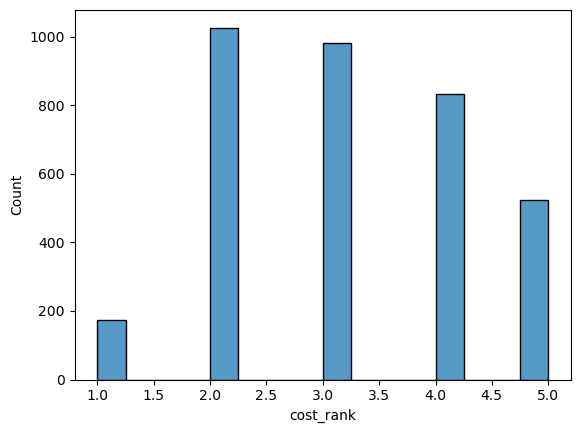

In [6]:
sns.histplot(whisky["cost_rank"])

In [7]:
# Define the columns to scale
numeric_cols = cols[1:]

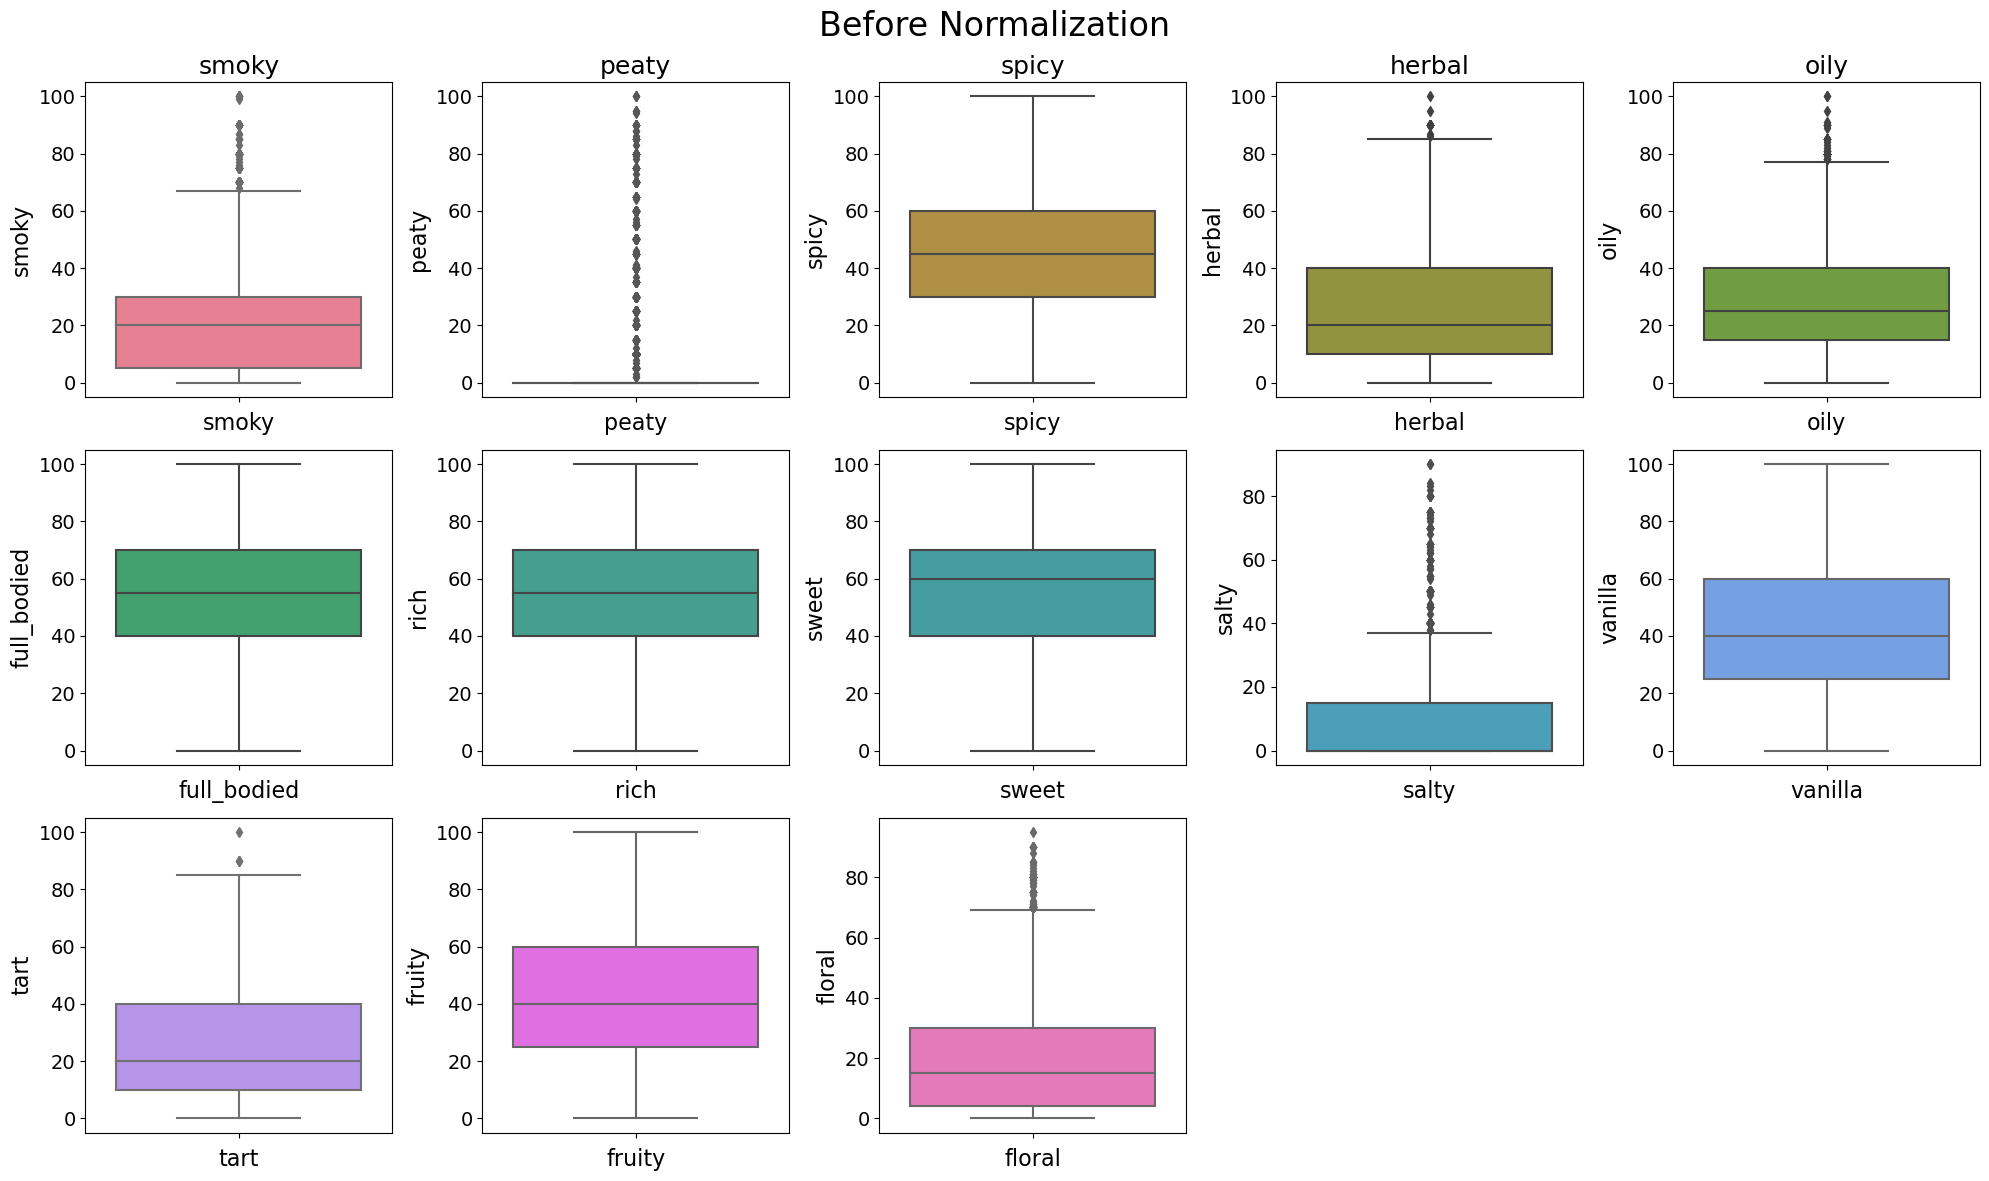

In [8]:
# Define colors for each boxplot
palette = sns.color_palette('husl', n_colors=len(numeric_cols))

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))

# Plot each boxplot
for i, ax in enumerate(axes.flatten()):
    if i >= len(numeric_cols):
        # Remove unused subplot
        ax.remove()
        continue
    sns.boxplot(x='variable', y='value', data=whisky.melt(value_vars=numeric_cols[i]),
                ax=ax, palette=[palette[i]])
    ax.set_xlabel(numeric_cols[i], fontsize=16)
    ax.set_ylabel(numeric_cols[i], fontsize=16)
    ax.tick_params(labelsize=14)
    ax.set_xticklabels([''], fontsize=14)

# Add titles
fig.suptitle('Before Normalization', fontsize=24)
for ax, col in zip(axes[0], numeric_cols):
    ax.set_title(col, fontsize=18)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)

## 2.  Min-Max Normalization 적용한 item_features & user_features

In [9]:
import os

from scipy.sparse import coo_matrix, csr_matrix
from tqdm.notebook import tqdm

# from lightfm import LightFM
# from lightfm.datasets import fetch_movielens
# from lightfm.evaluation import precision_at_k, auc_score, recall_at_k, reciprocal_rank

from sklearn.preprocessing import MinMaxScaler, RobustScaler

In [10]:
# Define the scalers
min_max_scaler = MinMaxScaler()

# Apply Min-Max normalization
min_max_data = min_max_scaler.fit_transform(whisky[numeric_cols])

In [11]:
min_max_data = pd.DataFrame(min_max_data, columns=numeric_cols)
min_max_data

smoky  peaty  spicy  herbal  oily  full_bodied  rich  sweet     salty  \
0      0.30   0.85   0.50    0.30  0.20         0.80  0.80   0.85  0.166667   
1      0.40   0.30   0.40    0.20  0.40         0.70  0.80   0.70  0.444444   
2      0.15   0.00   0.20    0.00  0.15         0.80  0.90   0.85  0.055556   
3      0.40   0.00   0.65    0.50  0.20         0.60  0.60   0.45  0.000000   
4      0.30   0.20   0.40    0.30  0.10         0.75  0.75   0.60  0.222222   
...     ...    ...    ...     ...   ...          ...   ...    ...       ...   
3530   0.35   0.00   0.20    0.00  0.00         0.40  0.55   0.85  0.000000   
3531   0.00   0.00   0.40    0.20  0.00         0.30  0.00   1.00  0.000000   
3532   0.90   0.10   0.10    0.10  0.40         0.10  0.10   0.90  0.000000   
3533   0.00   0.00   0.10    1.00  0.80         0.00  0.00   0.40  0.000000   
3534   0.31   0.00   0.40    0.29  0.00         0.30  0.40   1.00  0.000000   

      vanilla  tart  fruity    floral  
0        0.20  0.25    0.85  0.526316  
1        0.50  0.50    0.70  0.210526  
2        0.30  0.25    0.35  0.000000  
3        0.60  0.60    0.45  0.000000  
4        0.30  0.20    0.50  0.052632  
...       ...   ...     ...       ...  
3530     0.25  0.10    0.10  0.000000  
3531     1.00  0.00    0.60  0.105263  
3532     0.50  0.20    0.30  0.105263  
3533     0.20  0.00    0.00  0.000000  
3534     0.55  0.00    0.30  0.105263  

[3535 rows x 13 columns]

In [12]:
min_max_data.describe()

smoky        peaty        spicy       herbal         oily  \
count  3535.000000  3535.000000  3535.000000  3535.000000  3535.000000   
mean      0.223089     0.087644     0.459165     0.262068     0.285881   
std       0.205434     0.194206     0.204274     0.194500     0.196807   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.050000     0.000000     0.300000     0.100000     0.150000   
50%       0.200000     0.000000     0.450000     0.200000     0.250000   
75%       0.300000     0.000000     0.600000     0.400000     0.400000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

       full_bodied         rich        sweet        salty      vanilla  \
count  3535.000000  3535.000000  3535.000000  3535.000000  3535.000000   
mean      0.546673     0.544320     0.543825     0.106170     0.429819   
std       0.186168     0.191708     0.183895     0.164596     0.210966   
min       0.000000     0.000000     0.000000     0.000000     0.000000   
25%       0.400000     0.400000     0.400000     0.000000     0.250000   
50%       0.550000     0.550000     0.600000     0.000000     0.400000   
75%       0.700000     0.700000     0.700000     0.166667     0.600000   
max       1.000000     1.000000     1.000000     1.000000     1.000000   

              tart       fruity       floral  
count  3535.000000  3535.000000  3535.000000  
mean      0.252537     0.442031     0.217884  
std       0.183111     0.226912     0.213100  
min       0.000000     0.000000     0.000000  
25%       0.100000     0.250000     0.042105  
50%       0.200000     0.400000     0.157895  
75%       0.400000     0.600000     0.315789  
max       1.000000     1.000000     1.000000

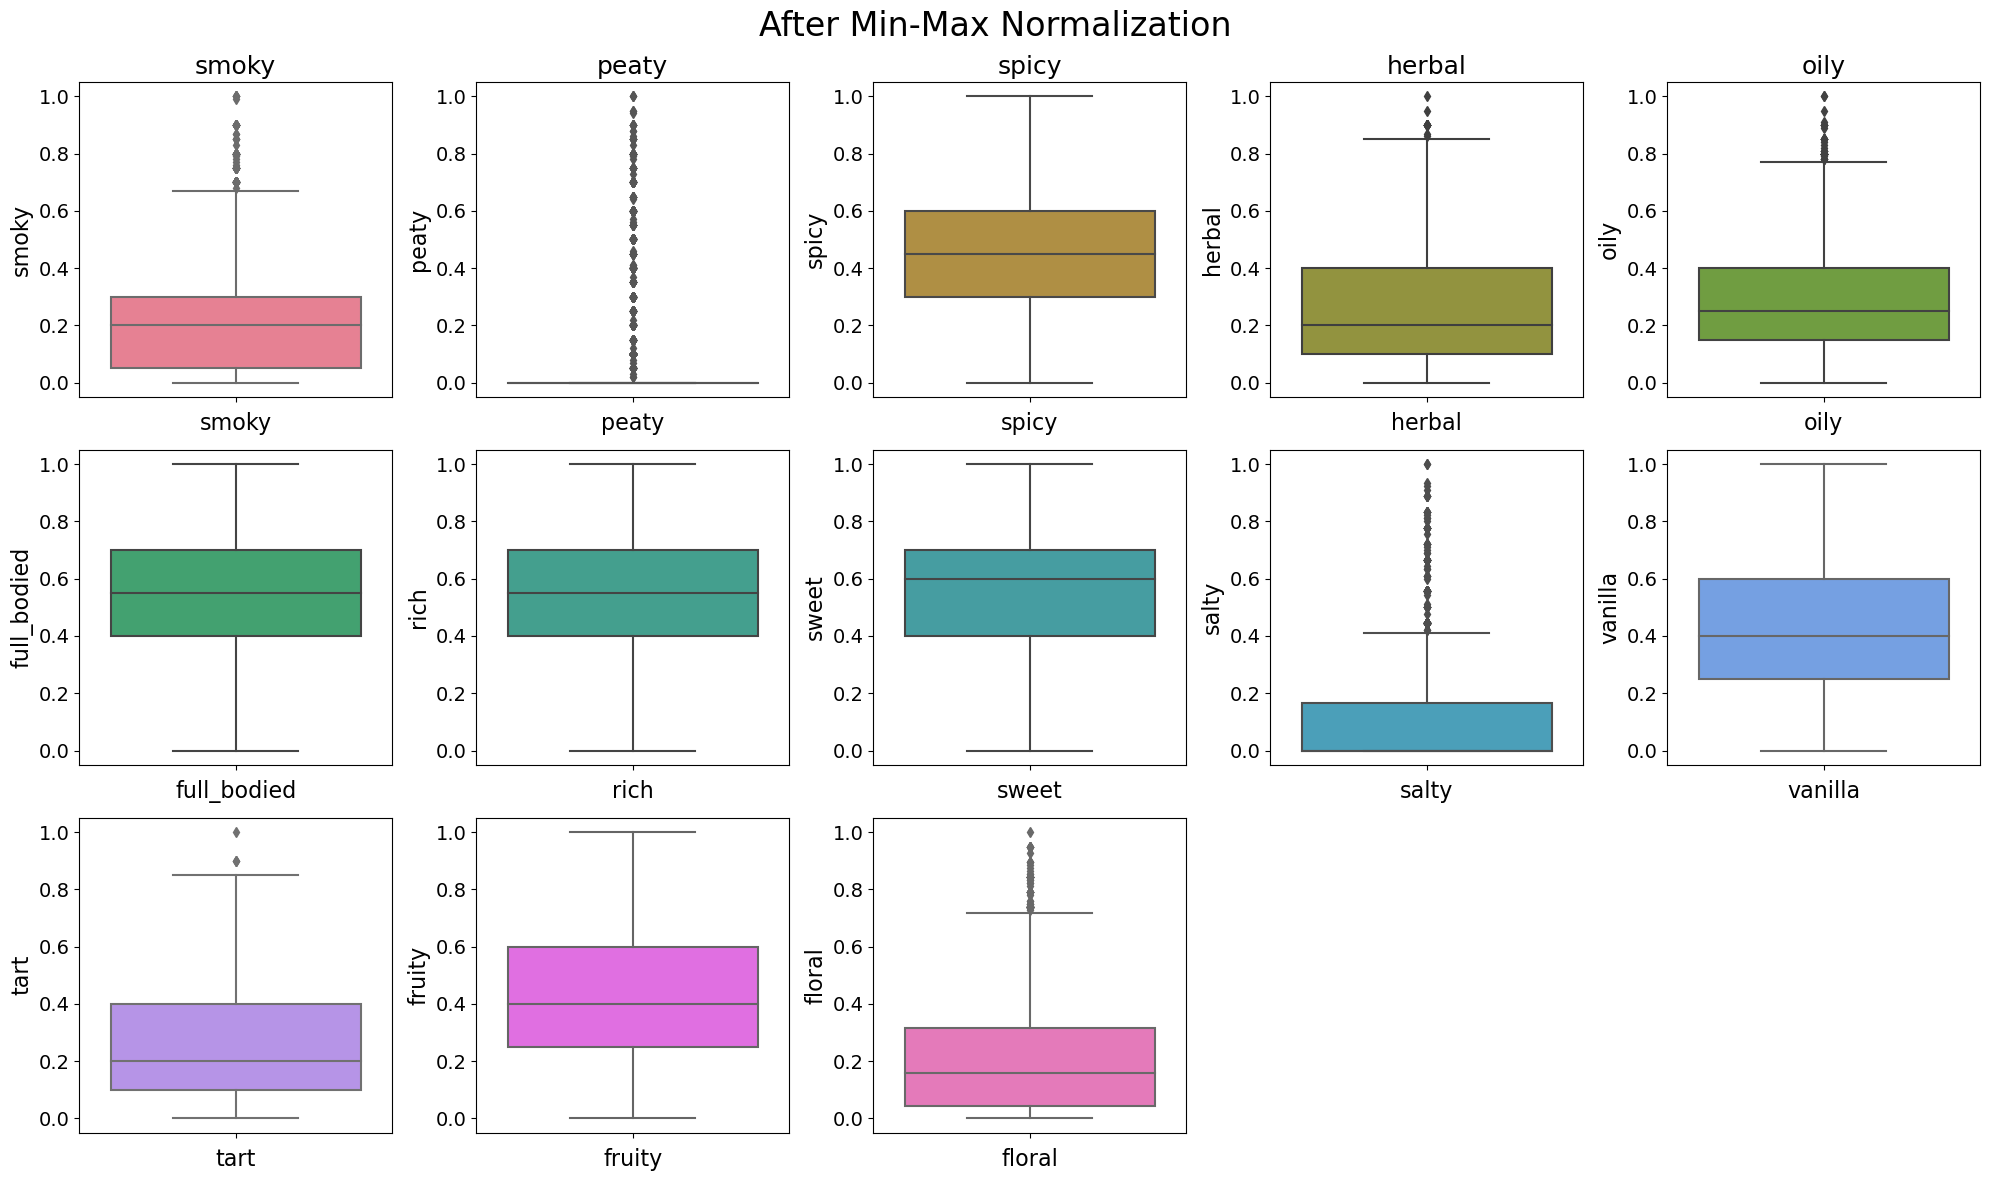

In [13]:
# Define colors for each boxplot
palette = sns.color_palette('husl', n_colors=len(numeric_cols))

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))

# Plot each boxplot
for i, ax in enumerate(axes.flatten()):
    if i >= len(numeric_cols):
        # Remove unused subplot
        ax.remove()
        continue
    sns.boxplot(x='variable', y='value', data=min_max_data.melt(value_vars=numeric_cols[i]),
                ax=ax, palette=[palette[i]])
    ax.set_xlabel(numeric_cols[i], fontsize=16)
    ax.set_ylabel(numeric_cols[i], fontsize=16)
    ax.tick_params(labelsize=14)
    ax.set_xticklabels([''], fontsize=14)

# Add titles
fig.suptitle('After Min-Max Normalization', fontsize=24)
for ax, col in zip(axes[0], numeric_cols):
    ax.set_title(col, fontsize=18)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)


### 2-1. item_features 생성

In [17]:
item_features = np.zeros((whisky['whisky_id'].nunique(), len(cols)))
for i in range(whisky['whisky_id'].nunique()):
    for j, col_name in enumerate(cols):
        item_features[i, j] = whisky.iloc[i][col_name] if col_name == "cost_rank" else min_max_data.iloc[i][col_name]
# item_features = csr_matrix(item_features)

In [32]:
item_features

array([[5.        , 0.3       , 0.85      , ..., 0.25      , 0.85      ,
        0.52631579],
       [4.        , 0.4       , 0.3       , ..., 0.5       , 0.7       ,
        0.21052632],
       [5.        , 0.15      , 0.        , ..., 0.25      , 0.35      ,
        0.        ],
       ...,
       [3.        , 0.9       , 0.1       , ..., 0.2       , 0.3       ,
        0.10526316],
       [2.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [1.        , 0.31      , 0.        , ..., 0.        , 0.3       ,
        0.10526316]])

In [33]:
item_features = csr_matrix(item_features)

In [34]:
item_features.shape

(3535, 14)

In [35]:
item_df = pd.DataFrame(data=item_features.toarray(), columns=cols)

In [36]:
item_df.to_csv("dataset/min_max_item_features.csv", encoding="UTF-8")

### 2-2. user_features 만들기
---
- user_features 만들기 위해서 사용자의 입맛이란 데이터가 필요하다.
- user의 rating이 가장 높은 위스키 중 랜덤 샘플링을 통해 입맛을 선정한다.

In [37]:
## user 별로 max rating score 측정
max_rating = rating.groupby("user_id").max(lambda x: max(x))["rating"]

In [38]:
max_rating

user_id
0          9.0
1          9.0
2          9.0
3         10.0
4         10.0
          ... 
119510    10.0
119511     8.0
119512     6.0
119513     2.0
119514     8.0
Name: rating, Length: 119515, dtype: float64

In [39]:
user_feature_ids = []
for i in range(rating["user_id"].nunique()):
    user_feature_ids.append([])
    
    
for i, row in tqdm(rating.iterrows()):
    if int(row["rating"]) == max_rating[int(row["user_id"])]: user_feature_ids[int(row["user_id"])].append(int(row["whisky_id"]))

0it [00:00, ?it/s]

In [50]:
min_max_data.iloc[5][:].tolist()

[0.5,
 0.1,
 0.6,
 0.0,
 0.15,
 0.9,
 1.0,
 0.5,
 0.0,
 0.2,
 0.2,
 0.8,
 0.10526315789473684]

In [51]:
def make_minmax_user_features(user_feature_ids, data):
    user_features = []
    for i, info in enumerate(user_feature_ids):
        whisky_id = info[random.randint(0, len(info)-1)]
        print(f"{i} user - {whisky_id}")
        whisky_info = [whisky.iloc[whisky_id]["cost_rank"]] + min_max_data.iloc[whisky_id][:].tolist()
        user_features.append(whisky_info)
    return user_features

In [52]:
user_features = make_minmax_user_features(user_feature_ids, whisky)

0 user - 0
1 user - 1093
2 user - 450
3 user - 0
4 user - 81
5 user - 0
6 user - 0
7 user - 70
8 user - 0
9 user - 0
10 user - 556
11 user - 1676
12 user - 1107
13 user - 1340
14 user - 0
15 user - 0
16 user - 0
17 user - 409
18 user - 37
19 user - 0
20 user - 0
21 user - 0
22 user - 25
23 user - 0
24 user - 0
25 user - 0
26 user - 0
27 user - 0
28 user - 0
29 user - 94
30 user - 0
31 user - 2657
32 user - 597
33 user - 1368
34 user - 0
35 user - 0
36 user - 811
37 user - 0
38 user - 0
39 user - 0
40 user - 0
41 user - 0
42 user - 0
43 user - 0
44 user - 0
45 user - 0
46 user - 0
47 user - 37
48 user - 1107
49 user - 13
50 user - 37
51 user - 94
52 user - 0
53 user - 0
54 user - 1
55 user - 0
56 user - 885
57 user - 1341
58 user - 43
59 user - 0
60 user - 0
61 user - 0
62 user - 1672
63 user - 0
64 user - 0
65 user - 0
66 user - 0
67 user - 2832
68 user - 0
69 user - 2669
70 user - 170
71 user - 0
72 user - 0
73 user - 0
74 user - 0
75 user - 0
76 user - 795
77 user - 1364
78 user - 60

1478 user - 345
1479 user - 784
1480 user - 695
1481 user - 394
1482 user - 392
1483 user - 1
1484 user - 1676
1485 user - 1
1486 user - 1107
1487 user - 392
1488 user - 35
1489 user - 2890
1490 user - 195
1491 user - 1
1492 user - 78
1493 user - 795
1494 user - 1
1495 user - 408
1496 user - 2391
1497 user - 774
1498 user - 1663
1499 user - 609
1500 user - 3080
1501 user - 87
1502 user - 557
1503 user - 601
1504 user - 2233
1505 user - 1
1506 user - 386
1507 user - 92
1508 user - 3120
1509 user - 67
1510 user - 1
1511 user - 94
1512 user - 1
1513 user - 1481
1514 user - 591
1515 user - 1093
1516 user - 261
1517 user - 2860
1518 user - 1
1519 user - 2243
1520 user - 1
1521 user - 1
1522 user - 345
1523 user - 481
1524 user - 1
1525 user - 1
1526 user - 900
1527 user - 690
1528 user - 123
1529 user - 406
1530 user - 1626
1531 user - 1344
1532 user - 218
1533 user - 1
1534 user - 591
1535 user - 1
1536 user - 141
1537 user - 1
1538 user - 1081
1539 user - 1082
1540 user - 322
1541 user - 

2975 user - 13
2976 user - 406
2977 user - 1
2978 user - 1
2979 user - 3209
2980 user - 1
2981 user - 1678
2982 user - 1348
2983 user - 992
2984 user - 85
2985 user - 1101
2986 user - 406
2987 user - 606
2988 user - 1
2989 user - 1089
2990 user - 1
2991 user - 1986
2992 user - 1
2993 user - 1
2994 user - 2860
2995 user - 1655
2996 user - 94
2997 user - 2255
2998 user - 1107
2999 user - 94
3000 user - 1663
3001 user - 1958
3002 user - 2247
3003 user - 1
3004 user - 1
3005 user - 1
3006 user - 1
3007 user - 1347
3008 user - 403
3009 user - 56
3010 user - 1
3011 user - 94
3012 user - 1047
3013 user - 1989
3014 user - 1068
3015 user - 256
3016 user - 2670
3017 user - 609
3018 user - 606
3019 user - 584
3020 user - 609
3021 user - 3086
3022 user - 1
3023 user - 1
3024 user - 1
3025 user - 609
3026 user - 1097
3027 user - 28
3028 user - 14
3029 user - 609
3030 user - 406
3031 user - 1
3032 user - 1
3033 user - 1
3034 user - 803
3035 user - 1
3036 user - 88
3037 user - 2860
3038 user - 409
30

4407 user - 1669
4408 user - 85
4409 user - 35
4410 user - 8
4411 user - 1051
4412 user - 8
4413 user - 72
4414 user - 409
4415 user - 2453
4416 user - 1062
4417 user - 2830
4418 user - 16
4419 user - 1895
4420 user - 34
4421 user - 763
4422 user - 13
4423 user - 9
4424 user - 9
4425 user - 401
4426 user - 1044
4427 user - 9
4428 user - 9
4429 user - 9
4430 user - 1672
4431 user - 608
4432 user - 678
4433 user - 232
4434 user - 9
4435 user - 401
4436 user - 409
4437 user - 1672
4438 user - 736
4439 user - 2241
4440 user - 94
4441 user - 9
4442 user - 401
4443 user - 9
4444 user - 9
4445 user - 2854
4446 user - 9
4447 user - 9
4448 user - 127
4449 user - 597
4450 user - 73
4451 user - 609
4452 user - 401
4453 user - 9
4454 user - 32
4455 user - 2453
4456 user - 9
4457 user - 772
4458 user - 9
4459 user - 33
4460 user - 598
4461 user - 1024
4462 user - 9
4463 user - 9
4464 user - 72
4465 user - 9
4466 user - 12
4467 user - 379
4468 user - 10
4469 user - 939
4470 user - 1362
4471 user - 1

5945 user - 1303
5946 user - 13
5947 user - 13
5948 user - 156
5949 user - 13
5950 user - 13
5951 user - 1057
5952 user - 1952
5953 user - 613
5954 user - 2652
5955 user - 609
5956 user - 1094
5957 user - 593
5958 user - 807
5959 user - 1079
5960 user - 2486
5961 user - 810
5962 user - 13
5963 user - 13
5964 user - 1104
5965 user - 778
5966 user - 1023
5967 user - 92
5968 user - 13
5969 user - 1036
5970 user - 3223
5971 user - 13
5972 user - 394
5973 user - 807
5974 user - 13
5975 user - 13
5976 user - 13
5977 user - 1342
5978 user - 1368
5979 user - 2857
5980 user - 584
5981 user - 408
5982 user - 1368
5983 user - 13
5984 user - 253
5985 user - 396
5986 user - 2860
5987 user - 2472
5988 user - 1359
5989 user - 408
5990 user - 609
5991 user - 2468
5992 user - 13
5993 user - 1669
5994 user - 815
5995 user - 3213
5996 user - 13
5997 user - 584
5998 user - 139
5999 user - 614
6000 user - 1081
6001 user - 40
6002 user - 1341
6003 user - 35
6004 user - 1679
6005 user - 593
6006 user - 247
6

7456 user - 37
7457 user - 1344
7458 user - 37
7459 user - 37
7460 user - 155
7461 user - 37
7462 user - 1922
7463 user - 1674
7464 user - 811
7465 user - 609
7466 user - 753
7467 user - 1081
7468 user - 2122
7469 user - 37
7470 user - 37
7471 user - 811
7472 user - 37
7473 user - 37
7474 user - 37
7475 user - 37
7476 user - 37
7477 user - 2198
7478 user - 221
7479 user - 730
7480 user - 37
7481 user - 37
7482 user - 1933
7483 user - 138
7484 user - 37
7485 user - 593
7486 user - 1073
7487 user - 37
7488 user - 801
7489 user - 2827
7490 user - 377
7491 user - 37
7492 user - 37
7493 user - 37
7494 user - 398
7495 user - 37
7496 user - 3051
7497 user - 37
7498 user - 1073
7499 user - 69
7500 user - 37
7501 user - 37
7502 user - 37
7503 user - 37
7504 user - 557
7505 user - 91
7506 user - 1936
7507 user - 37
7508 user - 1907
7509 user - 37
7510 user - 37
7511 user - 991
7512 user - 37
7513 user - 37
7514 user - 37
7515 user - 37
7516 user - 801
7517 user - 406
7518 user - 405
7519 user - 

8920 user - 609
8921 user - 609
8922 user - 55
8923 user - 385
8924 user - 2234
8925 user - 1278
8926 user - 1673
8927 user - 1366
8928 user - 55
8929 user - 1366
8930 user - 1342
8931 user - 817
8932 user - 1663
8933 user - 591
8934 user - 1663
8935 user - 55
8936 user - 2243
8937 user - 95
8938 user - 1340
8939 user - 55
8940 user - 203
8941 user - 55
8942 user - 1609
8943 user - 683
8944 user - 55
8945 user - 55
8946 user - 1249
8947 user - 55
8948 user - 676
8949 user - 2425
8950 user - 396
8951 user - 55
8952 user - 397
8953 user - 409
8954 user - 613
8955 user - 395
8956 user - 593
8957 user - 55
8958 user - 55
8959 user - 2400
8960 user - 1922
8961 user - 1211
8962 user - 55
8963 user - 1368
8964 user - 55
8965 user - 930
8966 user - 395
8967 user - 55
8968 user - 2453
8969 user - 1335
8970 user - 2349
8971 user - 395
8972 user - 3057
8973 user - 1102
8974 user - 55
8975 user - 1040
8976 user - 2333
8977 user - 1674
8978 user - 88
8979 user - 1341
8980 user - 86
8981 user - 56
8

10317 user - 591
10318 user - 1107
10319 user - 1548
10320 user - 86
10321 user - 1319
10322 user - 2242
10323 user - 86
10324 user - 86
10325 user - 970
10326 user - 406
10327 user - 1102
10328 user - 1102
10329 user - 591
10330 user - 1278
10331 user - 1322
10332 user - 588
10333 user - 395
10334 user - 86
10335 user - 591
10336 user - 86
10337 user - 1341
10338 user - 406
10339 user - 1097
10340 user - 2053
10341 user - 601
10342 user - 86
10343 user - 1107
10344 user - 86
10345 user - 2672
10346 user - 557
10347 user - 557
10348 user - 86
10349 user - 86
10350 user - 2184
10351 user - 1097
10352 user - 86
10353 user - 86
10354 user - 86
10355 user - 1081
10356 user - 1078
10357 user - 591
10358 user - 789
10359 user - 86
10360 user - 3086
10361 user - 557
10362 user - 86
10363 user - 88
10364 user - 86
10365 user - 395
10366 user - 86
10367 user - 226
10368 user - 86
10369 user - 86
10370 user - 2108
10371 user - 86
10372 user - 609
10373 user - 789
10374 user - 86
10375 user - 223

11631 user - 1896
11632 user - 752
11633 user - 2670
11634 user - 2610
11635 user - 1976
11636 user - 1097
11637 user - 92
11638 user - 2241
11639 user - 2203
11640 user - 92
11641 user - 1655
11642 user - 1097
11643 user - 3387
11644 user - 1987
11645 user - 810
11646 user - 1097
11647 user - 795
11648 user - 406
11649 user - 609
11650 user - 812
11651 user - 201
11652 user - 92
11653 user - 92
11654 user - 92
11655 user - 2854
11656 user - 593
11657 user - 406
11658 user - 3459
11659 user - 1802
11660 user - 92
11661 user - 1102
11662 user - 395
11663 user - 609
11664 user - 1245
11665 user - 92
11666 user - 2888
11667 user - 92
11668 user - 814
11669 user - 92
11670 user - 1350
11671 user - 801
11672 user - 519
11673 user - 2672
11674 user - 1976
11675 user - 695
11676 user - 92
11677 user - 92
11678 user - 92
11679 user - 92
11680 user - 1320
11681 user - 92
11682 user - 1089
11683 user - 92
11684 user - 2072
11685 user - 1976
11686 user - 2254
11687 user - 205
11688 user - 1640
11

12961 user - 2599
12962 user - 593
12963 user - 92
12964 user - 406
12965 user - 2854
12966 user - 1922
12967 user - 1084
12968 user - 92
12969 user - 804
12970 user - 585
12971 user - 92
12972 user - 94
12973 user - 609
12974 user - 1359
12975 user - 609
12976 user - 1678
12977 user - 609
12978 user - 609
12979 user - 2250
12980 user - 92
12981 user - 2387
12982 user - 3142
12983 user - 1674
12984 user - 92
12985 user - 2617
12986 user - 92
12987 user - 94
12988 user - 1095
12989 user - 1987
12990 user - 1105
12991 user - 608
12992 user - 92
12993 user - 92
12994 user - 1976
12995 user - 609
12996 user - 92
12997 user - 2651
12998 user - 92
12999 user - 695
13000 user - 1678
13001 user - 2829
13002 user - 92
13003 user - 3012
13004 user - 737
13005 user - 2252
13006 user - 1097
13007 user - 1076
13008 user - 92
13009 user - 817
13010 user - 1368
13011 user - 2665
13012 user - 899
13013 user - 92
13014 user - 92
13015 user - 92
13016 user - 574
13017 user - 1095
13018 user - 1097
13019

14513 user - 815
14514 user - 2243
14515 user - 403
14516 user - 2459
14517 user - 1097
14518 user - 94
14519 user - 1989
14520 user - 609
14521 user - 609
14522 user - 609
14523 user - 609
14524 user - 1976
14525 user - 753
14526 user - 2487
14527 user - 2138
14528 user - 609
14529 user - 609
14530 user - 991
14531 user - 92
14532 user - 92
14533 user - 2223
14534 user - 92
14535 user - 1979
14536 user - 609
14537 user - 92
14538 user - 92
14539 user - 403
14540 user - 2486
14541 user - 2475
14542 user - 95
14543 user - 2610
14544 user - 238
14545 user - 231
14546 user - 559
14547 user - 2230
14548 user - 752
14549 user - 1560
14550 user - 92
14551 user - 92
14552 user - 2460
14553 user - 805
14554 user - 1368
14555 user - 92
14556 user - 1663
14557 user - 92
14558 user - 92
14559 user - 609
14560 user - 249
14561 user - 1987
14562 user - 2255
14563 user - 92
14564 user - 406
14565 user - 811
14566 user - 1041
14567 user - 1018
14568 user - 3117
14569 user - 1600
14570 user - 92
14571

15863 user - 92
15864 user - 92
15865 user - 609
15866 user - 92
15867 user - 257
15868 user - 92
15869 user - 1056
15870 user - 92
15871 user - 92
15872 user - 1359
15873 user - 92
15874 user - 798
15875 user - 92
15876 user - 609
15877 user - 152
15878 user - 1939
15879 user - 92
15880 user - 1097
15881 user - 1350
15882 user - 609
15883 user - 92
15884 user - 1097
15885 user - 804
15886 user - 519
15887 user - 92
15888 user - 1097
15889 user - 1349
15890 user - 593
15891 user - 609
15892 user - 92
15893 user - 609
15894 user - 95
15895 user - 2241
15896 user - 92
15897 user - 1663
15898 user - 814
15899 user - 92
15900 user - 1101
15901 user - 2473
15902 user - 94
15903 user - 1987
15904 user - 1975
15905 user - 1103
15906 user - 406
15907 user - 92
15908 user - 92
15909 user - 1101
15910 user - 2672
15911 user - 1089
15912 user - 1655
15913 user - 2658
15914 user - 92
15915 user - 92
15916 user - 609
15917 user - 811
15918 user - 609
15919 user - 1668
15920 user - 609
15921 user - 

17386 user - 94
17387 user - 3349
17388 user - 2095
17389 user - 767
17390 user - 257
17391 user - 609
17392 user - 406
17393 user - 695
17394 user - 94
17395 user - 1078
17396 user - 94
17397 user - 807
17398 user - 276
17399 user - 94
17400 user - 519
17401 user - 94
17402 user - 723
17403 user - 1748
17404 user - 94
17405 user - 2665
17406 user - 1524
17407 user - 1335
17408 user - 3194
17409 user - 94
17410 user - 401
17411 user - 609
17412 user - 609
17413 user - 94
17414 user - 3223
17415 user - 795
17416 user - 94
17417 user - 2668
17418 user - 94
17419 user - 1347
17420 user - 94
17421 user - 609
17422 user - 1922
17423 user - 811
17424 user - 1976
17425 user - 94
17426 user - 94
17427 user - 1075
17428 user - 94
17429 user - 2453
17430 user - 1860
17431 user - 468
17432 user - 94
17433 user - 94
17434 user - 94
17435 user - 789
17436 user - 1081
17437 user - 609
17438 user - 2241
17439 user - 123
17440 user - 94
17441 user - 2243
17442 user - 1097
17443 user - 1097
17444 user 

18622 user - 94
18623 user - 94
18624 user - 97
18625 user - 1347
18626 user - 94
18627 user - 406
18628 user - 1097
18629 user - 609
18630 user - 955
18631 user - 816
18632 user - 94
18633 user - 1317
18634 user - 609
18635 user - 94
18636 user - 609
18637 user - 2857
18638 user - 609
18639 user - 94
18640 user - 94
18641 user - 545
18642 user - 1976
18643 user - 94
18644 user - 2242
18645 user - 2956
18646 user - 406
18647 user - 2486
18648 user - 815
18649 user - 2140
18650 user - 2243
18651 user - 156
18652 user - 1361
18653 user - 976
18654 user - 991
18655 user - 2665
18656 user - 2421
18657 user - 609
18658 user - 94
18659 user - 1674
18660 user - 1368
18661 user - 2241
18662 user - 608
18663 user - 816
18664 user - 2241
18665 user - 807
18666 user - 807
18667 user - 94
18668 user - 609
18669 user - 1922
18670 user - 817
18671 user - 609
18672 user - 598
18673 user - 1630
18674 user - 1524
18675 user - 2360
18676 user - 94
18677 user - 574
18678 user - 1322
18679 user - 1102
186

19876 user - 246
19877 user - 1101
19878 user - 392
19879 user - 94
19880 user - 1975
19881 user - 1663
19882 user - 406
19883 user - 1096
19884 user - 94
19885 user - 94
19886 user - 2216
19887 user - 804
19888 user - 598
19889 user - 2241
19890 user - 94
19891 user - 94
19892 user - 1084
19893 user - 94
19894 user - 94
19895 user - 94
19896 user - 94
19897 user - 94
19898 user - 94
19899 user - 94
19900 user - 609
19901 user - 798
19902 user - 596
19903 user - 1994
19904 user - 1667
19905 user - 94
19906 user - 2468
19907 user - 1089
19908 user - 94
19909 user - 94
19910 user - 94
19911 user - 2473
19912 user - 94
19913 user - 798
19914 user - 602
19915 user - 1327
19916 user - 1081
19917 user - 94
19918 user - 1087
19919 user - 1655
19920 user - 1946
19921 user - 94
19922 user - 609
19923 user - 411
19924 user - 1089
19925 user - 94
19926 user - 2242
19927 user - 94
19928 user - 148
19929 user - 94
19930 user - 94
19931 user - 401
19932 user - 811
19933 user - 1987
19934 user - 609


21100 user - 2486
21101 user - 94
21102 user - 2852
21103 user - 94
21104 user - 1097
21105 user - 602
21106 user - 94
21107 user - 95
21108 user - 3223
21109 user - 94
21110 user - 815
21111 user - 94
21112 user - 94
21113 user - 2666
21114 user - 2242
21115 user - 1107
21116 user - 2840
21117 user - 94
21118 user - 95
21119 user - 94
21120 user - 2472
21121 user - 94
21122 user - 1340
21123 user - 1994
21124 user - 265
21125 user - 609
21126 user - 94
21127 user - 401
21128 user - 94
21129 user - 1107
21130 user - 1681
21131 user - 609
21132 user - 94
21133 user - 609
21134 user - 94
21135 user - 1987
21136 user - 3349
21137 user - 609
21138 user - 94
21139 user - 94
21140 user - 94
21141 user - 94
21142 user - 94
21143 user - 94
21144 user - 94
21145 user - 94
21146 user - 94
21147 user - 609
21148 user - 94
21149 user - 2669
21150 user - 1994
21151 user - 2234
21152 user - 257
21153 user - 2461
21154 user - 94
21155 user - 94
21156 user - 94
21157 user - 94
21158 user - 609
21159 u

22521 user - 97
22522 user - 2350
22523 user - 1089
22524 user - 789
22525 user - 789
22526 user - 556
22527 user - 787
22528 user - 1352
22529 user - 1655
22530 user - 97
22531 user - 97
22532 user - 97
22533 user - 789
22534 user - 460
22535 user - 1674
22536 user - 1368
22537 user - 1075
22538 user - 97
22539 user - 97
22540 user - 789
22541 user - 1355
22542 user - 97
22543 user - 1075
22544 user - 2379
22545 user - 409
22546 user - 1106
22547 user - 723
22548 user - 1061
22549 user - 3422
22550 user - 695
22551 user - 97
22552 user - 2860
22553 user - 97
22554 user - 409
22555 user - 817
22556 user - 1075
22557 user - 97
22558 user - 97
22559 user - 1557
22560 user - 1986
22561 user - 345
22562 user - 97
22563 user - 2486
22564 user - 97
22565 user - 1470
22566 user - 1448
22567 user - 807
22568 user - 817
22569 user - 584
22570 user - 345
22571 user - 1368
22572 user - 97
22573 user - 298
22574 user - 1368
22575 user - 1994
22576 user - 1090
22577 user - 1368
22578 user - 2350
22

23831 user - 2379
23832 user - 97
23833 user - 807
23834 user - 1368
23835 user - 2254
23836 user - 785
23837 user - 609
23838 user - 97
23839 user - 97
23840 user - 614
23841 user - 1344
23842 user - 598
23843 user - 2677
23844 user - 1075
23845 user - 2486
23846 user - 2860
23847 user - 97
23848 user - 97
23849 user - 1368
23850 user - 144
23851 user - 611
23852 user - 97
23853 user - 97
23854 user - 1075
23855 user - 545
23856 user - 97
23857 user - 212
23858 user - 1368
23859 user - 602
23860 user - 817
23861 user - 1322
23862 user - 1368
23863 user - 746
23864 user - 97
23865 user - 97
23866 user - 97
23867 user - 1341
23868 user - 97
23869 user - 97
23870 user - 409
23871 user - 97
23872 user - 97
23873 user - 2840
23874 user - 817
23875 user - 1075
23876 user - 2453
23877 user - 144
23878 user - 1986
23879 user - 787
23880 user - 256
23881 user - 1013
23882 user - 409
23883 user - 97
23884 user - 410
23885 user - 596
23886 user - 97
23887 user - 144
23888 user - 1078
23889 user 

25001 user - 977
25002 user - 686
25003 user - 113
25004 user - 113
25005 user - 1368
25006 user - 861
25007 user - 322
25008 user - 2453
25009 user - 470
25010 user - 113
25011 user - 343
25012 user - 113
25013 user - 113
25014 user - 113
25015 user - 113
25016 user - 1367
25017 user - 113
25018 user - 113
25019 user - 606
25020 user - 113
25021 user - 114
25022 user - 609
25023 user - 1102
25024 user - 114
25025 user - 772
25026 user - 115
25027 user - 1896
25028 user - 115
25029 user - 261
25030 user - 518
25031 user - 557
25032 user - 116
25033 user - 3307
25034 user - 116
25035 user - 1088
25036 user - 116
25037 user - 2440
25038 user - 116
25039 user - 116
25040 user - 609
25041 user - 2011
25042 user - 322
25043 user - 117
25044 user - 1348
25045 user - 117
25046 user - 117
25047 user - 786
25048 user - 117
25049 user - 1342
25050 user - 817
25051 user - 118
25052 user - 1368
25053 user - 394
25054 user - 805
25055 user - 2453
25056 user - 642
25057 user - 118
25058 user - 394
2

26193 user - 141
26194 user - 1341
26195 user - 807
26196 user - 468
26197 user - 141
26198 user - 1075
26199 user - 408
26200 user - 141
26201 user - 322
26202 user - 242
26203 user - 1347
26204 user - 141
26205 user - 1089
26206 user - 1611
26207 user - 1035
26208 user - 141
26209 user - 807
26210 user - 141
26211 user - 2663
26212 user - 2888
26213 user - 2661
26214 user - 141
26215 user - 141
26216 user - 2678
26217 user - 141
26218 user - 2053
26219 user - 2888
26220 user - 141
26221 user - 394
26222 user - 2854
26223 user - 401
26224 user - 1661
26225 user - 614
26226 user - 1368
26227 user - 2888
26228 user - 801
26229 user - 1035
26230 user - 407
26231 user - 141
26232 user - 674
26233 user - 141
26234 user - 141
26235 user - 1368
26236 user - 1078
26237 user - 141
26238 user - 1368
26239 user - 394
26240 user - 180
26241 user - 674
26242 user - 1368
26243 user - 1869
26244 user - 2553
26245 user - 141
26246 user - 141
26247 user - 141
26248 user - 593
26249 user - 602
26250 us

27538 user - 156
27539 user - 1368
27540 user - 1676
27541 user - 156
27542 user - 2651
27543 user - 1107
27544 user - 690
27545 user - 710
27546 user - 2860
27547 user - 753
27548 user - 1983
27549 user - 2462
27550 user - 804
27551 user - 795
27552 user - 609
27553 user - 2333
27554 user - 156
27555 user - 156
27556 user - 2672
27557 user - 2854
27558 user - 156
27559 user - 2234
27560 user - 1976
27561 user - 1987
27562 user - 1360
27563 user - 1107
27564 user - 156
27565 user - 1082
27566 user - 1355
27567 user - 804
27568 user - 2253
27569 user - 156
27570 user - 406
27571 user - 156
27572 user - 1908
27573 user - 1207
27574 user - 1783
27575 user - 1359
27576 user - 1102
27577 user - 1674
27578 user - 609
27579 user - 1524
27580 user - 156
27581 user - 807
27582 user - 156
27583 user - 3006
27584 user - 263
27585 user - 156
27586 user - 1075
27587 user - 156
27588 user - 1097
27589 user - 2241
27590 user - 1095
27591 user - 798
27592 user - 753
27593 user - 156
27594 user - 156
2

28960 user - 817
28961 user - 205
28962 user - 1860
28963 user - 205
28964 user - 1107
28965 user - 1107
28966 user - 265
28967 user - 1368
28968 user - 2462
28969 user - 205
28970 user - 1860
28971 user - 205
28972 user - 405
28973 user - 205
28974 user - 1075
28975 user - 2665
28976 user - 205
28977 user - 802
28978 user - 1107
28979 user - 1035
28980 user - 205
28981 user - 205
28982 user - 817
28983 user - 205
28984 user - 3122
28985 user - 1368
28986 user - 2612
28987 user - 859
28988 user - 2230
28989 user - 2464
28990 user - 205
28991 user - 522
28992 user - 205
28993 user - 1104
28994 user - 205
28995 user - 991
28996 user - 795
28997 user - 2462
28998 user - 205
28999 user - 1368
29000 user - 205
29001 user - 745
29002 user - 2827
29003 user - 406
29004 user - 1368
29005 user - 205
29006 user - 1332
29007 user - 1368
29008 user - 936
29009 user - 2860
29010 user - 205
29011 user - 1663
29012 user - 3226
29013 user - 205
29014 user - 3223
29015 user - 411
29016 user - 205
29017

30421 user - 1661
30422 user - 2379
30423 user - 242
30424 user - 1104
30425 user - 242
30426 user - 1081
30427 user - 2854
30428 user - 242
30429 user - 3014
30430 user - 406
30431 user - 243
30432 user - 243
30433 user - 805
30434 user - 609
30435 user - 801
30436 user - 243
30437 user - 1347
30438 user - 243
30439 user - 243
30440 user - 1107
30441 user - 243
30442 user - 243
30443 user - 1019
30444 user - 244
30445 user - 1093
30446 user - 609
30447 user - 1896
30448 user - 2234
30449 user - 1666
30450 user - 784
30451 user - 557
30452 user - 244
30453 user - 244
30454 user - 244
30455 user - 1347
30456 user - 1976
30457 user - 2827
30458 user - 244
30459 user - 244
30460 user - 244
30461 user - 1674
30462 user - 1973
30463 user - 609
30464 user - 245
30465 user - 245
30466 user - 246
30467 user - 1361
30468 user - 2328
30469 user - 246
30470 user - 3307
30471 user - 609
30472 user - 811
30473 user - 1791
30474 user - 1362
30475 user - 1097
30476 user - 1368
30477 user - 246
30478 

31769 user - 257
31770 user - 257
31771 user - 257
31772 user - 1097
31773 user - 257
31774 user - 406
31775 user - 609
31776 user - 257
31777 user - 1348
31778 user - 257
31779 user - 609
31780 user - 597
31781 user - 609
31782 user - 1081
31783 user - 1081
31784 user - 257
31785 user - 810
31786 user - 257
31787 user - 1663
31788 user - 406
31789 user - 745
31790 user - 392
31791 user - 2472
31792 user - 257
31793 user - 258
31794 user - 258
31795 user - 1678
31796 user - 258
31797 user - 258
31798 user - 557
31799 user - 609
31800 user - 1561
31801 user - 2242
31802 user - 817
31803 user - 1107
31804 user - 1078
31805 user - 1322
31806 user - 3349
31807 user - 258
31808 user - 312
31809 user - 404
31810 user - 2416
31811 user - 1922
31812 user - 258
31813 user - 258
31814 user - 3216
31815 user - 258
31816 user - 1370
31817 user - 811
31818 user - 1370
31819 user - 811
31820 user - 614
31821 user - 2854
31822 user - 1097
31823 user - 259
31824 user - 259
31825 user - 259
31826 user 

33254 user - 305
33255 user - 305
33256 user - 305
33257 user - 305
33258 user - 305
33259 user - 2823
33260 user - 305
33261 user - 307
33262 user - 1663
33263 user - 1640
33264 user - 1241
33265 user - 2477
33266 user - 308
33267 user - 308
33268 user - 467
33269 user - 309
33270 user - 801
33271 user - 309
33272 user - 1991
33273 user - 309
33274 user - 322
33275 user - 1868
33276 user - 584
33277 user - 1340
33278 user - 310
33279 user - 1340
33280 user - 1680
33281 user - 345
33282 user - 817
33283 user - 310
33284 user - 789
33285 user - 2350
33286 user - 310
33287 user - 584
33288 user - 310
33289 user - 394
33290 user - 746
33291 user - 314
33292 user - 330
33293 user - 310
33294 user - 2268
33295 user - 2514
33296 user - 1362
33297 user - 522
33298 user - 2234
33299 user - 1239
33300 user - 311
33301 user - 311
33302 user - 311
33303 user - 311
33304 user - 817
33305 user - 1335
33306 user - 311
33307 user - 1206
33308 user - 367
33309 user - 311
33310 user - 311
33311 user - 

34678 user - 345
34679 user - 817
34680 user - 899
34681 user - 609
34682 user - 609
34683 user - 345
34684 user - 1078
34685 user - 1735
34686 user - 2311
34687 user - 807
34688 user - 807
34689 user - 345
34690 user - 609
34691 user - 1053
34692 user - 2486
34693 user - 1075
34694 user - 2519
34695 user - 345
34696 user - 345
34697 user - 470
34698 user - 801
34699 user - 1460
34700 user - 584
34701 user - 2350
34702 user - 1628
34703 user - 1104
34704 user - 345
34705 user - 1994
34706 user - 816
34707 user - 2860
34708 user - 345
34709 user - 1075
34710 user - 345
34711 user - 557
34712 user - 345
34713 user - 1206
34714 user - 1035
34715 user - 345
34716 user - 406
34717 user - 1368
34718 user - 789
34719 user - 817
34720 user - 345
34721 user - 345
34722 user - 345
34723 user - 1669
34724 user - 2299
34725 user - 345
34726 user - 345
34727 user - 1680
34728 user - 2299
34729 user - 345
34730 user - 345
34731 user - 345
34732 user - 345
34733 user - 470
34734 user - 345
34735 user

36273 user - 392
36274 user - 392
36275 user - 1830
36276 user - 752
36277 user - 526
36278 user - 392
36279 user - 991
36280 user - 1368
36281 user - 947
36282 user - 2670
36283 user - 392
36284 user - 392
36285 user - 609
36286 user - 392
36287 user - 3064
36288 user - 392
36289 user - 1366
36290 user - 2672
36291 user - 2472
36292 user - 1634
36293 user - 392
36294 user - 1672
36295 user - 397
36296 user - 392
36297 user - 392
36298 user - 392
36299 user - 392
36300 user - 392
36301 user - 392
36302 user - 392
36303 user - 1081
36304 user - 406
36305 user - 392
36306 user - 392
36307 user - 2236
36308 user - 392
36309 user - 3008
36310 user - 392
36311 user - 397
36312 user - 392
36313 user - 1368
36314 user - 392
36315 user - 1672
36316 user - 392
36317 user - 392
36318 user - 392
36319 user - 392
36320 user - 1088
36321 user - 1987
36322 user - 1107
36323 user - 392
36324 user - 609
36325 user - 392
36326 user - 1666
36327 user - 392
36328 user - 1097
36329 user - 574
36330 user -

37649 user - 3402
37650 user - 1341
37651 user - 2093
37652 user - 2829
37653 user - 395
37654 user - 2212
37655 user - 395
37656 user - 2450
37657 user - 604
37658 user - 395
37659 user - 1368
37660 user - 1102
37661 user - 395
37662 user - 395
37663 user - 1991
37664 user - 1104
37665 user - 1528
37666 user - 403
37667 user - 584
37668 user - 395
37669 user - 2530
37670 user - 395
37671 user - 395
37672 user - 401
37673 user - 395
37674 user - 395
37675 user - 410
37676 user - 1524
37677 user - 2310
37678 user - 3024
37679 user - 395
37680 user - 397
37681 user - 1679
37682 user - 395
37683 user - 395
37684 user - 395
37685 user - 395
37686 user - 395
37687 user - 395
37688 user - 2672
37689 user - 395
37690 user - 2250
37691 user - 2665
37692 user - 1317
37693 user - 395
37694 user - 1102
37695 user - 395
37696 user - 574
37697 user - 1075
37698 user - 395
37699 user - 1674
37700 user - 1107
37701 user - 395
37702 user - 1470
37703 user - 395
37704 user - 1368
37705 user - 1102
3770

39148 user - 3023
39149 user - 403
39150 user - 2226
39151 user - 595
39152 user - 403
39153 user - 403
39154 user - 1989
39155 user - 405
39156 user - 404
39157 user - 404
39158 user - 404
39159 user - 3146
39160 user - 404
39161 user - 404
39162 user - 404
39163 user - 404
39164 user - 404
39165 user - 404
39166 user - 404
39167 user - 404
39168 user - 404
39169 user - 404
39170 user - 404
39171 user - 404
39172 user - 404
39173 user - 404
39174 user - 1097
39175 user - 404
39176 user - 1679
39177 user - 1976
39178 user - 404
39179 user - 404
39180 user - 2854
39181 user - 404
39182 user - 814
39183 user - 404
39184 user - 606
39185 user - 404
39186 user - 404
39187 user - 404
39188 user - 404
39189 user - 405
39190 user - 406
39191 user - 609
39192 user - 405
39193 user - 1035
39194 user - 1460
39195 user - 1417
39196 user - 405
39197 user - 406
39198 user - 405
39199 user - 405
39200 user - 609
39201 user - 406
39202 user - 405
39203 user - 405
39204 user - 1783
39205 user - 405
39

40585 user - 2234
40586 user - 2853
40587 user - 1104
40588 user - 806
40589 user - 1087
40590 user - 598
40591 user - 2213
40592 user - 407
40593 user - 1104
40594 user - 816
40595 user - 1104
40596 user - 407
40597 user - 1368
40598 user - 407
40599 user - 2486
40600 user - 407
40601 user - 2480
40602 user - 1368
40603 user - 1979
40604 user - 407
40605 user - 892
40606 user - 995
40607 user - 2665
40608 user - 2613
40609 user - 1669
40610 user - 3025
40611 user - 407
40612 user - 407
40613 user - 1075
40614 user - 407
40615 user - 3421
40616 user - 1368
40617 user - 816
40618 user - 1368
40619 user - 407
40620 user - 407
40621 user - 817
40622 user - 407
40623 user - 409
40624 user - 559
40625 user - 1368
40626 user - 584
40627 user - 816
40628 user - 1104
40629 user - 1370
40630 user - 1680
40631 user - 1355
40632 user - 3223
40633 user - 407
40634 user - 2986
40635 user - 2435
40636 user - 609
40637 user - 407
40638 user - 407
40639 user - 407
40640 user - 1104
40641 user - 614
40

42106 user - 409
42107 user - 1944
42108 user - 1003
42109 user - 409
42110 user - 1104
42111 user - 516
42112 user - 409
42113 user - 409
42114 user - 409
42115 user - 409
42116 user - 778
42117 user - 584
42118 user - 1661
42119 user - 409
42120 user - 409
42121 user - 2986
42122 user - 409
42123 user - 3120
42124 user - 409
42125 user - 1062
42126 user - 410
42127 user - 410
42128 user - 409
42129 user - 806
42130 user - 409
42131 user - 409
42132 user - 1102
42133 user - 409
42134 user - 2849
42135 user - 817
42136 user - 409
42137 user - 1352
42138 user - 1340
42139 user - 409
42140 user - 409
42141 user - 817
42142 user - 2675
42143 user - 409
42144 user - 409
42145 user - 2486
42146 user - 2678
42147 user - 409
42148 user - 409
42149 user - 613
42150 user - 1105
42151 user - 409
42152 user - 613
42153 user - 1993
42154 user - 409
42155 user - 1994
42156 user - 409
42157 user - 409
42158 user - 410
42159 user - 1361
42160 user - 1680
42161 user - 1368
42162 user - 410
42163 user 

43639 user - 807
43640 user - 584
43641 user - 466
43642 user - 2163
43643 user - 816
43644 user - 1224
43645 user - 816
43646 user - 2860
43647 user - 1368
43648 user - 789
43649 user - 1102
43650 user - 2126
43651 user - 1611
43652 user - 1473
43653 user - 2379
43654 user - 1619
43655 user - 466
43656 user - 466
43657 user - 466
43658 user - 466
43659 user - 466
43660 user - 2108
43661 user - 609
43662 user - 817
43663 user - 466
43664 user - 1946
43665 user - 466
43666 user - 466
43667 user - 2309
43668 user - 494
43669 user - 466
43670 user - 584
43671 user - 1075
43672 user - 2665
43673 user - 2468
43674 user - 466
43675 user - 2234
43676 user - 466
43677 user - 2378
43678 user - 466
43679 user - 1781
43680 user - 508
43681 user - 1342
43682 user - 467
43683 user - 467
43684 user - 467
43685 user - 467
43686 user - 1076
43687 user - 467
43688 user - 795
43689 user - 717
43690 user - 467
43691 user - 467
43692 user - 467
43693 user - 695
43694 user - 467
43695 user - 2804
43696 use

44989 user - 543
44990 user - 2098
44991 user - 543
44992 user - 543
44993 user - 543
44994 user - 1102
44995 user - 609
44996 user - 2253
44997 user - 2356
44998 user - 543
44999 user - 2252
45000 user - 609
45001 user - 1678
45002 user - 609
45003 user - 575
45004 user - 543
45005 user - 1976
45006 user - 543
45007 user - 2469
45008 user - 2236
45009 user - 545
45010 user - 584
45011 user - 545
45012 user - 545
45013 user - 545
45014 user - 1680
45015 user - 545
45016 user - 545
45017 user - 2486
45018 user - 545
45019 user - 545
45020 user - 545
45021 user - 545
45022 user - 1413
45023 user - 545
45024 user - 2854
45025 user - 1641
45026 user - 545
45027 user - 545
45028 user - 545
45029 user - 584
45030 user - 2981
45031 user - 1105
45032 user - 545
45033 user - 817
45034 user - 1955
45035 user - 545
45036 user - 545
45037 user - 2519
45038 user - 545
45039 user - 1102
45040 user - 545
45041 user - 1206
45042 user - 2453
45043 user - 854
45044 user - 545
45045 user - 605
45046 user

46417 user - 560
46418 user - 2677
46419 user - 560
46420 user - 560
46421 user - 588
46422 user - 3209
46423 user - 560
46424 user - 560
46425 user - 560
46426 user - 560
46427 user - 560
46428 user - 560
46429 user - 560
46430 user - 560
46431 user - 560
46432 user - 588
46433 user - 2241
46434 user - 1081
46435 user - 1104
46436 user - 1017
46437 user - 1243
46438 user - 2453
46439 user - 3122
46440 user - 1368
46441 user - 2213
46442 user - 789
46443 user - 560
46444 user - 561
46445 user - 2662
46446 user - 2408
46447 user - 2254
46448 user - 586
46449 user - 562
46450 user - 2665
46451 user - 562
46452 user - 586
46453 user - 1106
46454 user - 3223
46455 user - 2108
46456 user - 562
46457 user - 3321
46458 user - 562
46459 user - 562
46460 user - 1954
46461 user - 562
46462 user - 562
46463 user - 1621
46464 user - 723
46465 user - 1329
46466 user - 562
46467 user - 562
46468 user - 563
46469 user - 563
46470 user - 1860
46471 user - 2665
46472 user - 1089
46473 user - 2242
46474

47845 user - 584
47846 user - 1075
47847 user - 584
47848 user - 1359
47849 user - 584
47850 user - 584
47851 user - 1644
47852 user - 584
47853 user - 1102
47854 user - 1680
47855 user - 2957
47856 user - 584
47857 user - 584
47858 user - 2254
47859 user - 817
47860 user - 1097
47861 user - 2860
47862 user - 584
47863 user - 1368
47864 user - 817
47865 user - 1341
47866 user - 3096
47867 user - 2379
47868 user - 584
47869 user - 584
47870 user - 3307
47871 user - 584
47872 user - 1368
47873 user - 584
47874 user - 2379
47875 user - 584
47876 user - 2827
47877 user - 1091
47878 user - 1776
47879 user - 584
47880 user - 807
47881 user - 584
47882 user - 584
47883 user - 584
47884 user - 817
47885 user - 1368
47886 user - 584
47887 user - 1104
47888 user - 1716
47889 user - 1206
47890 user - 584
47891 user - 2788
47892 user - 584
47893 user - 584
47894 user - 609
47895 user - 584
47896 user - 1910
47897 user - 584
47898 user - 3209
47899 user - 584
47900 user - 584
47901 user - 584
47902

49124 user - 2166
49125 user - 584
49126 user - 584
49127 user - 1994
49128 user - 584
49129 user - 584
49130 user - 3332
49131 user - 1669
49132 user - 1945
49133 user - 596
49134 user - 1104
49135 user - 2621
49136 user - 1368
49137 user - 1341
49138 user - 2486
49139 user - 787
49140 user - 584
49141 user - 1368
49142 user - 585
49143 user - 2252
49144 user - 584
49145 user - 1078
49146 user - 584
49147 user - 584
49148 user - 584
49149 user - 810
49150 user - 1303
49151 user - 1927
49152 user - 1368
49153 user - 3223
49154 user - 3029
49155 user - 2254
49156 user - 2486
49157 user - 1075
49158 user - 1368
49159 user - 584
49160 user - 584
49161 user - 584
49162 user - 584
49163 user - 2676
49164 user - 816
49165 user - 584
49166 user - 584
49167 user - 1680
49168 user - 1089
49169 user - 584
49170 user - 584
49171 user - 1368
49172 user - 1336
49173 user - 584
49174 user - 584
49175 user - 1342
49176 user - 3106
49177 user - 584
49178 user - 584
49179 user - 1103
49180 user - 584
4

50418 user - 2242
50419 user - 595
50420 user - 1342
50421 user - 1677
50422 user - 595
50423 user - 1075
50424 user - 817
50425 user - 3138
50426 user - 596
50427 user - 596
50428 user - 596
50429 user - 2888
50430 user - 596
50431 user - 596
50432 user - 1017
50433 user - 1419
50434 user - 596
50435 user - 2332
50436 user - 1105
50437 user - 1152
50438 user - 596
50439 user - 962
50440 user - 596
50441 user - 596
50442 user - 1102
50443 user - 1104
50444 user - 596
50445 user - 596
50446 user - 596
50447 user - 1752
50448 user - 2379
50449 user - 596
50450 user - 1075
50451 user - 1644
50452 user - 2753
50453 user - 596
50454 user - 596
50455 user - 796
50456 user - 3194
50457 user - 596
50458 user - 2241
50459 user - 596
50460 user - 3223
50461 user - 2067
50462 user - 1448
50463 user - 596
50464 user - 1104
50465 user - 1078
50466 user - 1340
50467 user - 1090
50468 user - 596
50469 user - 2860
50470 user - 2052
50471 user - 2873
50472 user - 602
50473 user - 596
50474 user - 3223


51741 user - 598
51742 user - 2236
51743 user - 598
51744 user - 598
51745 user - 598
51746 user - 1969
51747 user - 606
51748 user - 598
51749 user - 598
51750 user - 1076
51751 user - 598
51752 user - 1321
51753 user - 1085
51754 user - 598
51755 user - 1590
51756 user - 2476
51757 user - 1097
51758 user - 609
51759 user - 1922
51760 user - 598
51761 user - 598
51762 user - 598
51763 user - 598
51764 user - 2473
51765 user - 598
51766 user - 598
51767 user - 598
51768 user - 1976
51769 user - 609
51770 user - 2670
51771 user - 598
51772 user - 598
51773 user - 2473
51774 user - 598
51775 user - 598
51776 user - 598
51777 user - 598
51778 user - 598
51779 user - 598
51780 user - 1672
51781 user - 609
51782 user - 598
51783 user - 598
51784 user - 2459
51785 user - 598
51786 user - 991
51787 user - 599
51788 user - 599
51789 user - 2854
51790 user - 599
51791 user - 1674
51792 user - 1318
51793 user - 2476
51794 user - 599
51795 user - 599
51796 user - 811
51797 user - 1666
51798 user 

53077 user - 1104
53078 user - 3025
53079 user - 605
53080 user - 605
53081 user - 605
53082 user - 1658
53083 user - 1362
53084 user - 1528
53085 user - 2350
53086 user - 1817
53087 user - 605
53088 user - 605
53089 user - 2233
53090 user - 605
53091 user - 605
53092 user - 3245
53093 user - 605
53094 user - 1098
53095 user - 605
53096 user - 1986
53097 user - 1610
53098 user - 811
53099 user - 2254
53100 user - 1561
53101 user - 609
53102 user - 605
53103 user - 3347
53104 user - 1368
53105 user - 789
53106 user - 605
53107 user - 605
53108 user - 1600
53109 user - 605
53110 user - 605
53111 user - 2860
53112 user - 1561
53113 user - 1081
53114 user - 605
53115 user - 2651
53116 user - 1355
53117 user - 1976
53118 user - 2254
53119 user - 789
53120 user - 605
53121 user - 605
53122 user - 2306
53123 user - 605
53124 user - 605
53125 user - 605
53126 user - 605
53127 user - 807
53128 user - 1361
53129 user - 605
53130 user - 1105
53131 user - 2254
53132 user - 605
53133 user - 606
531

54425 user - 609
54426 user - 609
54427 user - 609
54428 user - 609
54429 user - 609
54430 user - 609
54431 user - 609
54432 user - 1470
54433 user - 1028
54434 user - 609
54435 user - 609
54436 user - 1097
54437 user - 2240
54438 user - 613
54439 user - 609
54440 user - 1989
54441 user - 609
54442 user - 609
54443 user - 1104
54444 user - 609
54445 user - 609
54446 user - 609
54447 user - 609
54448 user - 899
54449 user - 2412
54450 user - 1655
54451 user - 609
54452 user - 1347
54453 user - 609
54454 user - 609
54455 user - 2242
54456 user - 609
54457 user - 609
54458 user - 1663
54459 user - 1655
54460 user - 2234
54461 user - 609
54462 user - 609
54463 user - 609
54464 user - 609
54465 user - 609
54466 user - 609
54467 user - 609
54468 user - 609
54469 user - 609
54470 user - 609
54471 user - 609
54472 user - 1655
54473 user - 817
54474 user - 609
54475 user - 609
54476 user - 609
54477 user - 1097
54478 user - 3086
54479 user - 609
54480 user - 752
54481 user - 1368
54482 user - 6

55865 user - 609
55866 user - 609
55867 user - 609
55868 user - 609
55869 user - 743
55870 user - 1359
55871 user - 609
55872 user - 609
55873 user - 1968
55874 user - 609
55875 user - 609
55876 user - 609
55877 user - 2854
55878 user - 609
55879 user - 609
55880 user - 609
55881 user - 609
55882 user - 2182
55883 user - 609
55884 user - 2678
55885 user - 1674
55886 user - 2250
55887 user - 609
55888 user - 609
55889 user - 609
55890 user - 609
55891 user - 609
55892 user - 1347
55893 user - 1961
55894 user - 609
55895 user - 1095
55896 user - 609
55897 user - 609
55898 user - 609
55899 user - 609
55900 user - 609
55901 user - 609
55902 user - 1989
55903 user - 609
55904 user - 609
55905 user - 2486
55906 user - 609
55907 user - 609
55908 user - 609
55909 user - 784
55910 user - 609
55911 user - 1952
55912 user - 1024
55913 user - 609
55914 user - 1097
55915 user - 609
55916 user - 1097
55917 user - 801
55918 user - 609
55919 user - 609
55920 user - 609
55921 user - 609
55922 user - 19

56584 user - 609
56585 user - 609
56586 user - 815
56587 user - 609
56588 user - 609
56589 user - 609
56590 user - 2675
56591 user - 1976
56592 user - 812
56593 user - 609
56594 user - 1976
56595 user - 609
56596 user - 609
56597 user - 1368
56598 user - 609
56599 user - 609
56600 user - 2669
56601 user - 609
56602 user - 609
56603 user - 609
56604 user - 1359
56605 user - 609
56606 user - 609
56607 user - 609
56608 user - 609
56609 user - 609
56610 user - 609
56611 user - 609
56612 user - 609
56613 user - 1679
56614 user - 609
56615 user - 609
56616 user - 1663
56617 user - 609
56618 user - 1976
56619 user - 2676
56620 user - 1976
56621 user - 1664
56622 user - 609
56623 user - 609
56624 user - 609
56625 user - 609
56626 user - 609
56627 user - 609
56628 user - 609
56629 user - 609
56630 user - 609
56631 user - 609
56632 user - 1097
56633 user - 609
56634 user - 2241
56635 user - 609
56636 user - 609
56637 user - 614
56638 user - 802
56639 user - 609
56640 user - 609
56641 user - 2854

57901 user - 1107
57902 user - 614
57903 user - 2969
57904 user - 614
57905 user - 2860
57906 user - 1644
57907 user - 614
57908 user - 614
57909 user - 807
57910 user - 614
57911 user - 1644
57912 user - 614
57913 user - 614
57914 user - 1669
57915 user - 2486
57916 user - 614
57917 user - 614
57918 user - 2580
57919 user - 1104
57920 user - 1994
57921 user - 614
57922 user - 1104
57923 user - 614
57924 user - 614
57925 user - 817
57926 user - 1097
57927 user - 1663
57928 user - 614
57929 user - 2860
57930 user - 2860
57931 user - 2678
57932 user - 614
57933 user - 1641
57934 user - 2860
57935 user - 2665
57936 user - 2245
57937 user - 1359
57938 user - 2639
57939 user - 1075
57940 user - 2341
57941 user - 2665
57942 user - 614
57943 user - 2486
57944 user - 2350
57945 user - 1273
57946 user - 2617
57947 user - 3223
57948 user - 614
57949 user - 2860
57950 user - 1105
57951 user - 614
57952 user - 614
57953 user - 814
57954 user - 1095
57955 user - 2468
57956 user - 614
57957 user - 6

59384 user - 1784
59385 user - 723
59386 user - 770
59387 user - 2236
59388 user - 723
59389 user - 723
59390 user - 1075
59391 user - 1097
59392 user - 723
59393 user - 978
59394 user - 2216
59395 user - 2860
59396 user - 723
59397 user - 723
59398 user - 723
59399 user - 723
59400 user - 1097
59401 user - 2254
59402 user - 723
59403 user - 2519
59404 user - 723
59405 user - 723
59406 user - 723
59407 user - 723
59408 user - 723
59409 user - 2586
59410 user - 2610
59411 user - 723
59412 user - 723
59413 user - 1097
59414 user - 1790
59415 user - 1347
59416 user - 723
59417 user - 723
59418 user - 1561
59419 user - 1987
59420 user - 817
59421 user - 723
59422 user - 723
59423 user - 723
59424 user - 1317
59425 user - 1317
59426 user - 1070
59427 user - 723
59428 user - 723
59429 user - 723
59430 user - 2472
59431 user - 723
59432 user - 814
59433 user - 795
59434 user - 2242
59435 user - 3080
59436 user - 1829
59437 user - 2678
59438 user - 1561
59439 user - 811
59440 user - 1521
59441

60813 user - 776
60814 user - 776
60815 user - 776
60816 user - 776
60817 user - 776
60818 user - 2485
60819 user - 909
60820 user - 1279
60821 user - 776
60822 user - 1085
60823 user - 776
60824 user - 2670
60825 user - 1038
60826 user - 2673
60827 user - 3349
60828 user - 2483
60829 user - 1559
60830 user - 1368
60831 user - 776
60832 user - 3307
60833 user - 2753
60834 user - 2662
60835 user - 776
60836 user - 776
60837 user - 776
60838 user - 807
60839 user - 776
60840 user - 804
60841 user - 1301
60842 user - 776
60843 user - 3307
60844 user - 1053
60845 user - 807
60846 user - 801
60847 user - 776
60848 user - 776
60849 user - 1922
60850 user - 776
60851 user - 2379
60852 user - 776
60853 user - 3223
60854 user - 2476
60855 user - 900
60856 user - 2242
60857 user - 1922
60858 user - 2243
60859 user - 776
60860 user - 1361
60861 user - 776
60862 user - 776
60863 user - 3384
60864 user - 776
60865 user - 776
60866 user - 3122
60867 user - 776
60868 user - 776
60869 user - 1102
6087

62158 user - 792
62159 user - 792
62160 user - 792
62161 user - 792
62162 user - 792
62163 user - 1560
62164 user - 2192
62165 user - 1347
62166 user - 792
62167 user - 792
62168 user - 809
62169 user - 794
62170 user - 2453
62171 user - 795
62172 user - 795
62173 user - 1359
62174 user - 1097
62175 user - 1095
62176 user - 795
62177 user - 795
62178 user - 1343
62179 user - 2488
62180 user - 817
62181 user - 795
62182 user - 2672
62183 user - 2240
62184 user - 795
62185 user - 795
62186 user - 795
62187 user - 795
62188 user - 1097
62189 user - 795
62190 user - 1359
62191 user - 795
62192 user - 795
62193 user - 1763
62194 user - 795
62195 user - 795
62196 user - 795
62197 user - 1083
62198 user - 2155
62199 user - 1674
62200 user - 795
62201 user - 1068
62202 user - 795
62203 user - 3012
62204 user - 1102
62205 user - 795
62206 user - 1983
62207 user - 2637
62208 user - 3021
62209 user - 795
62210 user - 795
62211 user - 796
62212 user - 3007
62213 user - 1860
62214 user - 1537
62215

63501 user - 804
63502 user - 804
63503 user - 1087
63504 user - 804
63505 user - 804
63506 user - 804
63507 user - 1095
63508 user - 2612
63509 user - 804
63510 user - 2250
63511 user - 1008
63512 user - 804
63513 user - 1096
63514 user - 2843
63515 user - 804
63516 user - 804
63517 user - 2156
63518 user - 1548
63519 user - 804
63520 user - 804
63521 user - 2233
63522 user - 1317
63523 user - 804
63524 user - 1200
63525 user - 2354
63526 user - 2241
63527 user - 804
63528 user - 1663
63529 user - 804
63530 user - 1977
63531 user - 3303
63532 user - 804
63533 user - 804
63534 user - 804
63535 user - 2845
63536 user - 804
63537 user - 1047
63538 user - 1086
63539 user - 2253
63540 user - 804
63541 user - 804
63542 user - 2250
63543 user - 804
63544 user - 2241
63545 user - 804
63546 user - 2243
63547 user - 1350
63548 user - 804
63549 user - 2890
63550 user - 804
63551 user - 804
63552 user - 1708
63553 user - 804
63554 user - 804
63555 user - 805
63556 user - 804
63557 user - 804
6355

65064 user - 1090
65065 user - 807
65066 user - 1053
65067 user - 807
65068 user - 807
65069 user - 807
65070 user - 807
65071 user - 2379
65072 user - 807
65073 user - 1868
65074 user - 807
65075 user - 807
65076 user - 2476
65077 user - 807
65078 user - 807
65079 user - 807
65080 user - 1075
65081 user - 1017
65082 user - 1035
65083 user - 807
65084 user - 807
65085 user - 807
65086 user - 2860
65087 user - 807
65088 user - 2333
65089 user - 807
65090 user - 807
65091 user - 3221
65092 user - 1868
65093 user - 807
65094 user - 807
65095 user - 807
65096 user - 807
65097 user - 807
65098 user - 807
65099 user - 807
65100 user - 816
65101 user - 1034
65102 user - 2233
65103 user - 807
65104 user - 817
65105 user - 1075
65106 user - 817
65107 user - 807
65108 user - 3223
65109 user - 1547
65110 user - 1368
65111 user - 807
65112 user - 2350
65113 user - 807
65114 user - 807
65115 user - 817
65116 user - 1368
65117 user - 1218
65118 user - 807
65119 user - 807
65120 user - 1368
65121 use

66357 user - 810
66358 user - 1990
66359 user - 810
66360 user - 1893
66361 user - 810
66362 user - 810
66363 user - 1034
66364 user - 810
66365 user - 1042
66366 user - 2604
66367 user - 810
66368 user - 1947
66369 user - 1918
66370 user - 810
66371 user - 810
66372 user - 810
66373 user - 1355
66374 user - 1941
66375 user - 810
66376 user - 1085
66377 user - 3349
66378 user - 2242
66379 user - 810
66380 user - 1643
66381 user - 814
66382 user - 1941
66383 user - 1974
66384 user - 2486
66385 user - 810
66386 user - 1659
66387 user - 2679
66388 user - 2213
66389 user - 1105
66390 user - 1106
66391 user - 810
66392 user - 810
66393 user - 810
66394 user - 2468
66395 user - 2468
66396 user - 810
66397 user - 810
66398 user - 2661
66399 user - 1368
66400 user - 1994
66401 user - 1994
66402 user - 1680
66403 user - 1081
66404 user - 1336
66405 user - 810
66406 user - 810
66407 user - 3445
66408 user - 2612
66409 user - 1107
66410 user - 1355
66411 user - 1349
66412 user - 810
66413 user - 

67735 user - 814
67736 user - 814
67737 user - 814
67738 user - 2854
67739 user - 2666
67740 user - 1097
67741 user - 1080
67742 user - 814
67743 user - 815
67744 user - 1987
67745 user - 815
67746 user - 1087
67747 user - 815
67748 user - 815
67749 user - 1976
67750 user - 815
67751 user - 815
67752 user - 815
67753 user - 815
67754 user - 3349
67755 user - 815
67756 user - 815
67757 user - 2857
67758 user - 815
67759 user - 1850
67760 user - 1947
67761 user - 1359
67762 user - 1976
67763 user - 2253
67764 user - 815
67765 user - 815
67766 user - 1989
67767 user - 815
67768 user - 2854
67769 user - 1497
67770 user - 815
67771 user - 1368
67772 user - 815
67773 user - 2858
67774 user - 815
67775 user - 1273
67776 user - 2253
67777 user - 2252
67778 user - 1922
67779 user - 2234
67780 user - 1317
67781 user - 815
67782 user - 1674
67783 user - 815
67784 user - 1273
67785 user - 1349
67786 user - 1740
67787 user - 815
67788 user - 815
67789 user - 1097
67790 user - 2586
67791 user - 815


69183 user - 1322
69184 user - 2665
69185 user - 817
69186 user - 817
69187 user - 1368
69188 user - 817
69189 user - 2678
69190 user - 817
69191 user - 817
69192 user - 2350
69193 user - 817
69194 user - 817
69195 user - 817
69196 user - 817
69197 user - 817
69198 user - 817
69199 user - 1922
69200 user - 1105
69201 user - 1249
69202 user - 2350
69203 user - 817
69204 user - 817
69205 user - 2453
69206 user - 3194
69207 user - 817
69208 user - 1344
69209 user - 817
69210 user - 817
69211 user - 817
69212 user - 817
69213 user - 1776
69214 user - 817
69215 user - 3223
69216 user - 817
69217 user - 817
69218 user - 2860
69219 user - 817
69220 user - 817
69221 user - 817
69222 user - 817
69223 user - 2665
69224 user - 2860
69225 user - 2860
69226 user - 2740
69227 user - 817
69228 user - 2655
69229 user - 3025
69230 user - 817
69231 user - 2785
69232 user - 817
69233 user - 817
69234 user - 817
69235 user - 817
69236 user - 817
69237 user - 817
69238 user - 817
69239 user - 817
69240 use

70514 user - 845
70515 user - 886
70516 user - 2486
70517 user - 845
70518 user - 845
70519 user - 846
70520 user - 846
70521 user - 848
70522 user - 848
70523 user - 1107
70524 user - 849
70525 user - 2665
70526 user - 849
70527 user - 849
70528 user - 849
70529 user - 2687
70530 user - 2044
70531 user - 851
70532 user - 851
70533 user - 852
70534 user - 852
70535 user - 852
70536 user - 852
70537 user - 852
70538 user - 852
70539 user - 852
70540 user - 1034
70541 user - 1922
70542 user - 2497
70543 user - 852
70544 user - 899
70545 user - 852
70546 user - 852
70547 user - 1361
70548 user - 853
70549 user - 853
70550 user - 853
70551 user - 1034
70552 user - 3006
70553 user - 854
70554 user - 854
70555 user - 854
70556 user - 854
70557 user - 854
70558 user - 1200
70559 user - 854
70560 user - 854
70561 user - 854
70562 user - 2483
70563 user - 900
70564 user - 855
70565 user - 856
70566 user - 856
70567 user - 857
70568 user - 2462
70569 user - 857
70570 user - 857
70571 user - 857


71819 user - 2738
71820 user - 1273
71821 user - 1994
71822 user - 1104
71823 user - 981
71824 user - 1078
71825 user - 1922
71826 user - 2453
71827 user - 981
71828 user - 981
71829 user - 981
71830 user - 2604
71831 user - 981
71832 user - 981
71833 user - 1368
71834 user - 2193
71835 user - 2666
71836 user - 1105
71837 user - 981
71838 user - 981
71839 user - 981
71840 user - 1107
71841 user - 982
71842 user - 982
71843 user - 2433
71844 user - 982
71845 user - 2117
71846 user - 1019
71847 user - 982
71848 user - 982
71849 user - 982
71850 user - 982
71851 user - 982
71852 user - 1347
71853 user - 1540
71854 user - 982
71855 user - 983
71856 user - 2860
71857 user - 985
71858 user - 985
71859 user - 2453
71860 user - 1104
71861 user - 2874
71862 user - 985
71863 user - 985
71864 user - 1359
71865 user - 1102
71866 user - 985
71867 user - 985
71868 user - 1053
71869 user - 985
71870 user - 985
71871 user - 1104
71872 user - 2673
71873 user - 985
71874 user - 1817
71875 user - 985
718

73156 user - 1986
73157 user - 1035
73158 user - 1035
73159 user - 1035
73160 user - 1035
73161 user - 1035
73162 user - 1035
73163 user - 1035
73164 user - 1035
73165 user - 1347
73166 user - 1035
73167 user - 1035
73168 user - 1035
73169 user - 1035
73170 user - 2108
73171 user - 1035
73172 user - 1171
73173 user - 1035
73174 user - 2853
73175 user - 2164
73176 user - 1368
73177 user - 1035
73178 user - 1035
73179 user - 1200
73180 user - 2118
73181 user - 1035
73182 user - 2314
73183 user - 1035
73184 user - 1035
73185 user - 2575
73186 user - 3349
73187 user - 1035
73188 user - 1035
73189 user - 1368
73190 user - 1301
73191 user - 1035
73192 user - 1035
73193 user - 1368
73194 user - 1035
73195 user - 1035
73196 user - 1035
73197 user - 1035
73198 user - 2327
73199 user - 2889
73200 user - 2889
73201 user - 1035
73202 user - 1657
73203 user - 2530
73204 user - 1368
73205 user - 1236
73206 user - 1035
73207 user - 1035
73208 user - 1035
73209 user - 1035
73210 user - 2472
73211 user

74642 user - 1075
74643 user - 1075
74644 user - 1075
74645 user - 1952
74646 user - 1075
74647 user - 1075
74648 user - 1075
74649 user - 1075
74650 user - 1075
74651 user - 1075
74652 user - 1368
74653 user - 1075
74654 user - 1075
74655 user - 1368
74656 user - 1075
74657 user - 1104
74658 user - 1075
74659 user - 1075
74660 user - 2254
74661 user - 1105
74662 user - 1075
74663 user - 1368
74664 user - 1075
74665 user - 2670
74666 user - 1075
74667 user - 1075
74668 user - 1075
74669 user - 1075
74670 user - 1368
74671 user - 1075
74672 user - 1075
74673 user - 1075
74674 user - 1103
74675 user - 1075
74676 user - 1075
74677 user - 1680
74678 user - 1075
74679 user - 1076
74680 user - 1076
74681 user - 1076
74682 user - 2220
74683 user - 1076
74684 user - 1097
74685 user - 1076
74686 user - 1076
74687 user - 1076
74688 user - 1076
74689 user - 2445
74690 user - 1076
74691 user - 1076
74692 user - 2854
74693 user - 2291
74694 user - 1987
74695 user - 2304
74696 user - 1076
74697 user

76094 user - 1087
76095 user - 1087
76096 user - 1975
76097 user - 1087
76098 user - 1087
76099 user - 1087
76100 user - 2254
76101 user - 1087
76102 user - 2678
76103 user - 3051
76104 user - 1087
76105 user - 1087
76106 user - 1087
76107 user - 1318
76108 user - 1359
76109 user - 1976
76110 user - 1976
76111 user - 1087
76112 user - 1087
76113 user - 1087
76114 user - 2849
76115 user - 1087
76116 user - 1087
76117 user - 2652
76118 user - 1974
76119 user - 1087
76120 user - 2487
76121 user - 1087
76122 user - 1087
76123 user - 2243
76124 user - 1087
76125 user - 1087
76126 user - 1976
76127 user - 1088
76128 user - 1088
76129 user - 1088
76130 user - 1088
76131 user - 1088
76132 user - 1088
76133 user - 1365
76134 user - 1088
76135 user - 1088
76136 user - 1088
76137 user - 3286
76138 user - 1088
76139 user - 1088
76140 user - 1088
76141 user - 1088
76142 user - 1088
76143 user - 1088
76144 user - 1088
76145 user - 1088
76146 user - 1088
76147 user - 1088
76148 user - 2240
76149 user

77411 user - 1097
77412 user - 1097
77413 user - 1097
77414 user - 1097
77415 user - 1097
77416 user - 1097
77417 user - 1922
77418 user - 1097
77419 user - 1097
77420 user - 1678
77421 user - 1097
77422 user - 1097
77423 user - 1097
77424 user - 1097
77425 user - 1097
77426 user - 1097
77427 user - 1097
77428 user - 1097
77429 user - 1097
77430 user - 1097
77431 user - 1097
77432 user - 1097
77433 user - 2486
77434 user - 1790
77435 user - 1097
77436 user - 1097
77437 user - 1555
77438 user - 1097
77439 user - 1097
77440 user - 1329
77441 user - 2473
77442 user - 1097
77443 user - 1097
77444 user - 1097
77445 user - 2604
77446 user - 1097
77447 user - 1097
77448 user - 1097
77449 user - 1097
77450 user - 1097
77451 user - 1097
77452 user - 1097
77453 user - 1097
77454 user - 1097
77455 user - 1097
77456 user - 1097
77457 user - 2670
77458 user - 1976
77459 user - 1097
77460 user - 1097
77461 user - 1097
77462 user - 2610
77463 user - 1097
77464 user - 3265
77465 user - 1097
77466 user

78794 user - 2486
78795 user - 1104
78796 user - 1104
78797 user - 1104
78798 user - 1104
78799 user - 1104
78800 user - 1104
78801 user - 1104
78802 user - 2673
78803 user - 1104
78804 user - 2860
78805 user - 1104
78806 user - 2230
78807 user - 1104
78808 user - 2234
78809 user - 1104
78810 user - 1129
78811 user - 1104
78812 user - 1104
78813 user - 1661
78814 user - 2379
78815 user - 1104
78816 user - 1104
78817 user - 1104
78818 user - 1104
78819 user - 1104
78820 user - 1104
78821 user - 1104
78822 user - 1104
78823 user - 1104
78824 user - 1104
78825 user - 1104
78826 user - 1104
78827 user - 1368
78828 user - 1341
78829 user - 1104
78830 user - 1776
78831 user - 2610
78832 user - 1107
78833 user - 1104
78834 user - 1104
78835 user - 1368
78836 user - 1104
78837 user - 1104
78838 user - 1104
78839 user - 1104
78840 user - 3495
78841 user - 2860
78842 user - 2101
78843 user - 1104
78844 user - 2676
78845 user - 1104
78846 user - 1104
78847 user - 1104
78848 user - 1104
78849 user

80263 user - 2848
80264 user - 2455
80265 user - 2468
80266 user - 2463
80267 user - 1106
80268 user - 1106
80269 user - 2845
80270 user - 1106
80271 user - 2673
80272 user - 1106
80273 user - 1359
80274 user - 1106
80275 user - 1348
80276 user - 1976
80277 user - 1106
80278 user - 1106
80279 user - 1106
80280 user - 1368
80281 user - 1106
80282 user - 1106
80283 user - 2453
80284 user - 1680
80285 user - 1106
80286 user - 1106
80287 user - 1106
80288 user - 2486
80289 user - 1106
80290 user - 2860
80291 user - 1106
80292 user - 1106
80293 user - 1106
80294 user - 1107
80295 user - 1107
80296 user - 1107
80297 user - 1107
80298 user - 1107
80299 user - 2860
80300 user - 1107
80301 user - 1107
80302 user - 1107
80303 user - 1107
80304 user - 2612
80305 user - 1107
80306 user - 2184
80307 user - 1107
80308 user - 1994
80309 user - 2788
80310 user - 1107
80311 user - 1107
80312 user - 1107
80313 user - 2652
80314 user - 1107
80315 user - 1107
80316 user - 1359
80317 user - 1107
80318 user

81756 user - 1368
81757 user - 2879
81758 user - 1254
81759 user - 3194
81760 user - 1254
81761 user - 2453
81762 user - 1254
81763 user - 1254
81764 user - 3223
81765 user - 1340
81766 user - 1254
81767 user - 1254
81768 user - 1254
81769 user - 1255
81770 user - 1258
81771 user - 1258
81772 user - 1259
81773 user - 1259
81774 user - 1259
81775 user - 1259
81776 user - 1260
81777 user - 1260
81778 user - 1260
81779 user - 1260
81780 user - 1260
81781 user - 2161
81782 user - 1260
81783 user - 1260
81784 user - 1261
81785 user - 1680
81786 user - 1976
81787 user - 3060
81788 user - 1262
81789 user - 1470
81790 user - 1262
81791 user - 1262
81792 user - 1359
81793 user - 1262
81794 user - 1979
81795 user - 1262
81796 user - 1262
81797 user - 1262
81798 user - 1339
81799 user - 3355
81800 user - 1262
81801 user - 1262
81802 user - 1822
81803 user - 2472
81804 user - 1262
81805 user - 2475
81806 user - 1262
81807 user - 1626
81808 user - 1262
81809 user - 1347
81810 user - 1976
81811 user

83208 user - 1368
83209 user - 3286
83210 user - 1335
83211 user - 1335
83212 user - 1335
83213 user - 2443
83214 user - 1335
83215 user - 1676
83216 user - 1335
83217 user - 1438
83218 user - 1335
83219 user - 1853
83220 user - 1893
83221 user - 2318
83222 user - 1335
83223 user - 1335
83224 user - 2379
83225 user - 1335
83226 user - 2440
83227 user - 1335
83228 user - 2242
83229 user - 1335
83230 user - 1335
83231 user - 1335
83232 user - 1994
83233 user - 1499
83234 user - 1335
83235 user - 1335
83236 user - 2829
83237 user - 1335
83238 user - 3223
83239 user - 1335
83240 user - 1561
83241 user - 1335
83242 user - 1335
83243 user - 2675
83244 user - 2664
83245 user - 1335
83246 user - 1335
83247 user - 1335
83248 user - 2672
83249 user - 1335
83250 user - 1335
83251 user - 1860
83252 user - 3209
83253 user - 1335
83254 user - 2384
83255 user - 1335
83256 user - 2379
83257 user - 1335
83258 user - 1335
83259 user - 1648
83260 user - 1335
83261 user - 1335
83262 user - 1335
83263 user

84638 user - 1350
84639 user - 1350
84640 user - 1350
84641 user - 1350
84642 user - 2673
84643 user - 2966
84644 user - 1663
84645 user - 1350
84646 user - 1350
84647 user - 1676
84648 user - 1600
84649 user - 1989
84650 user - 1663
84651 user - 1350
84652 user - 1350
84653 user - 1350
84654 user - 2250
84655 user - 1350
84656 user - 1350
84657 user - 1663
84658 user - 1350
84659 user - 1988
84660 user - 1350
84661 user - 1350
84662 user - 1350
84663 user - 1350
84664 user - 1351
84665 user - 1351
84666 user - 1351
84667 user - 1351
84668 user - 1351
84669 user - 1351
84670 user - 1351
84671 user - 1351
84672 user - 1351
84673 user - 1351
84674 user - 1360
84675 user - 1674
84676 user - 1351
84677 user - 1977
84678 user - 1351
84679 user - 2469
84680 user - 1351
84681 user - 1365
84682 user - 2253
84683 user - 2391
84684 user - 2797
84685 user - 1351
84686 user - 1351
84687 user - 2860
84688 user - 1351
84689 user - 3490
84690 user - 1776
84691 user - 1351
84692 user - 1351
84693 user

86008 user - 2678
86009 user - 2986
86010 user - 2453
86011 user - 1644
86012 user - 2254
86013 user - 1362
86014 user - 2992
86015 user - 1362
86016 user - 3122
86017 user - 2254
86018 user - 1994
86019 user - 1362
86020 user - 1362
86021 user - 1362
86022 user - 2678
86023 user - 2242
86024 user - 1362
86025 user - 2673
86026 user - 1362
86027 user - 3223
86028 user - 2673
86029 user - 1362
86030 user - 1362
86031 user - 1362
86032 user - 1362
86033 user - 1363
86034 user - 2653
86035 user - 1989
86036 user - 1363
86037 user - 2187
86038 user - 1363
86039 user - 1363
86040 user - 1363
86041 user - 1364
86042 user - 1364
86043 user - 1364
86044 user - 1364
86045 user - 1364
86046 user - 1364
86047 user - 1364
86048 user - 1364
86049 user - 3007
86050 user - 1364
86051 user - 1364
86052 user - 1364
86053 user - 1364
86054 user - 2189
86055 user - 1364
86056 user - 1364
86057 user - 1364
86058 user - 2610
86059 user - 2410
86060 user - 1561
86061 user - 1364
86062 user - 1364
86063 user

87318 user - 1368
87319 user - 1368
87320 user - 2664
87321 user - 3223
87322 user - 1368
87323 user - 1368
87324 user - 1368
87325 user - 1368
87326 user - 1368
87327 user - 1368
87328 user - 1368
87329 user - 1368
87330 user - 1368
87331 user - 1368
87332 user - 1368
87333 user - 1368
87334 user - 1368
87335 user - 1368
87336 user - 1368
87337 user - 1368
87338 user - 1661
87339 user - 1368
87340 user - 1368
87341 user - 1368
87342 user - 1368
87343 user - 1368
87344 user - 1368
87345 user - 1368
87346 user - 1368
87347 user - 1922
87348 user - 1368
87349 user - 2860
87350 user - 1368
87351 user - 1368
87352 user - 1368
87353 user - 1368
87354 user - 1368
87355 user - 1368
87356 user - 1368
87357 user - 3223
87358 user - 1368
87359 user - 1368
87360 user - 1368
87361 user - 1368
87362 user - 1368
87363 user - 1368
87364 user - 1368
87365 user - 1368
87366 user - 1368
87367 user - 1368
87368 user - 2989
87369 user - 1368
87370 user - 1368
87371 user - 1368
87372 user - 1368
87373 user

88779 user - 1513
88780 user - 2247
88781 user - 1514
88782 user - 1514
88783 user - 1515
88784 user - 1515
88785 user - 1516
88786 user - 1516
88787 user - 1517
88788 user - 1517
88789 user - 2953
88790 user - 1518
88791 user - 2126
88792 user - 1519
88793 user - 1776
88794 user - 1519
88795 user - 1519
88796 user - 3006
88797 user - 2435
88798 user - 1519
88799 user - 1519
88800 user - 2322
88801 user - 1519
88802 user - 1519
88803 user - 1520
88804 user - 1520
88805 user - 1520
88806 user - 1520
88807 user - 3006
88808 user - 1520
88809 user - 1520
88810 user - 1922
88811 user - 2453
88812 user - 1520
88813 user - 2665
88814 user - 1520
88815 user - 1520
88816 user - 2465
88817 user - 1520
88818 user - 1521
88819 user - 1521
88820 user - 1521
88821 user - 1521
88822 user - 1521
88823 user - 2241
88824 user - 1521
88825 user - 1539
88826 user - 3459
88827 user - 1521
88828 user - 1857
88829 user - 1522
88830 user - 2140
88831 user - 2652
88832 user - 1586
88833 user - 2486
88834 user

90086 user - 1609
90087 user - 2677
90088 user - 1609
90089 user - 2519
90090 user - 1609
90091 user - 1609
90092 user - 1609
90093 user - 1609
90094 user - 1609
90095 user - 1609
90096 user - 1609
90097 user - 1609
90098 user - 1609
90099 user - 2661
90100 user - 1609
90101 user - 1609
90102 user - 2665
90103 user - 1609
90104 user - 1609
90105 user - 1609
90106 user - 1930
90107 user - 2248
90108 user - 2850
90109 user - 2379
90110 user - 3077
90111 user - 1609
90112 user - 1609
90113 user - 1609
90114 user - 1609
90115 user - 2983
90116 user - 1609
90117 user - 1609
90118 user - 1609
90119 user - 1609
90120 user - 2993
90121 user - 1609
90122 user - 1610
90123 user - 1610
90124 user - 1610
90125 user - 1611
90126 user - 2350
90127 user - 3223
90128 user - 1611
90129 user - 1644
90130 user - 1611
90131 user - 1611
90132 user - 1611
90133 user - 2860
90134 user - 2234
90135 user - 1611
90136 user - 2896
90137 user - 2524
90138 user - 1611
90139 user - 2860
90140 user - 1611
90141 user

91439 user - 1659
91440 user - 1659
91441 user - 1660
91442 user - 1938
91443 user - 1660
91444 user - 1660
91445 user - 1660
91446 user - 1660
91447 user - 1660
91448 user - 1660
91449 user - 1661
91450 user - 1661
91451 user - 1661
91452 user - 1661
91453 user - 1661
91454 user - 1661
91455 user - 1661
91456 user - 1661
91457 user - 1661
91458 user - 2860
91459 user - 1661
91460 user - 1661
91461 user - 1661
91462 user - 1661
91463 user - 1661
91464 user - 1661
91465 user - 2704
91466 user - 1661
91467 user - 1661
91468 user - 3321
91469 user - 1661
91470 user - 1661
91471 user - 1661
91472 user - 2233
91473 user - 1661
91474 user - 1661
91475 user - 1661
91476 user - 1760
91477 user - 1661
91478 user - 1661
91479 user - 1661
91480 user - 1661
91481 user - 1661
91482 user - 1661
91483 user - 1661
91484 user - 1661
91485 user - 1661
91486 user - 1661
91487 user - 1661
91488 user - 1661
91489 user - 2677
91490 user - 1661
91491 user - 1661
91492 user - 1661
91493 user - 1661
91494 user

92838 user - 1680
92839 user - 1680
92840 user - 1680
92841 user - 1680
92842 user - 1680
92843 user - 1680
92844 user - 1680
92845 user - 1680
92846 user - 1680
92847 user - 2164
92848 user - 2848
92849 user - 2221
92850 user - 2254
92851 user - 1682
92852 user - 1682
92853 user - 1682
92854 user - 1682
92855 user - 1682
92856 user - 1682
92857 user - 1682
92858 user - 1682
92859 user - 1682
92860 user - 1682
92861 user - 2254
92862 user - 3223
92863 user - 1682
92864 user - 1682
92865 user - 2672
92866 user - 1684
92867 user - 1685
92868 user - 1687
92869 user - 1691
92870 user - 1691
92871 user - 1692
92872 user - 1692
92873 user - 1692
92874 user - 2488
92875 user - 1693
92876 user - 2052
92877 user - 1693
92878 user - 1693
92879 user - 1694
92880 user - 1695
92881 user - 1697
92882 user - 1697
92883 user - 1697
92884 user - 1697
92885 user - 1699
92886 user - 2951
92887 user - 2604
92888 user - 1707
92889 user - 2201
92890 user - 3223
92891 user - 1710
92892 user - 1710
92893 user

94186 user - 1860
94187 user - 1989
94188 user - 3223
94189 user - 1860
94190 user - 1860
94191 user - 2242
94192 user - 1860
94193 user - 1860
94194 user - 1860
94195 user - 1860
94196 user - 1860
94197 user - 1860
94198 user - 2854
94199 user - 1860
94200 user - 1860
94201 user - 1860
94202 user - 2254
94203 user - 1860
94204 user - 1860
94205 user - 1860
94206 user - 1860
94207 user - 1860
94208 user - 1860
94209 user - 1860
94210 user - 1860
94211 user - 1860
94212 user - 1860
94213 user - 1860
94214 user - 1860
94215 user - 1860
94216 user - 1860
94217 user - 2472
94218 user - 2890
94219 user - 1860
94220 user - 1976
94221 user - 1860
94222 user - 1860
94223 user - 2536
94224 user - 1860
94225 user - 1860
94226 user - 1860
94227 user - 1860
94228 user - 1860
94229 user - 1860
94230 user - 1860
94231 user - 2476
94232 user - 2472
94233 user - 2476
94234 user - 2242
94235 user - 2250
94236 user - 1983
94237 user - 2250
94238 user - 1860
94239 user - 2486
94240 user - 2473
94241 user

95552 user - 1961
95553 user - 2250
95554 user - 1961
95555 user - 1961
95556 user - 1961
95557 user - 1961
95558 user - 2610
95559 user - 1961
95560 user - 1983
95561 user - 1961
95562 user - 2659
95563 user - 2860
95564 user - 1961
95565 user - 1988
95566 user - 1961
95567 user - 1961
95568 user - 1963
95569 user - 1963
95570 user - 1963
95571 user - 1964
95572 user - 1964
95573 user - 1964
95574 user - 1964
95575 user - 2675
95576 user - 1965
95577 user - 1965
95578 user - 1965
95579 user - 1965
95580 user - 1965
95581 user - 2242
95582 user - 1965
95583 user - 1994
95584 user - 1966
95585 user - 1966
95586 user - 1967
95587 user - 1967
95588 user - 1967
95589 user - 2333
95590 user - 1967
95591 user - 1967
95592 user - 1983
95593 user - 1967
95594 user - 3349
95595 user - 1968
95596 user - 1968
95597 user - 3307
95598 user - 3077
95599 user - 1968
95600 user - 1989
95601 user - 2254
95602 user - 1968
95603 user - 1968
95604 user - 1968
95605 user - 1968
95606 user - 1968
95607 user

96926 user - 1986
96927 user - 1986
96928 user - 2840
96929 user - 1986
96930 user - 3402
96931 user - 1986
96932 user - 1986
96933 user - 1986
96934 user - 1986
96935 user - 2860
96936 user - 1986
96937 user - 2488
96938 user - 1986
96939 user - 1986
96940 user - 1986
96941 user - 2745
96942 user - 1986
96943 user - 2193
96944 user - 2673
96945 user - 1986
96946 user - 2640
96947 user - 1986
96948 user - 1986
96949 user - 3223
96950 user - 1986
96951 user - 1986
96952 user - 1986
96953 user - 1986
96954 user - 1986
96955 user - 1986
96956 user - 1986
96957 user - 2678
96958 user - 1986
96959 user - 1986
96960 user - 2254
96961 user - 1986
96962 user - 1986
96963 user - 1986
96964 user - 1986
96965 user - 1986
96966 user - 1986
96967 user - 1986
96968 user - 1986
96969 user - 2486
96970 user - 1986
96971 user - 1987
96972 user - 1987
96973 user - 1987
96974 user - 1987
96975 user - 2829
96976 user - 1987
96977 user - 2486
96978 user - 1987
96979 user - 1987
96980 user - 1987
96981 user

98376 user - 2011
98377 user - 2011
98378 user - 2011
98379 user - 2011
98380 user - 2015
98381 user - 2104
98382 user - 2017
98383 user - 2017
98384 user - 2019
98385 user - 2019
98386 user - 2019
98387 user - 2019
98388 user - 2020
98389 user - 2021
98390 user - 2023
98391 user - 2025
98392 user - 2028
98393 user - 2029
98394 user - 2030
98395 user - 2030
98396 user - 2031
98397 user - 2860
98398 user - 2031
98399 user - 2031
98400 user - 2031
98401 user - 2526
98402 user - 2031
98403 user - 2032
98404 user - 2032
98405 user - 2032
98406 user - 2032
98407 user - 2034
98408 user - 2034
98409 user - 2034
98410 user - 2034
98411 user - 3169
98412 user - 2036
98413 user - 2036
98414 user - 2036
98415 user - 2036
98416 user - 2036
98417 user - 2036
98418 user - 2085
98419 user - 3006
98420 user - 3286
98421 user - 2038
98422 user - 2038
98423 user - 2040
98424 user - 2040
98425 user - 2040
98426 user - 2040
98427 user - 2040
98428 user - 2040
98429 user - 2040
98430 user - 2040
98431 user

99718 user - 2212
99719 user - 2212
99720 user - 2212
99721 user - 2212
99722 user - 2212
99723 user - 2212
99724 user - 2212
99725 user - 2212
99726 user - 2212
99727 user - 2212
99728 user - 2212
99729 user - 2212
99730 user - 2213
99731 user - 2213
99732 user - 2213
99733 user - 2213
99734 user - 2213
99735 user - 3321
99736 user - 2213
99737 user - 2213
99738 user - 2213
99739 user - 3321
99740 user - 2213
99741 user - 2213
99742 user - 2665
99743 user - 2213
99744 user - 2213
99745 user - 2213
99746 user - 2486
99747 user - 2213
99748 user - 2213
99749 user - 2213
99750 user - 2213
99751 user - 2213
99752 user - 2213
99753 user - 2213
99754 user - 2213
99755 user - 2213
99756 user - 2213
99757 user - 2213
99758 user - 2213
99759 user - 2213
99760 user - 2213
99761 user - 2213
99762 user - 2213
99763 user - 2213
99764 user - 2213
99765 user - 2390
99766 user - 2213
99767 user - 2213
99768 user - 2213
99769 user - 2213
99770 user - 2213
99771 user - 2213
99772 user - 2213
99773 user

101283 user - 2241
101284 user - 2241
101285 user - 2241
101286 user - 2241
101287 user - 2241
101288 user - 2241
101289 user - 2241
101290 user - 2241
101291 user - 2241
101292 user - 3349
101293 user - 2241
101294 user - 2241
101295 user - 2241
101296 user - 2241
101297 user - 2241
101298 user - 2241
101299 user - 2241
101300 user - 2241
101301 user - 2241
101302 user - 2241
101303 user - 2241
101304 user - 2241
101305 user - 2241
101306 user - 2241
101307 user - 2924
101308 user - 2672
101309 user - 2241
101310 user - 2241
101311 user - 2241
101312 user - 2241
101313 user - 2241
101314 user - 2241
101315 user - 2242
101316 user - 2241
101317 user - 2241
101318 user - 2241
101319 user - 3138
101320 user - 2241
101321 user - 2241
101322 user - 2241
101323 user - 2241
101324 user - 2241
101325 user - 2241
101326 user - 2241
101327 user - 2241
101328 user - 2679
101329 user - 2241
101330 user - 2241
101331 user - 2241
101332 user - 3223
101333 user - 2241
101334 user - 2241
101335 user 

102833 user - 2254
102834 user - 2254
102835 user - 3349
102836 user - 2254
102837 user - 2254
102838 user - 2254
102839 user - 2254
102840 user - 2254
102841 user - 2254
102842 user - 2254
102843 user - 2254
102844 user - 3006
102845 user - 2254
102846 user - 2254
102847 user - 2673
102848 user - 2254
102849 user - 2254
102850 user - 2254
102851 user - 2254
102852 user - 2254
102853 user - 2534
102854 user - 3292
102855 user - 2254
102856 user - 2860
102857 user - 2254
102858 user - 2849
102859 user - 2254
102860 user - 2254
102861 user - 2254
102862 user - 2254
102863 user - 2254
102864 user - 2254
102865 user - 2254
102866 user - 2655
102867 user - 2254
102868 user - 3223
102869 user - 2466
102870 user - 2254
102871 user - 2254
102872 user - 2254
102873 user - 2254
102874 user - 2254
102875 user - 2254
102876 user - 2254
102877 user - 2254
102878 user - 2254
102879 user - 2652
102880 user - 2254
102881 user - 2254
102882 user - 3021
102883 user - 2254
102884 user - 2254
102885 user 

104153 user - 2339
104154 user - 2339
104155 user - 2339
104156 user - 2339
104157 user - 2339
104158 user - 2339
104159 user - 2339
104160 user - 2339
104161 user - 2339
104162 user - 2339
104163 user - 2339
104164 user - 2339
104165 user - 2339
104166 user - 2339
104167 user - 2339
104168 user - 2339
104169 user - 2339
104170 user - 2484
104171 user - 2339
104172 user - 2339
104173 user - 3032
104174 user - 2731
104175 user - 2664
104176 user - 2339
104177 user - 2340
104178 user - 2343
104179 user - 2343
104180 user - 2343
104181 user - 2343
104182 user - 2344
104183 user - 2367
104184 user - 2345
104185 user - 2410
104186 user - 2345
104187 user - 2345
104188 user - 2555
104189 user - 2345
104190 user - 2345
104191 user - 2661
104192 user - 2345
104193 user - 2486
104194 user - 2346
104195 user - 2827
104196 user - 3055
104197 user - 2347
104198 user - 2347
104199 user - 2347
104200 user - 2849
104201 user - 2347
104202 user - 2347
104203 user - 2738
104204 user - 2347
104205 user 

105485 user - 2431
105486 user - 2431
105487 user - 2431
105488 user - 2431
105489 user - 2431
105490 user - 2431
105491 user - 2431
105492 user - 2476
105493 user - 2431
105494 user - 2432
105495 user - 2432
105496 user - 2432
105497 user - 2432
105498 user - 2432
105499 user - 2432
105500 user - 2432
105501 user - 2432
105502 user - 2432
105503 user - 2433
105504 user - 2433
105505 user - 3472
105506 user - 2434
105507 user - 2434
105508 user - 2434
105509 user - 2434
105510 user - 2434
105511 user - 2434
105512 user - 2434
105513 user - 2434
105514 user - 2434
105515 user - 2435
105516 user - 3006
105517 user - 2720
105518 user - 2435
105519 user - 2974
105520 user - 2435
105521 user - 2435
105522 user - 2435
105523 user - 2435
105524 user - 2436
105525 user - 2437
105526 user - 2461
105527 user - 2437
105528 user - 2437
105529 user - 2437
105530 user - 2437
105531 user - 2437
105532 user - 2437
105533 user - 2437
105534 user - 2437
105535 user - 2437
105536 user - 2437
105537 user 

106861 user - 2468
106862 user - 2468
106863 user - 2555
106864 user - 3010
106865 user - 2468
106866 user - 2853
106867 user - 2468
106868 user - 2759
106869 user - 3349
106870 user - 3008
106871 user - 3349
106872 user - 3456
106873 user - 2468
106874 user - 2468
106875 user - 2468
106876 user - 3444
106877 user - 3349
106878 user - 2468
106879 user - 3337
106880 user - 2468
106881 user - 2486
106882 user - 2468
106883 user - 2468
106884 user - 2468
106885 user - 2468
106886 user - 2468
106887 user - 2468
106888 user - 2468
106889 user - 3384
106890 user - 2468
106891 user - 2468
106892 user - 2468
106893 user - 3021
106894 user - 2468
106895 user - 2470
106896 user - 2678
106897 user - 2468
106898 user - 2468
106899 user - 2468
106900 user - 2486
106901 user - 2860
106902 user - 2468
106903 user - 2678
106904 user - 2468
106905 user - 2468
106906 user - 2468
106907 user - 2678
106908 user - 2468
106909 user - 2797
106910 user - 2860
106911 user - 2468
106912 user - 2470
106913 user 

108199 user - 2486
108200 user - 2486
108201 user - 2486
108202 user - 2486
108203 user - 2486
108204 user - 3222
108205 user - 3321
108206 user - 2486
108207 user - 2486
108208 user - 2486
108209 user - 2486
108210 user - 2672
108211 user - 2486
108212 user - 2486
108213 user - 2486
108214 user - 2486
108215 user - 3129
108216 user - 2486
108217 user - 2486
108218 user - 2486
108219 user - 2486
108220 user - 2486
108221 user - 2486
108222 user - 2486
108223 user - 2486
108224 user - 2486
108225 user - 3132
108226 user - 2486
108227 user - 2486
108228 user - 2486
108229 user - 2486
108230 user - 2486
108231 user - 2486
108232 user - 2486
108233 user - 2665
108234 user - 2486
108235 user - 2486
108236 user - 2486
108237 user - 2486
108238 user - 2486
108239 user - 2664
108240 user - 2486
108241 user - 2486
108242 user - 2486
108243 user - 2486
108244 user - 2486
108245 user - 2486
108246 user - 2486
108247 user - 2486
108248 user - 2486
108249 user - 2486
108250 user - 2486
108251 user 

109563 user - 3349
109564 user - 2604
109565 user - 3349
109566 user - 2604
109567 user - 2604
109568 user - 2604
109569 user - 2604
109570 user - 2604
109571 user - 2604
109572 user - 2604
109573 user - 2604
109574 user - 2604
109575 user - 2604
109576 user - 2604
109577 user - 2604
109578 user - 2604
109579 user - 2604
109580 user - 2604
109581 user - 3127
109582 user - 2665
109583 user - 2604
109584 user - 2604
109585 user - 2604
109586 user - 2738
109587 user - 3086
109588 user - 2665
109589 user - 2604
109590 user - 3129
109591 user - 2604
109592 user - 2604
109593 user - 2604
109594 user - 2604
109595 user - 2604
109596 user - 2604
109597 user - 2604
109598 user - 2604
109599 user - 2604
109600 user - 2604
109601 user - 2604
109602 user - 2604
109603 user - 2604
109604 user - 2604
109605 user - 2604
109606 user - 2604
109607 user - 2604
109608 user - 2604
109609 user - 2604
109610 user - 2604
109611 user - 2652
109612 user - 2604
109613 user - 2604
109614 user - 2604
109615 user 

110924 user - 2665
110925 user - 2665
110926 user - 2665
110927 user - 2665
110928 user - 2665
110929 user - 2665
110930 user - 2665
110931 user - 2665
110932 user - 2665
110933 user - 2665
110934 user - 2665
110935 user - 2665
110936 user - 2665
110937 user - 2665
110938 user - 2665
110939 user - 2665
110940 user - 2665
110941 user - 2665
110942 user - 2665
110943 user - 2860
110944 user - 2665
110945 user - 2665
110946 user - 2665
110947 user - 2665
110948 user - 2665
110949 user - 2665
110950 user - 2665
110951 user - 2665
110952 user - 2665
110953 user - 2665
110954 user - 2665
110955 user - 2665
110956 user - 2665
110957 user - 3001
110958 user - 2665
110959 user - 2665
110960 user - 2665
110961 user - 2665
110962 user - 2665
110963 user - 2665
110964 user - 2665
110965 user - 2665
110966 user - 2665
110967 user - 2665
110968 user - 2665
110969 user - 3134
110970 user - 2665
110971 user - 2665
110972 user - 2665
110973 user - 2665
110974 user - 2665
110975 user - 2665
110976 user 

112288 user - 2680
112289 user - 2680
112290 user - 2680
112291 user - 2680
112292 user - 2680
112293 user - 2680
112294 user - 2680
112295 user - 3225
112296 user - 2681
112297 user - 2681
112298 user - 2681
112299 user - 2682
112300 user - 2685
112301 user - 2685
112302 user - 2686
112303 user - 2687
112304 user - 2688
112305 user - 2690
112306 user - 2691
112307 user - 2692
112308 user - 2692
112309 user - 2693
112310 user - 3307
112311 user - 2697
112312 user - 2698
112313 user - 2698
112314 user - 2698
112315 user - 2698
112316 user - 2698
112317 user - 2698
112318 user - 2698
112319 user - 2698
112320 user - 2698
112321 user - 2699
112322 user - 2699
112323 user - 2699
112324 user - 2699
112325 user - 2699
112326 user - 2699
112327 user - 2699
112328 user - 2700
112329 user - 2701
112330 user - 2701
112331 user - 2703
112332 user - 2703
112333 user - 2703
112334 user - 2704
112335 user - 2705
112336 user - 2705
112337 user - 2706
112338 user - 2706
112339 user - 2706
112340 user 

113732 user - 2854
113733 user - 2854
113734 user - 2854
113735 user - 2854
113736 user - 2854
113737 user - 2854
113738 user - 2854
113739 user - 2854
113740 user - 2854
113741 user - 2854
113742 user - 2854
113743 user - 2854
113744 user - 2854
113745 user - 2854
113746 user - 2854
113747 user - 2854
113748 user - 2854
113749 user - 2854
113750 user - 2854
113751 user - 2854
113752 user - 2854
113753 user - 2854
113754 user - 2854
113755 user - 2854
113756 user - 2854
113757 user - 2854
113758 user - 2854
113759 user - 2854
113760 user - 2854
113761 user - 2854
113762 user - 2854
113763 user - 2854
113764 user - 2854
113765 user - 2854
113766 user - 2854
113767 user - 2854
113768 user - 2854
113769 user - 2854
113770 user - 2854
113771 user - 2854
113772 user - 2854
113773 user - 2854
113774 user - 2854
113775 user - 2854
113776 user - 2854
113777 user - 2854
113778 user - 2854
113779 user - 2854
113780 user - 2854
113781 user - 2854
113782 user - 2854
113783 user - 2854
113784 user 

115244 user - 2953
115245 user - 2956
115246 user - 2956
115247 user - 2956
115248 user - 2956
115249 user - 2956
115250 user - 2956
115251 user - 2956
115252 user - 2956
115253 user - 2956
115254 user - 2956
115255 user - 2956
115256 user - 2956
115257 user - 2956
115258 user - 2956
115259 user - 2957
115260 user - 2957
115261 user - 2957
115262 user - 2957
115263 user - 2957
115264 user - 2957
115265 user - 2957
115266 user - 2957
115267 user - 2958
115268 user - 2958
115269 user - 2958
115270 user - 2958
115271 user - 2958
115272 user - 2958
115273 user - 2959
115274 user - 2959
115275 user - 2959
115276 user - 2959
115277 user - 2962
115278 user - 2962
115279 user - 2962
115280 user - 2962
115281 user - 2962
115282 user - 2962
115283 user - 2962
115284 user - 2962
115285 user - 2962
115286 user - 2986
115287 user - 2962
115288 user - 2962
115289 user - 2962
115290 user - 2962
115291 user - 2962
115292 user - 2962
115293 user - 2962
115294 user - 2962
115295 user - 2962
115296 user 

116611 user - 3120
116612 user - 3120
116613 user - 3120
116614 user - 3120
116615 user - 3120
116616 user - 3120
116617 user - 3120
116618 user - 3120
116619 user - 3120
116620 user - 3120
116621 user - 3120
116622 user - 3120
116623 user - 3340
116624 user - 3321
116625 user - 3120
116626 user - 3120
116627 user - 3419
116628 user - 3120
116629 user - 3120
116630 user - 3120
116631 user - 3121
116632 user - 3121
116633 user - 3121
116634 user - 3121
116635 user - 3121
116636 user - 3121
116637 user - 3121
116638 user - 3349
116639 user - 3121
116640 user - 3122
116641 user - 3122
116642 user - 3122
116643 user - 3122
116644 user - 3122
116645 user - 3122
116646 user - 3122
116647 user - 3122
116648 user - 3122
116649 user - 3122
116650 user - 3122
116651 user - 3122
116652 user - 3122
116653 user - 3122
116654 user - 3122
116655 user - 3122
116656 user - 3122
116657 user - 3122
116658 user - 3122
116659 user - 3122
116660 user - 3122
116661 user - 3122
116662 user - 3122
116663 user 

117960 user - 3292
117961 user - 3292
117962 user - 3292
117963 user - 3292
117964 user - 3292
117965 user - 3292
117966 user - 3292
117967 user - 3292
117968 user - 3292
117969 user - 3292
117970 user - 3292
117971 user - 3292
117972 user - 3292
117973 user - 3292
117974 user - 3292
117975 user - 3292
117976 user - 3292
117977 user - 3292
117978 user - 3292
117979 user - 3292
117980 user - 3292
117981 user - 3292
117982 user - 3292
117983 user - 3349
117984 user - 3292
117985 user - 3292
117986 user - 3292
117987 user - 3292
117988 user - 3292
117989 user - 3292
117990 user - 3292
117991 user - 3292
117992 user - 3292
117993 user - 3292
117994 user - 3292
117995 user - 3292
117996 user - 3292
117997 user - 3292
117998 user - 3292
117999 user - 3292
118000 user - 3292
118001 user - 3292
118002 user - 3292
118003 user - 3292
118004 user - 3292
118005 user - 3292
118006 user - 3292
118007 user - 3292
118008 user - 3292
118009 user - 3292
118010 user - 3292
118011 user - 3408
118012 user 

119344 user - 3496
119345 user - 3496
119346 user - 3496
119347 user - 3496
119348 user - 3496
119349 user - 3496
119350 user - 3496
119351 user - 3499
119352 user - 3499
119353 user - 3500
119354 user - 3500
119355 user - 3501
119356 user - 3501
119357 user - 3501
119358 user - 3501
119359 user - 3501
119360 user - 3501
119361 user - 3501
119362 user - 3501
119363 user - 3501
119364 user - 3501
119365 user - 3502
119366 user - 3502
119367 user - 3502
119368 user - 3503
119369 user - 3503
119370 user - 3504
119371 user - 3504
119372 user - 3504
119373 user - 3504
119374 user - 3504
119375 user - 3504
119376 user - 3504
119377 user - 3505
119378 user - 3509
119379 user - 3509
119380 user - 3509
119381 user - 3509
119382 user - 3509
119383 user - 3509
119384 user - 3509
119385 user - 3509
119386 user - 3509
119387 user - 3509
119388 user - 3509
119389 user - 3509
119390 user - 3509
119391 user - 3509
119392 user - 3509
119393 user - 3509
119394 user - 3509
119395 user - 3509
119396 user 

In [66]:
user_features = csr_matrix(user_features)
user_features.shape

(119515, 14)

### user features 완성

In [67]:
user_df = pd.DataFrame(data=user_features.toarray(), columns=cols)

In [68]:
user_df.to_csv("dataset/min_max_user_features.csv", encoding="UTF-8")

## 3.  Robust Scaling 적용한 item_features & user_features

In [75]:
robust_scaler = RobustScaler()
# Apply robust scaling
robust_data = robust_scaler.fit_transform(whisky[numeric_cols])

In [76]:
robust_data = pd.DataFrame(robust_data, columns=numeric_cols)
robust_data

smoky  peaty     spicy    herbal  oily  full_bodied      rich     sweet  \
0      0.40   85.0  0.166667  0.333333  -0.2     0.833333  0.833333  0.833333   
1      0.80   30.0 -0.166667  0.000000   0.6     0.500000  0.833333  0.333333   
2     -0.20    0.0 -0.833333 -0.666667  -0.4     0.833333  1.166667  0.833333   
3      0.80    0.0  0.666667  1.000000  -0.2     0.166667  0.166667 -0.500000   
4      0.40   20.0 -0.166667  0.333333  -0.6     0.666667  0.666667  0.000000   
...     ...    ...       ...       ...   ...          ...       ...       ...   
3530   0.60    0.0 -0.833333 -0.666667  -1.0    -0.500000  0.000000  0.833333   
3531  -0.80    0.0 -0.166667  0.000000  -1.0    -0.833333 -1.833333  1.333333   
3532   2.80   10.0 -1.166667 -0.333333   0.6    -1.500000 -1.500000  1.000000   
3533  -0.80    0.0 -1.166667  2.666667   2.2    -1.833333 -1.833333 -0.666667   
3534   0.44    0.0 -0.166667  0.300000  -1.0    -0.833333 -0.500000  1.333333   

         salty   vanilla      tart    fruity    floral  
0     1.000000 -0.571429  0.166667  1.285714  1.346154  
1     2.666667  0.285714  1.000000  0.857143  0.192308  
2     0.333333 -0.285714  0.166667 -0.142857 -0.576923  
3     0.000000  0.571429  1.333333  0.142857 -0.576923  
4     1.333333 -0.285714  0.000000  0.285714 -0.384615  
...        ...       ...       ...       ...       ...  
3530  0.000000 -0.428571 -0.333333 -0.857143 -0.576923  
3531  0.000000  1.714286 -0.666667  0.571429 -0.192308  
3532  0.000000  0.285714  0.000000 -0.285714 -0.192308  
3533  0.000000 -0.571429 -0.666667 -1.142857 -0.576923  
3534  0.000000  0.428571 -0.666667 -0.285714 -0.192308  

[3535 rows x 13 columns]

In [77]:
robust_data.describe()

smoky        peaty        spicy       herbal         oily  \
count  3535.000000  3535.000000  3535.000000  3535.000000  3535.000000   
mean      0.092356     8.764356     0.030552     0.206893     0.143525   
std       0.821735    19.420631     0.680913     0.648334     0.787227   
min      -0.800000     0.000000    -1.500000    -0.666667    -1.000000   
25%      -0.600000     0.000000    -0.500000    -0.333333    -0.400000   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.400000     0.000000     0.500000     0.666667     0.600000   
max       3.200000   100.000000     1.833333     2.666667     3.000000   

       full_bodied         rich        sweet        salty      vanilla  \
count  3535.000000  3535.000000  3535.000000  3535.000000  3535.000000   
mean     -0.011089    -0.018934    -0.187251     0.637020     0.085197   
std       0.620561     0.639025     0.612984     0.987574     0.602761   
min      -1.833333    -1.833333    -2.000000     0.000000    -1.142857   
25%      -0.500000    -0.500000    -0.666667     0.000000    -0.428571   
50%       0.000000     0.000000     0.000000     0.000000     0.000000   
75%       0.500000     0.500000     0.333333     1.000000     0.571429   
max       1.500000     1.500000     1.333333     6.000000     1.714286   

              tart       fruity       floral  
count  3535.000000  3535.000000  3535.000000  
mean      0.175125     0.120089     0.219193  
std       0.610371     0.648319     0.778635  
min      -0.666667    -1.142857    -0.576923  
25%      -0.333333    -0.428571    -0.423077  
50%       0.000000     0.000000     0.000000  
75%       0.666667     0.571429     0.576923  
max       2.666667     1.714286     3.076923

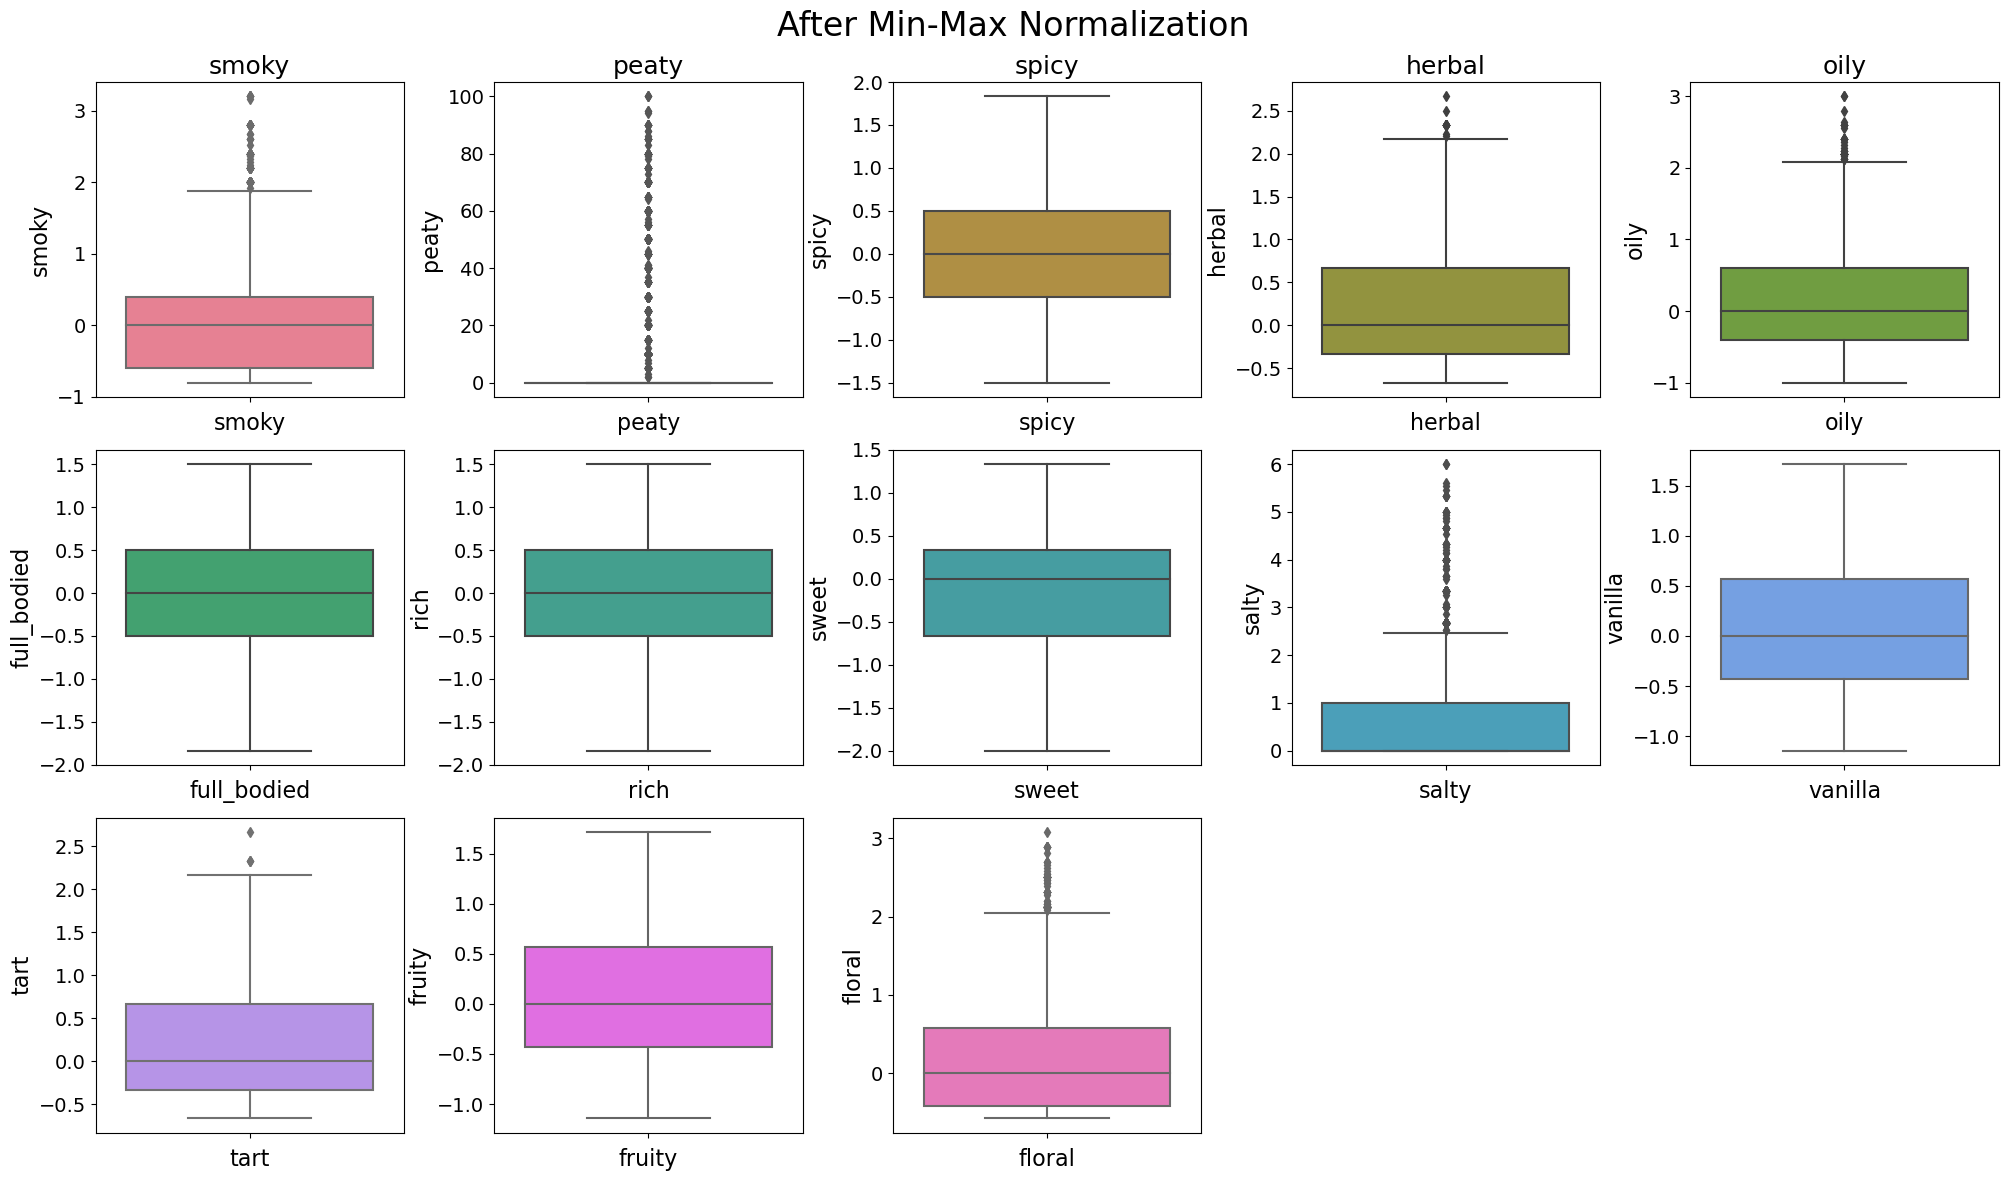

In [78]:
# Define colors for each boxplot
palette = sns.color_palette('husl', n_colors=len(numeric_cols))

# Create subplots
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(20, 12))

# Plot each boxplot
for i, ax in enumerate(axes.flatten()):
    if i >= len(numeric_cols):
        # Remove unused subplot
        ax.remove()
        continue
    sns.boxplot(x='variable', y='value', data=robust_data.melt(value_vars=numeric_cols[i]),
                ax=ax, palette=[palette[i]])
    ax.set_xlabel(numeric_cols[i], fontsize=16)
    ax.set_ylabel(numeric_cols[i], fontsize=16)
    ax.tick_params(labelsize=14)
    ax.set_xticklabels([''], fontsize=14)

# Add titles
fig.suptitle('After Min-Max Normalization', fontsize=24)
for ax, col in zip(axes[0], numeric_cols):
    ax.set_title(col, fontsize=18)

# Adjust layout
plt.tight_layout()
plt.subplots_adjust(top=0.92)

### 3-1. item_features 만들기

In [79]:
item_features = np.zeros((whisky['whisky_id'].nunique(), len(cols)))
for i in range(whisky['whisky_id'].nunique()):
    for j, col_name in enumerate(cols):
        item_features[i, j] = whisky.iloc[i][col_name] if col_name == "cost_rank" else robust_data.iloc[i][col_name]
# item_features = csr_matrix(item_features)

In [87]:
item_features

array([[ 5.        ,  0.4       , 85.        , ...,  0.16666667,
         1.28571429,  1.34615385],
       [ 4.        ,  0.8       , 30.        , ...,  1.        ,
         0.85714286,  0.19230769],
       [ 5.        , -0.2       ,  0.        , ...,  0.16666667,
        -0.14285714, -0.57692308],
       ...,
       [ 3.        ,  2.8       , 10.        , ...,  0.        ,
        -0.28571429, -0.19230769],
       [ 2.        , -0.8       ,  0.        , ..., -0.66666667,
        -1.14285714, -0.57692308],
       [ 1.        ,  0.44      ,  0.        , ..., -0.66666667,
        -0.28571429, -0.19230769]])

In [88]:
item_features = csr_matrix(item_features)

item_features.shape

(3535, 14)

In [89]:
item_df = pd.DataFrame(data=item_features.toarray(), columns=cols)

In [90]:
item_df.to_csv("dataset/robust_item_features.csv", encoding="UTF-8")

### 3-2. user_features 만들기

In [91]:
## user 별로 max rating score 측정
max_rating = rating.groupby("user_id").max(lambda x: max(x))["rating"]

max_rating

user_id
0          9.0
1          9.0
2          9.0
3         10.0
4         10.0
          ... 
119510    10.0
119511     8.0
119512     6.0
119513     2.0
119514     8.0
Name: rating, Length: 119515, dtype: float64

In [92]:
user_feature_ids = []
for i in range(rating["user_id"].nunique()):
    user_feature_ids.append([])
    
    
for i, row in tqdm(rating.iterrows()):
    if int(row["rating"]) == max_rating[int(row["user_id"])]: user_feature_ids[int(row["user_id"])].append(int(row["whisky_id"]))

0it [00:00, ?it/s]

In [96]:
def make_robust_user_features(user_feature_ids, data):
    user_features = []
    for i, info in enumerate(user_feature_ids):
        whisky_id = info[random.randint(0, len(info)-1)]
        print(f"{i} user - {whisky_id}")
        whisky_info = [whisky.iloc[whisky_id]["cost_rank"]] + robust_data.iloc[whisky_id][:].tolist()
        user_features.append(whisky_info)
    return user_features

In [97]:
user_features = make_robust_user_features(user_feature_ids, whisky)

0 user - 811
1 user - 1081
2 user - 805
3 user - 796
4 user - 708
5 user - 0
6 user - 0
7 user - 70
8 user - 0
9 user - 0
10 user - 556
11 user - 597
12 user - 1107
13 user - 1342
14 user - 0
15 user - 0
16 user - 0
17 user - 409
18 user - 37
19 user - 0
20 user - 0
21 user - 659
22 user - 25
23 user - 0
24 user - 0
25 user - 0
26 user - 0
27 user - 0
28 user - 0
29 user - 94
30 user - 0
31 user - 744
32 user - 0
33 user - 1368
34 user - 0
35 user - 0
36 user - 39
37 user - 0
38 user - 294
39 user - 0
40 user - 557
41 user - 0
42 user - 0
43 user - 0
44 user - 584
45 user - 0
46 user - 0
47 user - 37
48 user - 1922
49 user - 37
50 user - 37
51 user - 2886
52 user - 0
53 user - 0
54 user - 1
55 user - 0
56 user - 367
57 user - 1341
58 user - 43
59 user - 0
60 user - 1084
61 user - 0
62 user - 2247
63 user - 606
64 user - 0
65 user - 0
66 user - 0
67 user - 2832
68 user - 0
69 user - 2669
70 user - 0
71 user - 0
72 user - 0
73 user - 37
74 user - 0
75 user - 0
76 user - 795
77 user - 609

1545 user - 115
1546 user - 2651
1547 user - 81
1548 user - 405
1549 user - 36
1550 user - 1
1551 user - 3236
1552 user - 394
1553 user - 1509
1554 user - 1347
1555 user - 802
1556 user - 406
1557 user - 2665
1558 user - 226
1559 user - 1
1560 user - 1
1561 user - 807
1562 user - 11
1563 user - 57
1564 user - 2466
1565 user - 1067
1566 user - 1
1567 user - 1081
1568 user - 218
1569 user - 811
1570 user - 1
1571 user - 92
1572 user - 92
1573 user - 261
1574 user - 1
1575 user - 409
1576 user - 331
1577 user - 331
1578 user - 1
1579 user - 97
1580 user - 392
1581 user - 1
1582 user - 795
1583 user - 357
1584 user - 1368
1585 user - 14
1586 user - 86
1587 user - 1019
1588 user - 253
1589 user - 95
1590 user - 927
1591 user - 1
1592 user - 1
1593 user - 1
1594 user - 1
1595 user - 1081
1596 user - 1340
1597 user - 522
1598 user - 95
1599 user - 1084
1600 user - 1
1601 user - 1
1602 user - 1
1603 user - 1350
1604 user - 2054
1605 user - 2453
1606 user - 2122
1607 user - 1830
1608 user - 1
1

3172 user - 1954
3173 user - 1
3174 user - 1987
3175 user - 1084
3176 user - 1
3177 user - 591
3178 user - 37
3179 user - 811
3180 user - 801
3181 user - 92
3182 user - 1
3183 user - 609
3184 user - 1
3185 user - 2439
3186 user - 386
3187 user - 598
3188 user - 814
3189 user - 2612
3190 user - 590
3191 user - 1543
3192 user - 1
3193 user - 1
3194 user - 2227
3195 user - 593
3196 user - 14
3197 user - 2243
3198 user - 614
3199 user - 609
3200 user - 254
3201 user - 1081
3202 user - 1081
3203 user - 1344
3204 user - 609
3205 user - 37
3206 user - 1952
3207 user - 1056
3208 user - 1
3209 user - 37
3210 user - 89
3211 user - 589
3212 user - 1
3213 user - 257
3214 user - 1
3215 user - 1
3216 user - 1081
3217 user - 1
3218 user - 3023
3219 user - 14
3220 user - 3086
3221 user - 1
3222 user - 1
3223 user - 1046
3224 user - 1
3225 user - 95
3226 user - 609
3227 user - 1070
3228 user - 406
3229 user - 14
3230 user - 2854
3231 user - 411
3232 user - 814
3233 user - 394
3234 user - 609
3235 user 

4720 user - 10
4721 user - 1017
4722 user - 10
4723 user - 1974
4724 user - 1976
4725 user - 10
4726 user - 801
4727 user - 385
4728 user - 37
4729 user - 10
4730 user - 97
4731 user - 2486
4732 user - 10
4733 user - 2460
4734 user - 609
4735 user - 35
4736 user - 10
4737 user - 1101
4738 user - 10
4739 user - 10
4740 user - 1368
4741 user - 817
4742 user - 10
4743 user - 10
4744 user - 10
4745 user - 10
4746 user - 10
4747 user - 10
4748 user - 10
4749 user - 92
4750 user - 995
4751 user - 10
4752 user - 1089
4753 user - 394
4754 user - 10
4755 user - 1103
4756 user - 606
4757 user - 10
4758 user - 401
4759 user - 87
4760 user - 401
4761 user - 10
4762 user - 13
4763 user - 540
4764 user - 10
4765 user - 10
4766 user - 3223
4767 user - 1368
4768 user - 2458
4769 user - 10
4770 user - 94
4771 user - 1368
4772 user - 10
4773 user - 10
4774 user - 2466
4775 user - 1104
4776 user - 2413
4777 user - 10
4778 user - 10
4779 user - 10
4780 user - 1994
4781 user - 1106
4782 user - 789
4783 use

6251 user - 1347
6252 user - 15
6253 user - 15
6254 user - 1368
6255 user - 1078
6256 user - 1107
6257 user - 574
6258 user - 85
6259 user - 15
6260 user - 743
6261 user - 15
6262 user - 15
6263 user - 2606
6264 user - 15
6265 user - 1661
6266 user - 817
6267 user - 15
6268 user - 1932
6269 user - 15
6270 user - 15
6271 user - 1932
6272 user - 15
6273 user - 1368
6274 user - 395
6275 user - 15
6276 user - 609
6277 user - 87
6278 user - 1324
6279 user - 15
6280 user - 15
6281 user - 89
6282 user - 3215
6283 user - 152
6284 user - 15
6285 user - 1078
6286 user - 939
6287 user - 1050
6288 user - 15
6289 user - 3122
6290 user - 1359
6291 user - 15
6292 user - 16
6293 user - 16
6294 user - 817
6295 user - 817
6296 user - 1035
6297 user - 16
6298 user - 470
6299 user - 16
6300 user - 2365
6301 user - 205
6302 user - 1340
6303 user - 1368
6304 user - 16
6305 user - 16
6306 user - 16
6307 user - 16
6308 user - 16
6309 user - 1075
6310 user - 613
6311 user - 1018
6312 user - 340
6313 user - 57


7770 user - 37
7771 user - 2453
7772 user - 1073
7773 user - 803
7774 user - 1680
7775 user - 1081
7776 user - 37
7777 user - 37
7778 user - 37
7779 user - 95
7780 user - 407
7781 user - 37
7782 user - 2854
7783 user - 1093
7784 user - 1663
7785 user - 2848
7786 user - 37
7787 user - 37
7788 user - 1679
7789 user - 37
7790 user - 37
7791 user - 1095
7792 user - 37
7793 user - 37
7794 user - 37
7795 user - 40
7796 user - 37
7797 user - 1987
7798 user - 816
7799 user - 37
7800 user - 397
7801 user - 37
7802 user - 406
7803 user - 37
7804 user - 37
7805 user - 401
7806 user - 1081
7807 user - 37
7808 user - 802
7809 user - 37
7810 user - 606
7811 user - 1107
7812 user - 3223
7813 user - 401
7814 user - 91
7815 user - 37
7816 user - 37
7817 user - 37
7818 user - 407
7819 user - 37
7820 user - 1367
7821 user - 609
7822 user - 37
7823 user - 2678
7824 user - 1626
7825 user - 3248
7826 user - 801
7827 user - 1579
7828 user - 38
7829 user - 1101
7830 user - 1663
7831 user - 38
7832 user - 405


9112 user - 57
9113 user - 57
9114 user - 94
9115 user - 57
9116 user - 57
9117 user - 57
9118 user - 57
9119 user - 57
9120 user - 57
9121 user - 863
9122 user - 2760
9123 user - 816
9124 user - 687
9125 user - 57
9126 user - 593
9127 user - 807
9128 user - 1368
9129 user - 174
9130 user - 1099
9131 user - 423
9132 user - 57
9133 user - 1340
9134 user - 789
9135 user - 1342
9136 user - 717
9137 user - 322
9138 user - 57
9139 user - 789
9140 user - 1341
9141 user - 863
9142 user - 367
9143 user - 1368
9144 user - 57
9145 user - 1342
9146 user - 3223
9147 user - 57
9148 user - 57
9149 user - 2456
9150 user - 94
9151 user - 1619
9152 user - 574
9153 user - 786
9154 user - 609
9155 user - 939
9156 user - 251
9157 user - 57
9158 user - 196
9159 user - 786
9160 user - 2860
9161 user - 57
9162 user - 57
9163 user - 394
9164 user - 739
9165 user - 1341
9166 user - 478
9167 user - 497
9168 user - 367
9169 user - 613
9170 user - 57
9171 user - 57
9172 user - 322
9173 user - 801
9174 user - 1368

10533 user - 811
10534 user - 86
10535 user - 1093
10536 user - 86
10537 user - 2604
10538 user - 88
10539 user - 801
10540 user - 1524
10541 user - 86
10542 user - 1105
10543 user - 226
10544 user - 345
10545 user - 94
10546 user - 86
10547 user - 752
10548 user - 86
10549 user - 86
10550 user - 86
10551 user - 86
10552 user - 139
10553 user - 86
10554 user - 817
10555 user - 995
10556 user - 86
10557 user - 395
10558 user - 2854
10559 user - 2665
10560 user - 573
10561 user - 395
10562 user - 1850
10563 user - 811
10564 user - 86
10565 user - 609
10566 user - 1340
10567 user - 1101
10568 user - 1107
10569 user - 86
10570 user - 88
10571 user - 1922
10572 user - 1102
10573 user - 86
10574 user - 1663
10575 user - 1368
10576 user - 86
10577 user - 86
10578 user - 1368
10579 user - 1359
10580 user - 86
10581 user - 86
10582 user - 510
10583 user - 86
10584 user - 86
10585 user - 947
10586 user - 2350
10587 user - 86
10588 user - 86
10589 user - 86
10590 user - 1102
10591 user - 86
10592

11804 user - 1089
11805 user - 94
11806 user - 92
11807 user - 2672
11808 user - 2349
11809 user - 1976
11810 user - 92
11811 user - 92
11812 user - 141
11813 user - 1860
11814 user - 1107
11815 user - 608
11816 user - 1316
11817 user - 92
11818 user - 591
11819 user - 406
11820 user - 212
11821 user - 406
11822 user - 2247
11823 user - 2245
11824 user - 1663
11825 user - 92
11826 user - 1976
11827 user - 1674
11828 user - 261
11829 user - 94
11830 user - 92
11831 user - 92
11832 user - 2358
11833 user - 1987
11834 user - 708
11835 user - 92
11836 user - 2125
11837 user - 92
11838 user - 129
11839 user - 92
11840 user - 92
11841 user - 141
11842 user - 2476
11843 user - 92
11844 user - 3370
11845 user - 92
11846 user - 1359
11847 user - 1950
11848 user - 92
11849 user - 609
11850 user - 1976
11851 user - 406
11852 user - 367
11853 user - 2483
11854 user - 94
11855 user - 92
11856 user - 92
11857 user - 557
11858 user - 427
11859 user - 789
11860 user - 2092
11861 user - 2291
11862 user

12881 user - 2821
12882 user - 92
12883 user - 1097
12884 user - 695
12885 user - 2473
12886 user - 258
12887 user - 1676
12888 user - 609
12889 user - 1228
12890 user - 2333
12891 user - 2672
12892 user - 92
12893 user - 609
12894 user - 312
12895 user - 581
12896 user - 1335
12897 user - 92
12898 user - 226
12899 user - 814
12900 user - 3012
12901 user - 695
12902 user - 92
12903 user - 92
12904 user - 1663
12905 user - 609
12906 user - 94
12907 user - 2725
12908 user - 92
12909 user - 609
12910 user - 314
12911 user - 584
12912 user - 92
12913 user - 609
12914 user - 1359
12915 user - 3421
12916 user - 92
12917 user - 94
12918 user - 1765
12919 user - 1976
12920 user - 2476
12921 user - 609
12922 user - 405
12923 user - 609
12924 user - 1674
12925 user - 94
12926 user - 609
12927 user - 92
12928 user - 1676
12929 user - 1647
12930 user - 3101
12931 user - 406
12932 user - 609
12933 user - 2302
12934 user - 94
12935 user - 94
12936 user - 1987
12937 user - 2071
12938 user - 991
12939

14457 user - 2854
14458 user - 1989
14459 user - 92
14460 user - 817
14461 user - 609
14462 user - 95
14463 user - 1097
14464 user - 969
14465 user - 1066
14466 user - 411
14467 user - 200
14468 user - 609
14469 user - 94
14470 user - 92
14471 user - 2672
14472 user - 1976
14473 user - 1104
14474 user - 92
14475 user - 604
14476 user - 609
14477 user - 2475
14478 user - 1629
14479 user - 609
14480 user - 92
14481 user - 92
14482 user - 94
14483 user - 1360
14484 user - 796
14485 user - 92
14486 user - 261
14487 user - 92
14488 user - 2412
14489 user - 1084
14490 user - 1097
14491 user - 517
14492 user - 1359
14493 user - 1075
14494 user - 92
14495 user - 92
14496 user - 1634
14497 user - 557
14498 user - 1674
14499 user - 2478
14500 user - 3012
14501 user - 1355
14502 user - 1359
14503 user - 609
14504 user - 246
14505 user - 2412
14506 user - 557
14507 user - 92
14508 user - 249
14509 user - 1983
14510 user - 1097
14511 user - 608
14512 user - 598
14513 user - 92
14514 user - 2241
145

15776 user - 1674
15777 user - 1983
15778 user - 1097
15779 user - 802
15780 user - 92
15781 user - 1663
15782 user - 804
15783 user - 97
15784 user - 2473
15785 user - 1989
15786 user - 2476
15787 user - 1089
15788 user - 593
15789 user - 1079
15790 user - 94
15791 user - 92
15792 user - 92
15793 user - 2476
15794 user - 92
15795 user - 94
15796 user - 1344
15797 user - 405
15798 user - 1987
15799 user - 1976
15800 user - 1987
15801 user - 92
15802 user - 609
15803 user - 403
15804 user - 1097
15805 user - 406
15806 user - 92
15807 user - 92
15808 user - 2242
15809 user - 1676
15810 user - 609
15811 user - 796
15812 user - 1663
15813 user - 609
15814 user - 92
15815 user - 265
15816 user - 609
15817 user - 92
15818 user - 1675
15819 user - 92
15820 user - 609
15821 user - 1341
15822 user - 1989
15823 user - 609
15824 user - 386
15825 user - 1975
15826 user - 92
15827 user - 92
15828 user - 92
15829 user - 92
15830 user - 92
15831 user - 1076
15832 user - 609
15833 user - 609
15834 use

17140 user - 1101
17141 user - 1349
17142 user - 814
17143 user - 94
17144 user - 609
17145 user - 94
17146 user - 723
17147 user - 94
17148 user - 1359
17149 user - 745
17150 user - 94
17151 user - 1102
17152 user - 1031
17153 user - 94
17154 user - 94
17155 user - 609
17156 user - 756
17157 user - 94
17158 user - 3160
17159 user - 468
17160 user - 94
17161 user - 1097
17162 user - 94
17163 user - 2241
17164 user - 94
17165 user - 2854
17166 user - 257
17167 user - 2213
17168 user - 94
17169 user - 609
17170 user - 1342
17171 user - 2854
17172 user - 609
17173 user - 557
17174 user - 609
17175 user - 94
17176 user - 584
17177 user - 2476
17178 user - 1097
17179 user - 94
17180 user - 94
17181 user - 226
17182 user - 94
17183 user - 695
17184 user - 789
17185 user - 1102
17186 user - 578
17187 user - 94
17188 user - 1359
17189 user - 679
17190 user - 363
17191 user - 817
17192 user - 1094
17193 user - 94
17194 user - 94
17195 user - 94
17196 user - 2545
17197 user - 94
17198 user - 161

18517 user - 1087
18518 user - 1107
18519 user - 94
18520 user - 1102
18521 user - 94
18522 user - 609
18523 user - 94
18524 user - 598
18525 user - 1781
18526 user - 1347
18527 user - 94
18528 user - 1097
18529 user - 789
18530 user - 1081
18531 user - 1796
18532 user - 1019
18533 user - 94
18534 user - 1097
18535 user - 94
18536 user - 1102
18537 user - 2473
18538 user - 94
18539 user - 94
18540 user - 1983
18541 user - 94
18542 user - 1097
18543 user - 94
18544 user - 94
18545 user - 1368
18546 user - 2843
18547 user - 2241
18548 user - 1017
18549 user - 94
18550 user - 94
18551 user - 2849
18552 user - 767
18553 user - 1047
18554 user - 2854
18555 user - 557
18556 user - 584
18557 user - 405
18558 user - 2133
18559 user - 1994
18560 user - 94
18561 user - 405
18562 user - 1352
18563 user - 1989
18564 user - 815
18565 user - 1047
18566 user - 1106
18567 user - 3089
18568 user - 94
18569 user - 94
18570 user - 398
18571 user - 1561
18572 user - 992
18573 user - 609
18574 user - 397
1

20135 user - 817
20136 user - 1081
20137 user - 94
20138 user - 94
20139 user - 1105
20140 user - 94
20141 user - 94
20142 user - 94
20143 user - 2187
20144 user - 2670
20145 user - 406
20146 user - 1994
20147 user - 609
20148 user - 94
20149 user - 94
20150 user - 1097
20151 user - 795
20152 user - 1095
20153 user - 94
20154 user - 609
20155 user - 94
20156 user - 406
20157 user - 1097
20158 user - 94
20159 user - 1674
20160 user - 395
20161 user - 94
20162 user - 609
20163 user - 1989
20164 user - 406
20165 user - 1977
20166 user - 94
20167 user - 97
20168 user - 1016
20169 user - 1987
20170 user - 401
20171 user - 609
20172 user - 814
20173 user - 1097
20174 user - 94
20175 user - 1101
20176 user - 1961
20177 user - 817
20178 user - 2611
20179 user - 1663
20180 user - 1097
20181 user - 2236
20182 user - 1983
20183 user - 2472
20184 user - 1350
20185 user - 3286
20186 user - 2854
20187 user - 609
20188 user - 1107
20189 user - 2251
20190 user - 609
20191 user - 1976
20192 user - 593


21580 user - 406
21581 user - 597
21582 user - 95
21583 user - 95
21584 user - 95
21585 user - 95
21586 user - 609
21587 user - 1991
21588 user - 95
21589 user - 598
21590 user - 95
21591 user - 1678
21592 user - 129
21593 user - 1976
21594 user - 95
21595 user - 1783
21596 user - 97
21597 user - 2673
21598 user - 95
21599 user - 609
21600 user - 765
21601 user - 2165
21602 user - 95
21603 user - 95
21604 user - 95
21605 user - 330
21606 user - 543
21607 user - 95
21608 user - 149
21609 user - 95
21610 user - 2854
21611 user - 609
21612 user - 95
21613 user - 2354
21614 user - 1678
21615 user - 596
21616 user - 95
21617 user - 95
21618 user - 1097
21619 user - 386
21620 user - 95
21621 user - 95
21622 user - 796
21623 user - 609
21624 user - 95
21625 user - 752
21626 user - 95
21627 user - 95
21628 user - 609
21629 user - 1650
21630 user - 1342
21631 user - 95
21632 user - 95
21633 user - 95
21634 user - 95
21635 user - 95
21636 user - 803
21637 user - 95
21638 user - 804
21639 user - 

22966 user - 1104
22967 user - 2379
22968 user - 809
22969 user - 1488
22970 user - 97
22971 user - 97
22972 user - 312
22973 user - 1368
22974 user - 1368
22975 user - 141
22976 user - 816
22977 user - 1359
22978 user - 2350
22979 user - 787
22980 user - 1362
22981 user - 1368
22982 user - 1081
22983 user - 1332
22984 user - 1075
22985 user - 396
22986 user - 485
22987 user - 584
22988 user - 322
22989 user - 97
22990 user - 328
22991 user - 97
22992 user - 97
22993 user - 1566
22994 user - 409
22995 user - 1408
22996 user - 2678
22997 user - 97
22998 user - 3223
22999 user - 2660
23000 user - 1107
23001 user - 609
23002 user - 2854
23003 user - 1473
23004 user - 2486
23005 user - 1089
23006 user - 470
23007 user - 1017
23008 user - 97
23009 user - 734
23010 user - 891
23011 user - 2379
23012 user - 817
23013 user - 817
23014 user - 1104
23015 user - 1355
23016 user - 1368
23017 user - 2396
23018 user - 1368
23019 user - 556
23020 user - 602
23021 user - 596
23022 user - 2183
23023 us

24444 user - 584
24445 user - 1680
24446 user - 97
24447 user - 97
24448 user - 814
24449 user - 2853
24450 user - 97
24451 user - 409
24452 user - 1368
24453 user - 1368
24454 user - 97
24455 user - 2487
24456 user - 614
24457 user - 1977
24458 user - 97
24459 user - 97
24460 user - 97
24461 user - 97
24462 user - 1105
24463 user - 2237
24464 user - 1104
24465 user - 1986
24466 user - 1994
24467 user - 1081
24468 user - 2486
24469 user - 1034
24470 user - 1344
24471 user - 409
24472 user - 1103
24473 user - 810
24474 user - 97
24475 user - 614
24476 user - 97
24477 user - 1096
24478 user - 97
24479 user - 1361
24480 user - 1104
24481 user - 1368
24482 user - 2853
24483 user - 1342
24484 user - 2854
24485 user - 97
24486 user - 97
24487 user - 1361
24488 user - 1918
24489 user - 1368
24490 user - 97
24491 user - 97
24492 user - 2670
24493 user - 594
24494 user - 2860
24495 user - 409
24496 user - 97
24497 user - 97
24498 user - 2243
24499 user - 97
24500 user - 97
24501 user - 97
24502

25895 user - 613
25896 user - 438
25897 user - 441
25898 user - 141
25899 user - 141
25900 user - 394
25901 user - 1661
25902 user - 141
25903 user - 141
25904 user - 817
25905 user - 289
25906 user - 1661
25907 user - 3307
25908 user - 1181
25909 user - 596
25910 user - 1578
25911 user - 141
25912 user - 863
25913 user - 394
25914 user - 584
25915 user - 141
25916 user - 2125
25917 user - 574
25918 user - 141
25919 user - 1460
25920 user - 817
25921 user - 367
25922 user - 1393
25923 user - 141
25924 user - 1976
25925 user - 141
25926 user - 789
25927 user - 1104
25928 user - 141
25929 user - 785
25930 user - 2350
25931 user - 141
25932 user - 2665
25933 user - 2093
25934 user - 141
25935 user - 141
25936 user - 240
25937 user - 1206
25938 user - 584
25939 user - 2665
25940 user - 1368
25941 user - 290
25942 user - 789
25943 user - 141
25944 user - 1462
25945 user - 195
25946 user - 789
25947 user - 584
25948 user - 609
25949 user - 246
25950 user - 1075
25951 user - 141
25952 user - 

27209 user - 1340
27210 user - 817
27211 user - 1341
27212 user - 152
27213 user - 1107
27214 user - 152
27215 user - 1102
27216 user - 1107
27217 user - 609
27218 user - 152
27219 user - 817
27220 user - 1103
27221 user - 152
27222 user - 806
27223 user - 152
27224 user - 152
27225 user - 1368
27226 user - 1994
27227 user - 605
27228 user - 817
27229 user - 152
27230 user - 1105
27231 user - 1368
27232 user - 152
27233 user - 1368
27234 user - 1680
27235 user - 816
27236 user - 152
27237 user - 807
27238 user - 804
27239 user - 1362
27240 user - 2848
27241 user - 2665
27242 user - 596
27243 user - 806
27244 user - 3223
27245 user - 593
27246 user - 152
27247 user - 816
27248 user - 397
27249 user - 152
27250 user - 1005
27251 user - 153
27252 user - 804
27253 user - 533
27254 user - 153
27255 user - 153
27256 user - 397
27257 user - 153
27258 user - 609
27259 user - 153
27260 user - 2209
27261 user - 153
27262 user - 2860
27263 user - 153
27264 user - 153
27265 user - 404
27266 user -

28655 user - 191
28656 user - 2799
28657 user - 1947
28658 user - 192
28659 user - 447
28660 user - 868
28661 user - 192
28662 user - 2476
28663 user - 192
28664 user - 192
28665 user - 1669
28666 user - 529
28667 user - 194
28668 user - 194
28669 user - 1366
28670 user - 2476
28671 user - 1992
28672 user - 1341
28673 user - 195
28674 user - 195
28675 user - 195
28676 user - 195
28677 user - 195
28678 user - 195
28679 user - 2122
28680 user - 195
28681 user - 195
28682 user - 195
28683 user - 195
28684 user - 409
28685 user - 470
28686 user - 195
28687 user - 613
28688 user - 195
28689 user - 195
28690 user - 3223
28691 user - 432
28692 user - 408
28693 user - 195
28694 user - 1078
28695 user - 763
28696 user - 195
28697 user - 1368
28698 user - 195
28699 user - 195
28700 user - 910
28701 user - 1609
28702 user - 1609
28703 user - 1661
28704 user - 195
28705 user - 195
28706 user - 2860
28707 user - 2729
28708 user - 195
28709 user - 1106
28710 user - 195
28711 user - 584
28712 user - 

30025 user - 240
30026 user - 1344
30027 user - 1368
30028 user - 242
30029 user - 1017
30030 user - 735
30031 user - 560
30032 user - 1206
30033 user - 240
30034 user - 2860
30035 user - 574
30036 user - 1994
30037 user - 597
30038 user - 242
30039 user - 1644
30040 user - 1994
30041 user - 1104
30042 user - 240
30043 user - 817
30044 user - 240
30045 user - 3029
30046 user - 3029
30047 user - 240
30048 user - 242
30049 user - 355
30050 user - 345
30051 user - 1090
30052 user - 1075
30053 user - 602
30054 user - 2673
30055 user - 1249
30056 user - 240
30057 user - 2656
30058 user - 1051
30059 user - 789
30060 user - 1105
30061 user - 2241
30062 user - 588
30063 user - 2969
30064 user - 408
30065 user - 242
30066 user - 2786
30067 user - 240
30068 user - 409
30069 user - 584
30070 user - 242
30071 user - 1680
30072 user - 1641
30073 user - 739
30074 user - 2678
30075 user - 240
30076 user - 1036
30077 user - 1340
30078 user - 240
30079 user - 1102
30080 user - 388
30081 user - 2673
300

31515 user - 807
31516 user - 256
31517 user - 256
31518 user - 2651
31519 user - 1097
31520 user - 256
31521 user - 256
31522 user - 256
31523 user - 2250
31524 user - 2651
31525 user - 574
31526 user - 717
31527 user - 256
31528 user - 256
31529 user - 256
31530 user - 256
31531 user - 256
31532 user - 256
31533 user - 256
31534 user - 1368
31535 user - 256
31536 user - 1099
31537 user - 256
31538 user - 589
31539 user - 1019
31540 user - 256
31541 user - 256
31542 user - 256
31543 user - 256
31544 user - 578
31545 user - 256
31546 user - 915
31547 user - 256
31548 user - 1068
31549 user - 256
31550 user - 256
31551 user - 256
31552 user - 597
31553 user - 473
31554 user - 256
31555 user - 256
31556 user - 1657
31557 user - 256
31558 user - 256
31559 user - 256
31560 user - 609
31561 user - 1348
31562 user - 1863
31563 user - 597
31564 user - 256
31565 user - 256
31566 user - 1657
31567 user - 256
31568 user - 2651
31569 user - 1301
31570 user - 256
31571 user - 256
31572 user - 256


32820 user - 1368
32821 user - 295
32822 user - 295
32823 user - 295
32824 user - 295
32825 user - 295
32826 user - 295
32827 user - 295
32828 user - 295
32829 user - 3223
32830 user - 574
32831 user - 296
32832 user - 296
32833 user - 1341
32834 user - 2230
32835 user - 609
32836 user - 296
32837 user - 1451
32838 user - 296
32839 user - 326
32840 user - 296
32841 user - 2665
32842 user - 296
32843 user - 297
32844 user - 298
32845 user - 470
32846 user - 409
32847 user - 394
32848 user - 1368
32849 user - 298
32850 user - 2311
32851 user - 432
32852 user - 394
32853 user - 1273
32854 user - 807
32855 user - 298
32856 user - 1341
32857 user - 1171
32858 user - 298
32859 user - 1075
32860 user - 298
32861 user - 602
32862 user - 1203
32863 user - 298
32864 user - 298
32865 user - 1368
32866 user - 801
32867 user - 298
32868 user - 1342
32869 user - 298
32870 user - 298
32871 user - 298
32872 user - 298
32873 user - 298
32874 user - 298
32875 user - 298
32876 user - 298
32877 user - 178

34212 user - 345
34213 user - 345
34214 user - 345
34215 user - 807
34216 user - 345
34217 user - 3029
34218 user - 345
34219 user - 1090
34220 user - 605
34221 user - 345
34222 user - 345
34223 user - 345
34224 user - 1368
34225 user - 345
34226 user - 2362
34227 user - 645
34228 user - 981
34229 user - 545
34230 user - 345
34231 user - 345
34232 user - 807
34233 user - 1104
34234 user - 591
34235 user - 345
34236 user - 345
34237 user - 584
34238 user - 345
34239 user - 1407
34240 user - 2860
34241 user - 345
34242 user - 345
34243 user - 345
34244 user - 2906
34245 user - 345
34246 user - 345
34247 user - 596
34248 user - 584
34249 user - 345
34250 user - 345
34251 user - 609
34252 user - 1368
34253 user - 409
34254 user - 3209
34255 user - 345
34256 user - 345
34257 user - 1752
34258 user - 345
34259 user - 2108
34260 user - 345
34261 user - 584
34262 user - 2379
34263 user - 1075
34264 user - 345
34265 user - 1075
34266 user - 661
34267 user - 2845
34268 user - 345
34269 user - 66

35701 user - 371
35702 user - 1922
35703 user - 1909
35704 user - 2889
35705 user - 373
35706 user - 1171
35707 user - 374
35708 user - 695
35709 user - 374
35710 user - 374
35711 user - 374
35712 user - 406
35713 user - 374
35714 user - 374
35715 user - 1066
35716 user - 609
35717 user - 1347
35718 user - 374
35719 user - 615
35720 user - 374
35721 user - 1043
35722 user - 1359
35723 user - 374
35724 user - 1614
35725 user - 739
35726 user - 377
35727 user - 1104
35728 user - 1035
35729 user - 377
35730 user - 939
35731 user - 862
35732 user - 584
35733 user - 377
35734 user - 1987
35735 user - 377
35736 user - 2860
35737 user - 1075
35738 user - 377
35739 user - 377
35740 user - 468
35741 user - 3307
35742 user - 377
35743 user - 377
35744 user - 1347
35745 user - 377
35746 user - 807
35747 user - 377
35748 user - 2675
35749 user - 377
35750 user - 956
35751 user - 377
35752 user - 377
35753 user - 377
35754 user - 789
35755 user - 377
35756 user - 377
35757 user - 1952
35758 user - 

37102 user - 574
37103 user - 786
37104 user - 394
37105 user - 394
37106 user - 2390
37107 user - 1347
37108 user - 394
37109 user - 394
37110 user - 1661
37111 user - 394
37112 user - 1104
37113 user - 394
37114 user - 1994
37115 user - 394
37116 user - 593
37117 user - 602
37118 user - 1078
37119 user - 394
37120 user - 394
37121 user - 394
37122 user - 3122
37123 user - 1994
37124 user - 394
37125 user - 817
37126 user - 584
37127 user - 1104
37128 user - 1367
37129 user - 394
37130 user - 394
37131 user - 394
37132 user - 394
37133 user - 394
37134 user - 394
37135 user - 1869
37136 user - 602
37137 user - 1661
37138 user - 2860
37139 user - 574
37140 user - 394
37141 user - 2236
37142 user - 1661
37143 user - 394
37144 user - 1644
37145 user - 394
37146 user - 394
37147 user - 806
37148 user - 394
37149 user - 394
37150 user - 394
37151 user - 394
37152 user - 394
37153 user - 394
37154 user - 981
37155 user - 1091
37156 user - 394
37157 user - 1825
37158 user - 394
37159 user - 

38586 user - 397
38587 user - 606
38588 user - 397
38589 user - 397
38590 user - 1107
38591 user - 1672
38592 user - 401
38593 user - 2253
38594 user - 1368
38595 user - 2993
38596 user - 397
38597 user - 1105
38598 user - 609
38599 user - 1368
38600 user - 1632
38601 user - 397
38602 user - 1081
38603 user - 1994
38604 user - 1652
38605 user - 397
38606 user - 1983
38607 user - 575
38608 user - 609
38609 user - 397
38610 user - 1359
38611 user - 1084
38612 user - 406
38613 user - 408
38614 user - 1097
38615 user - 1081
38616 user - 1327
38617 user - 397
38618 user - 2665
38619 user - 397
38620 user - 397
38621 user - 804
38622 user - 397
38623 user - 397
38624 user - 397
38625 user - 1663
38626 user - 1089
38627 user - 1082
38628 user - 1368
38629 user - 397
38630 user - 397
38631 user - 805
38632 user - 614
38633 user - 397
38634 user - 2665
38635 user - 397
38636 user - 1983
38637 user - 397
38638 user - 1352
38639 user - 397
38640 user - 1350
38641 user - 397
38642 user - 1974
3864

40130 user - 804
40131 user - 1097
40132 user - 406
40133 user - 406
40134 user - 406
40135 user - 406
40136 user - 2437
40137 user - 2950
40138 user - 406
40139 user - 406
40140 user - 406
40141 user - 406
40142 user - 406
40143 user - 406
40144 user - 1672
40145 user - 557
40146 user - 609
40147 user - 609
40148 user - 2603
40149 user - 406
40150 user - 609
40151 user - 2840
40152 user - 1097
40153 user - 609
40154 user - 597
40155 user - 406
40156 user - 406
40157 user - 406
40158 user - 406
40159 user - 814
40160 user - 406
40161 user - 406
40162 user - 3223
40163 user - 1101
40164 user - 2470
40165 user - 406
40166 user - 2658
40167 user - 406
40168 user - 406
40169 user - 406
40170 user - 406
40171 user - 953
40172 user - 406
40173 user - 2641
40174 user - 406
40175 user - 1982
40176 user - 1097
40177 user - 1370
40178 user - 406
40179 user - 580
40180 user - 2673
40181 user - 1319
40182 user - 406
40183 user - 2476
40184 user - 406
40185 user - 609
40186 user - 406
40187 user - 

41819 user - 409
41820 user - 1099
41821 user - 409
41822 user - 470
41823 user - 1355
41824 user - 409
41825 user - 807
41826 user - 409
41827 user - 886
41828 user - 409
41829 user - 2379
41830 user - 409
41831 user - 2613
41832 user - 602
41833 user - 1368
41834 user - 1078
41835 user - 817
41836 user - 1368
41837 user - 1075
41838 user - 409
41839 user - 3006
41840 user - 591
41841 user - 1869
41842 user - 1075
41843 user - 1105
41844 user - 1368
41845 user - 1078
41846 user - 468
41847 user - 409
41848 user - 556
41849 user - 1368
41850 user - 807
41851 user - 409
41852 user - 1075
41853 user - 409
41854 user - 409
41855 user - 409
41856 user - 1090
41857 user - 789
41858 user - 1085
41859 user - 1368
41860 user - 409
41861 user - 1658
41862 user - 786
41863 user - 409
41864 user - 817
41865 user - 1075
41866 user - 602
41867 user - 409
41868 user - 409
41869 user - 409
41870 user - 2453
41871 user - 1075
41872 user - 409
41873 user - 485
41874 user - 409
41875 user - 409
41876 us

43307 user - 450
43308 user - 1976
43309 user - 609
43310 user - 920
43311 user - 801
43312 user - 1860
43313 user - 801
43314 user - 2652
43315 user - 2665
43316 user - 1081
43317 user - 1359
43318 user - 450
43319 user - 609
43320 user - 1066
43321 user - 450
43322 user - 1107
43323 user - 1342
43324 user - 2860
43325 user - 450
43326 user - 2762
43327 user - 2857
43328 user - 450
43329 user - 450
43330 user - 450
43331 user - 1359
43332 user - 801
43333 user - 1171
43334 user - 1605
43335 user - 450
43336 user - 2519
43337 user - 450
43338 user - 450
43339 user - 2738
43340 user - 1107
43341 user - 1081
43342 user - 450
43343 user - 2453
43344 user - 450
43345 user - 1368
43346 user - 1322
43347 user - 2240
43348 user - 2232
43349 user - 450
43350 user - 1860
43351 user - 450
43352 user - 451
43353 user - 451
43354 user - 451
43355 user - 1368
43356 user - 451
43357 user - 1368
43358 user - 451
43359 user - 451
43360 user - 451
43361 user - 451
43362 user - 451
43363 user - 451
4336

44831 user - 3122
44832 user - 530
44833 user - 1094
44834 user - 2233
44835 user - 530
44836 user - 1349
44837 user - 530
44838 user - 1976
44839 user - 1976
44840 user - 2464
44841 user - 530
44842 user - 530
44843 user - 530
44844 user - 530
44845 user - 532
44846 user - 533
44847 user - 1740
44848 user - 1322
44849 user - 533
44850 user - 533
44851 user - 533
44852 user - 2665
44853 user - 533
44854 user - 752
44855 user - 1034
44856 user - 1922
44857 user - 533
44858 user - 533
44859 user - 534
44860 user - 534
44861 user - 534
44862 user - 534
44863 user - 534
44864 user - 1666
44865 user - 1019
44866 user - 534
44867 user - 534
44868 user - 534
44869 user - 536
44870 user - 991
44871 user - 536
44872 user - 1626
44873 user - 2254
44874 user - 1763
44875 user - 538
44876 user - 599
44877 user - 2350
44878 user - 539
44879 user - 539
44880 user - 540
44881 user - 540
44882 user - 1548
44883 user - 540
44884 user - 540
44885 user - 1081
44886 user - 2600
44887 user - 1368
44888 use

46247 user - 557
46248 user - 557
46249 user - 557
46250 user - 557
46251 user - 557
46252 user - 2620
46253 user - 1365
46254 user - 1663
46255 user - 609
46256 user - 1976
46257 user - 557
46258 user - 557
46259 user - 557
46260 user - 557
46261 user - 557
46262 user - 1663
46263 user - 557
46264 user - 557
46265 user - 557
46266 user - 557
46267 user - 557
46268 user - 815
46269 user - 1107
46270 user - 732
46271 user - 557
46272 user - 557
46273 user - 1085
46274 user - 557
46275 user - 557
46276 user - 557
46277 user - 557
46278 user - 2140
46279 user - 557
46280 user - 557
46281 user - 801
46282 user - 557
46283 user - 557
46284 user - 587
46285 user - 557
46286 user - 557
46287 user - 1668
46288 user - 1989
46289 user - 557
46290 user - 557
46291 user - 557
46292 user - 557
46293 user - 2854
46294 user - 557
46295 user - 557
46296 user - 2658
46297 user - 2412
46298 user - 814
46299 user - 1624
46300 user - 1976
46301 user - 1012
46302 user - 557
46303 user - 557
46304 user - 55

47685 user - 584
47686 user - 584
47687 user - 2888
47688 user - 817
47689 user - 584
47690 user - 2466
47691 user - 584
47692 user - 584
47693 user - 2466
47694 user - 1206
47695 user - 584
47696 user - 2350
47697 user - 2486
47698 user - 584
47699 user - 695
47700 user - 3052
47701 user - 584
47702 user - 1347
47703 user - 584
47704 user - 852
47705 user - 584
47706 user - 1448
47707 user - 584
47708 user - 735
47709 user - 584
47710 user - 584
47711 user - 584
47712 user - 609
47713 user - 1669
47714 user - 755
47715 user - 1763
47716 user - 2665
47717 user - 1680
47718 user - 584
47719 user - 602
47720 user - 584
47721 user - 584
47722 user - 2298
47723 user - 584
47724 user - 1107
47725 user - 1104
47726 user - 2379
47727 user - 584
47728 user - 584
47729 user - 584
47730 user - 584
47731 user - 584
47732 user - 584
47733 user - 584
47734 user - 584
47735 user - 2661
47736 user - 2745
47737 user - 584
47738 user - 2350
47739 user - 584
47740 user - 584
47741 user - 817
47742 user 

49090 user - 1032
49091 user - 810
49092 user - 817
49093 user - 584
49094 user - 2241
49095 user - 1922
49096 user - 742
49097 user - 2466
49098 user - 584
49099 user - 584
49100 user - 1368
49101 user - 584
49102 user - 1095
49103 user - 2247
49104 user - 2604
49105 user - 584
49106 user - 723
49107 user - 584
49108 user - 1075
49109 user - 609
49110 user - 760
49111 user - 3292
49112 user - 584
49113 user - 2606
49114 user - 992
49115 user - 593
49116 user - 584
49117 user - 584
49118 user - 2473
49119 user - 584
49120 user - 584
49121 user - 2486
49122 user - 817
49123 user - 584
49124 user - 584
49125 user - 2486
49126 user - 584
49127 user - 1994
49128 user - 2486
49129 user - 1961
49130 user - 3332
49131 user - 1669
49132 user - 584
49133 user - 596
49134 user - 1035
49135 user - 2621
49136 user - 2486
49137 user - 2661
49138 user - 2486
49139 user - 787
49140 user - 2617
49141 user - 1368
49142 user - 585
49143 user - 3223
49144 user - 584
49145 user - 1078
49146 user - 584
491

50642 user - 596
50643 user - 596
50644 user - 2350
50645 user - 596
50646 user - 817
50647 user - 816
50648 user - 1457
50649 user - 817
50650 user - 2555
50651 user - 1361
50652 user - 817
50653 user - 596
50654 user - 596
50655 user - 3257
50656 user - 1454
50657 user - 1104
50658 user - 1090
50659 user - 2840
50660 user - 2453
50661 user - 596
50662 user - 596
50663 user - 1098
50664 user - 596
50665 user - 596
50666 user - 596
50667 user - 596
50668 user - 596
50669 user - 596
50670 user - 3122
50671 user - 1034
50672 user - 2379
50673 user - 1759
50674 user - 670
50675 user - 596
50676 user - 3307
50677 user - 3307
50678 user - 596
50679 user - 596
50680 user - 1035
50681 user - 596
50682 user - 596
50683 user - 596
50684 user - 596
50685 user - 596
50686 user - 1075
50687 user - 596
50688 user - 602
50689 user - 596
50690 user - 1084
50691 user - 2233
50692 user - 596
50693 user - 596
50694 user - 596
50695 user - 596
50696 user - 1368
50697 user - 2350
50698 user - 1104
50699 u

52087 user - 602
52088 user - 1658
52089 user - 1460
52090 user - 602
52091 user - 1448
52092 user - 814
52093 user - 602
52094 user - 602
52095 user - 602
52096 user - 602
52097 user - 1368
52098 user - 2860
52099 user - 1658
52100 user - 2350
52101 user - 602
52102 user - 602
52103 user - 602
52104 user - 602
52105 user - 1075
52106 user - 816
52107 user - 602
52108 user - 602
52109 user - 2350
52110 user - 602
52111 user - 2552
52112 user - 602
52113 user - 602
52114 user - 817
52115 user - 1368
52116 user - 602
52117 user - 602
52118 user - 602
52119 user - 602
52120 user - 602
52121 user - 602
52122 user - 657
52123 user - 602
52124 user - 602
52125 user - 789
52126 user - 602
52127 user - 602
52128 user - 939
52129 user - 1090
52130 user - 1368
52131 user - 648
52132 user - 602
52133 user - 2350
52134 user - 1368
52135 user - 1368
52136 user - 602
52137 user - 2222
52138 user - 602
52139 user - 602
52140 user - 1105
52141 user - 602
52142 user - 602
52143 user - 602
52144 user - 

53588 user - 608
53589 user - 1097
53590 user - 1634
53591 user - 608
53592 user - 2236
53593 user - 608
53594 user - 609
53595 user - 612
53596 user - 608
53597 user - 609
53598 user - 608
53599 user - 608
53600 user - 2476
53601 user - 2477
53602 user - 608
53603 user - 1640
53604 user - 1954
53605 user - 608
53606 user - 609
53607 user - 609
53608 user - 2651
53609 user - 608
53610 user - 608
53611 user - 811
53612 user - 2251
53613 user - 608
53614 user - 1097
53615 user - 1961
53616 user - 608
53617 user - 1097
53618 user - 2672
53619 user - 608
53620 user - 1099
53621 user - 608
53622 user - 2476
53623 user - 608
53624 user - 2854
53625 user - 609
53626 user - 1663
53627 user - 608
53628 user - 608
53629 user - 1102
53630 user - 608
53631 user - 1983
53632 user - 608
53633 user - 2432
53634 user - 804
53635 user - 608
53636 user - 1087
53637 user - 608
53638 user - 800
53639 user - 608
53640 user - 2243
53641 user - 3117
53642 user - 610
53643 user - 1961
53644 user - 2451
53645 

55119 user - 811
55120 user - 609
55121 user - 609
55122 user - 609
55123 user - 609
55124 user - 2241
55125 user - 609
55126 user - 609
55127 user - 609
55128 user - 609
55129 user - 609
55130 user - 609
55131 user - 609
55132 user - 609
55133 user - 1368
55134 user - 609
55135 user - 2854
55136 user - 2173
55137 user - 1655
55138 user - 1971
55139 user - 2117
55140 user - 609
55141 user - 609
55142 user - 1081
55143 user - 609
55144 user - 609
55145 user - 609
55146 user - 609
55147 user - 609
55148 user - 609
55149 user - 609
55150 user - 609
55151 user - 1102
55152 user - 609
55153 user - 609
55154 user - 609
55155 user - 609
55156 user - 609
55157 user - 951
55158 user - 811
55159 user - 609
55160 user - 609
55161 user - 609
55162 user - 609
55163 user - 2242
55164 user - 609
55165 user - 1095
55166 user - 2473
55167 user - 609
55168 user - 609
55169 user - 1361
55170 user - 609
55171 user - 3307
55172 user - 609
55173 user - 609
55174 user - 609
55175 user - 609
55176 user - 609


56762 user - 1665
56763 user - 2476
56764 user - 1107
56765 user - 609
56766 user - 1366
56767 user - 1101
56768 user - 609
56769 user - 1080
56770 user - 2233
56771 user - 609
56772 user - 609
56773 user - 609
56774 user - 2204
56775 user - 609
56776 user - 609
56777 user - 1075
56778 user - 609
56779 user - 609
56780 user - 609
56781 user - 609
56782 user - 609
56783 user - 609
56784 user - 609
56785 user - 609
56786 user - 2854
56787 user - 1359
56788 user - 610
56789 user - 1082
56790 user - 610
56791 user - 610
56792 user - 765
56793 user - 610
56794 user - 2671
56795 user - 610
56796 user - 610
56797 user - 610
56798 user - 1596
56799 user - 611
56800 user - 2239
56801 user - 1581
56802 user - 611
56803 user - 611
56804 user - 611
56805 user - 898
56806 user - 817
56807 user - 611
56808 user - 611
56809 user - 611
56810 user - 611
56811 user - 2643
56812 user - 1989
56813 user - 744
56814 user - 2253
56815 user - 611
56816 user - 1989
56817 user - 611
56818 user - 611
56819 user 

58399 user - 629
58400 user - 629
58401 user - 630
58402 user - 630
58403 user - 630
58404 user - 630
58405 user - 630
58406 user - 630
58407 user - 630
58408 user - 900
58409 user - 630
58410 user - 1400
58411 user - 632
58412 user - 1946
58413 user - 865
58414 user - 632
58415 user - 1342
58416 user - 633
58417 user - 1409
58418 user - 635
58419 user - 635
58420 user - 635
58421 user - 635
58422 user - 635
58423 user - 635
58424 user - 635
58425 user - 635
58426 user - 2661
58427 user - 1448
58428 user - 635
58429 user - 635
58430 user - 635
58431 user - 636
58432 user - 1341
58433 user - 637
58434 user - 637
58435 user - 637
58436 user - 638
58437 user - 2335
58438 user - 638
58439 user - 1368
58440 user - 638
58441 user - 639
58442 user - 639
58443 user - 639
58444 user - 1313
58445 user - 639
58446 user - 639
58447 user - 1068
58448 user - 640
58449 user - 640
58450 user - 641
58451 user - 641
58452 user - 641
58453 user - 891
58454 user - 1661
58455 user - 642
58456 user - 642
58

60037 user - 745
60038 user - 3214
60039 user - 811
60040 user - 745
60041 user - 1095
60042 user - 2652
60043 user - 745
60044 user - 2251
60045 user - 745
60046 user - 1672
60047 user - 745
60048 user - 2962
60049 user - 745
60050 user - 787
60051 user - 1008
60052 user - 2462
60053 user - 955
60054 user - 3051
60055 user - 1954
60056 user - 1974
60057 user - 745
60058 user - 746
60059 user - 807
60060 user - 746
60061 user - 746
60062 user - 746
60063 user - 746
60064 user - 3006
60065 user - 758
60066 user - 1368
60067 user - 3025
60068 user - 747
60069 user - 747
60070 user - 747
60071 user - 2603
60072 user - 751
60073 user - 1987
60074 user - 2673
60075 user - 751
60076 user - 751
60077 user - 1271
60078 user - 752
60079 user - 2860
60080 user - 2052
60081 user - 752
60082 user - 752
60083 user - 752
60084 user - 1095
60085 user - 752
60086 user - 752
60087 user - 2860
60088 user - 2473
60089 user - 752
60090 user - 2604
60091 user - 2350
60092 user - 2093
60093 user - 1976
6009

61549 user - 2108
61550 user - 789
61551 user - 2453
61552 user - 789
61553 user - 789
61554 user - 789
61555 user - 789
61556 user - 1200
61557 user - 789
61558 user - 789
61559 user - 789
61560 user - 2332
61561 user - 1609
61562 user - 789
61563 user - 789
61564 user - 2379
61565 user - 789
61566 user - 817
61567 user - 1075
61568 user - 1216
61569 user - 789
61570 user - 3006
61571 user - 789
61572 user - 789
61573 user - 1368
61574 user - 816
61575 user - 789
61576 user - 1368
61577 user - 2201
61578 user - 2524
61579 user - 1367
61580 user - 789
61581 user - 2974
61582 user - 2888
61583 user - 789
61584 user - 809
61585 user - 2234
61586 user - 1368
61587 user - 1273
61588 user - 1017
61589 user - 789
61590 user - 1368
61591 user - 789
61592 user - 789
61593 user - 1680
61594 user - 789
61595 user - 2379
61596 user - 789
61597 user - 789
61598 user - 2888
61599 user - 789
61600 user - 789
61601 user - 2234
61602 user - 1823
61603 user - 1075
61604 user - 789
61605 user - 789
6160

63478 user - 1273
63479 user - 1860
63480 user - 804
63481 user - 804
63482 user - 1977
63483 user - 804
63484 user - 804
63485 user - 804
63486 user - 1359
63487 user - 804
63488 user - 1320
63489 user - 1989
63490 user - 2857
63491 user - 804
63492 user - 804
63493 user - 804
63494 user - 1663
63495 user - 804
63496 user - 2242
63497 user - 804
63498 user - 804
63499 user - 1097
63500 user - 804
63501 user - 804
63502 user - 804
63503 user - 1087
63504 user - 1674
63505 user - 804
63506 user - 804
63507 user - 1095
63508 user - 2612
63509 user - 804
63510 user - 2250
63511 user - 804
63512 user - 804
63513 user - 2857
63514 user - 2464
63515 user - 804
63516 user - 804
63517 user - 2156
63518 user - 804
63519 user - 804
63520 user - 804
63521 user - 2233
63522 user - 2854
63523 user - 804
63524 user - 1200
63525 user - 2354
63526 user - 2241
63527 user - 804
63528 user - 1663
63529 user - 804
63530 user - 2854
63531 user - 3303
63532 user - 804
63533 user - 804
63534 user - 804
63535

65010 user - 1075
65011 user - 2652
65012 user - 817
65013 user - 1368
65014 user - 807
65015 user - 807
65016 user - 2860
65017 user - 2453
65018 user - 1106
65019 user - 807
65020 user - 807
65021 user - 1226
65022 user - 807
65023 user - 1661
65024 user - 807
65025 user - 807
65026 user - 807
65027 user - 807
65028 user - 807
65029 user - 807
65030 user - 807
65031 user - 807
65032 user - 1341
65033 user - 3321
65034 user - 807
65035 user - 1976
65036 user - 807
65037 user - 807
65038 user - 3288
65039 user - 807
65040 user - 807
65041 user - 807
65042 user - 2379
65043 user - 807
65044 user - 1678
65045 user - 807
65046 user - 817
65047 user - 1760
65048 user - 1340
65049 user - 807
65050 user - 807
65051 user - 807
65052 user - 1107
65053 user - 1368
65054 user - 807
65055 user - 807
65056 user - 807
65057 user - 2085
65058 user - 807
65059 user - 807
65060 user - 807
65061 user - 1986
65062 user - 997
65063 user - 817
65064 user - 1090
65065 user - 807
65066 user - 1053
65067 use

66556 user - 1104
66557 user - 810
66558 user - 2483
66559 user - 810
66560 user - 810
66561 user - 1366
66562 user - 3349
66563 user - 1994
66564 user - 810
66565 user - 810
66566 user - 1994
66567 user - 810
66568 user - 3222
66569 user - 1823
66570 user - 2468
66571 user - 2254
66572 user - 810
66573 user - 2486
66574 user - 810
66575 user - 2853
66576 user - 2227
66577 user - 2254
66578 user - 810
66579 user - 1994
66580 user - 810
66581 user - 810
66582 user - 1070
66583 user - 2242
66584 user - 3445
66585 user - 810
66586 user - 810
66587 user - 810
66588 user - 2484
66589 user - 810
66590 user - 1069
66591 user - 810
66592 user - 2665
66593 user - 2254
66594 user - 810
66595 user - 810
66596 user - 1368
66597 user - 1344
66598 user - 810
66599 user - 1107
66600 user - 3223
66601 user - 810
66602 user - 2234
66603 user - 810
66604 user - 810
66605 user - 810
66606 user - 1086
66607 user - 817
66608 user - 1674
66609 user - 810
66610 user - 810
66611 user - 2845
66612 user - 810
6

67976 user - 815
67977 user - 815
67978 user - 815
67979 user - 815
67980 user - 1802
67981 user - 815
67982 user - 815
67983 user - 2441
67984 user - 1046
67985 user - 2359
67986 user - 2400
67987 user - 1359
67988 user - 815
67989 user - 815
67990 user - 815
67991 user - 815
67992 user - 815
67993 user - 815
67994 user - 2476
67995 user - 1626
67996 user - 815
67997 user - 1656
67998 user - 1976
67999 user - 815
68000 user - 815
68001 user - 815
68002 user - 815
68003 user - 815
68004 user - 2476
68005 user - 815
68006 user - 1087
68007 user - 2666
68008 user - 815
68009 user - 1095
68010 user - 1638
68011 user - 815
68012 user - 1104
68013 user - 2475
68014 user - 2243
68015 user - 1107
68016 user - 815
68017 user - 1107
68018 user - 1561
68019 user - 815
68020 user - 815
68021 user - 815
68022 user - 815
68023 user - 1987
68024 user - 2854
68025 user - 957
68026 user - 1287
68027 user - 815
68028 user - 815
68029 user - 1102
68030 user - 1987
68031 user - 815
68032 user - 815
68033

69505 user - 3349
69506 user - 817
69507 user - 1104
69508 user - 1823
69509 user - 817
69510 user - 1368
69511 user - 1078
69512 user - 817
69513 user - 817
69514 user - 817
69515 user - 817
69516 user - 1075
69517 user - 817
69518 user - 817
69519 user - 1368
69520 user - 2860
69521 user - 1368
69522 user - 817
69523 user - 3197
69524 user - 817
69525 user - 3307
69526 user - 1340
69527 user - 817
69528 user - 817
69529 user - 817
69530 user - 817
69531 user - 817
69532 user - 1368
69533 user - 817
69534 user - 1523
69535 user - 817
69536 user - 817
69537 user - 1368
69538 user - 817
69539 user - 1075
69540 user - 909
69541 user - 2860
69542 user - 1104
69543 user - 817
69544 user - 2848
69545 user - 817
69546 user - 817
69547 user - 817
69548 user - 1568
69549 user - 2108
69550 user - 1367
69551 user - 817
69552 user - 817
69553 user - 817
69554 user - 3534
69555 user - 817
69556 user - 1368
69557 user - 817
69558 user - 817
69559 user - 817
69560 user - 817
69561 user - 817
69562 u

70962 user - 1249
70963 user - 900
70964 user - 1901
70965 user - 900
70966 user - 1034
70967 user - 2665
70968 user - 1869
70969 user - 1368
70970 user - 900
70971 user - 900
70972 user - 900
70973 user - 1668
70974 user - 900
70975 user - 900
70976 user - 900
70977 user - 1035
70978 user - 1107
70979 user - 3223
70980 user - 1619
70981 user - 2254
70982 user - 2291
70983 user - 2888
70984 user - 2379
70985 user - 900
70986 user - 1047
70987 user - 900
70988 user - 900
70989 user - 2745
70990 user - 900
70991 user - 900
70992 user - 1206
70993 user - 900
70994 user - 900
70995 user - 1075
70996 user - 2486
70997 user - 900
70998 user - 1104
70999 user - 2453
71000 user - 2486
71001 user - 900
71002 user - 900
71003 user - 1206
71004 user - 900
71005 user - 900
71006 user - 2529
71007 user - 900
71008 user - 900
71009 user - 900
71010 user - 2234
71011 user - 900
71012 user - 900
71013 user - 900
71014 user - 900
71015 user - 2453
71016 user - 1669
71017 user - 1974
71018 user - 900
71

72738 user - 1022
72739 user - 1022
72740 user - 1102
72741 user - 1051
72742 user - 1022
72743 user - 2796
72744 user - 1022
72745 user - 1022
72746 user - 1022
72747 user - 1022
72748 user - 1022
72749 user - 2244
72750 user - 2678
72751 user - 2638
72752 user - 2437
72753 user - 2846
72754 user - 2453
72755 user - 1022
72756 user - 1994
72757 user - 1370
72758 user - 3421
72759 user - 3282
72760 user - 1023
72761 user - 1023
72762 user - 1023
72763 user - 1023
72764 user - 1023
72765 user - 1023
72766 user - 2651
72767 user - 1023
72768 user - 1024
72769 user - 3030
72770 user - 1025
72771 user - 1025
72772 user - 2610
72773 user - 1081
72774 user - 1026
72775 user - 1027
72776 user - 3317
72777 user - 1027
72778 user - 1027
72779 user - 1027
72780 user - 1028
72781 user - 1028
72782 user - 1028
72783 user - 1028
72784 user - 1075
72785 user - 1028
72786 user - 1987
72787 user - 1028
72788 user - 1028
72789 user - 2752
72790 user - 1028
72791 user - 1028
72792 user - 2672
72793 user

74149 user - 1075
74150 user - 1075
74151 user - 1658
74152 user - 1368
74153 user - 1075
74154 user - 1075
74155 user - 1368
74156 user - 1075
74157 user - 1075
74158 user - 1075
74159 user - 2108
74160 user - 1075
74161 user - 1075
74162 user - 2854
74163 user - 1090
74164 user - 1075
74165 user - 1075
74166 user - 1075
74167 user - 1075
74168 user - 1341
74169 user - 1075
74170 user - 1075
74171 user - 1075
74172 user - 1075
74173 user - 1075
74174 user - 1075
74175 user - 2213
74176 user - 1075
74177 user - 1075
74178 user - 1075
74179 user - 1075
74180 user - 1075
74181 user - 1075
74182 user - 1075
74183 user - 1983
74184 user - 1075
74185 user - 1075
74186 user - 1075
74187 user - 1075
74188 user - 1680
74189 user - 2860
74190 user - 1448
74191 user - 2860
74192 user - 1075
74193 user - 1680
74194 user - 1075
74195 user - 1075
74196 user - 1075
74197 user - 1075
74198 user - 1658
74199 user - 1075
74200 user - 1075
74201 user - 1075
74202 user - 1075
74203 user - 1075
74204 user

75598 user - 2236
75599 user - 1085
75600 user - 1085
75601 user - 1327
75602 user - 1085
75603 user - 1104
75604 user - 1085
75605 user - 1085
75606 user - 1085
75607 user - 1085
75608 user - 2473
75609 user - 1085
75610 user - 1989
75611 user - 1085
75612 user - 1085
75613 user - 1085
75614 user - 2670
75615 user - 1085
75616 user - 1976
75617 user - 1085
75618 user - 1085
75619 user - 2251
75620 user - 1085
75621 user - 1085
75622 user - 1085
75623 user - 1085
75624 user - 1085
75625 user - 2250
75626 user - 1085
75627 user - 1085
75628 user - 1365
75629 user - 1085
75630 user - 2464
75631 user - 2854
75632 user - 2841
75633 user - 2854
75634 user - 1085
75635 user - 2243
75636 user - 1085
75637 user - 2847
75638 user - 1085
75639 user - 1085
75640 user - 1085
75641 user - 2464
75642 user - 1085
75643 user - 1101
75644 user - 1085
75645 user - 1342
75646 user - 1086
75647 user - 1086
75648 user - 1086
75649 user - 1776
75650 user - 2350
75651 user - 1619
75652 user - 1359
75653 user

77144 user - 1097
77145 user - 1097
77146 user - 2462
77147 user - 1097
77148 user - 1097
77149 user - 2829
77150 user - 1097
77151 user - 1097
77152 user - 2928
77153 user - 1097
77154 user - 3384
77155 user - 1097
77156 user - 1097
77157 user - 1097
77158 user - 1976
77159 user - 1097
77160 user - 2412
77161 user - 1273
77162 user - 1097
77163 user - 1097
77164 user - 1097
77165 user - 1470
77166 user - 1097
77167 user - 1097
77168 user - 1097
77169 user - 1097
77170 user - 1097
77171 user - 1097
77172 user - 1097
77173 user - 1097
77174 user - 1976
77175 user - 1097
77176 user - 1097
77177 user - 1102
77178 user - 1097
77179 user - 1097
77180 user - 1987
77181 user - 1976
77182 user - 1097
77183 user - 1097
77184 user - 1097
77185 user - 1097
77186 user - 1097
77187 user - 1097
77188 user - 1097
77189 user - 1097
77190 user - 1364
77191 user - 1097
77192 user - 1097
77193 user - 1097
77194 user - 1097
77195 user - 1097
77196 user - 1470
77197 user - 1097
77198 user - 1097
77199 user

78583 user - 2234
78584 user - 2254
78585 user - 1103
78586 user - 1103
78587 user - 1103
78588 user - 1103
78589 user - 2466
78590 user - 2466
78591 user - 1103
78592 user - 1103
78593 user - 2664
78594 user - 1103
78595 user - 2417
78596 user - 3223
78597 user - 2860
78598 user - 1103
78599 user - 2860
78600 user - 1676
78601 user - 2434
78602 user - 1103
78603 user - 1323
78604 user - 1368
78605 user - 1103
78606 user - 1368
78607 user - 2816
78608 user - 1103
78609 user - 2254
78610 user - 1368
78611 user - 1103
78612 user - 1103
78613 user - 1922
78614 user - 1103
78615 user - 1103
78616 user - 1669
78617 user - 1103
78618 user - 1103
78619 user - 1104
78620 user - 1103
78621 user - 1103
78622 user - 2254
78623 user - 1104
78624 user - 1994
78625 user - 1103
78626 user - 2486
78627 user - 1103
78628 user - 1368
78629 user - 1103
78630 user - 1103
78631 user - 1368
78632 user - 2673
78633 user - 1103
78634 user - 1672
78635 user - 1103
78636 user - 1104
78637 user - 1103
78638 user

80018 user - 1680
80019 user - 2665
80020 user - 1107
80021 user - 1105
80022 user - 2678
80023 user - 1994
80024 user - 1974
80025 user - 1344
80026 user - 2673
80027 user - 1341
80028 user - 1105
80029 user - 1105
80030 user - 1105
80031 user - 2845
80032 user - 1974
80033 user - 1994
80034 user - 2678
80035 user - 3223
80036 user - 1105
80037 user - 1105
80038 user - 1105
80039 user - 1105
80040 user - 1105
80041 user - 1105
80042 user - 1106
80043 user - 1105
80044 user - 2673
80045 user - 1105
80046 user - 2848
80047 user - 1994
80048 user - 2254
80049 user - 1105
80050 user - 1994
80051 user - 1105
80052 user - 1994
80053 user - 1994
80054 user - 1105
80055 user - 1105
80056 user - 1994
80057 user - 1105
80058 user - 2486
80059 user - 1994
80060 user - 1994
80061 user - 1342
80062 user - 1105
80063 user - 1105
80064 user - 1105
80065 user - 1105
80066 user - 2486
80067 user - 2860
80068 user - 3223
80069 user - 2254
80070 user - 2052
80071 user - 1106
80072 user - 1669
80073 user

81657 user - 1246
81658 user - 1246
81659 user - 1246
81660 user - 1246
81661 user - 3136
81662 user - 1246
81663 user - 1246
81664 user - 1246
81665 user - 1246
81666 user - 1246
81667 user - 1342
81668 user - 1368
81669 user - 1519
81670 user - 1246
81671 user - 1246
81672 user - 1246
81673 user - 2337
81674 user - 1248
81675 user - 1248
81676 user - 1249
81677 user - 1249
81678 user - 2854
81679 user - 1776
81680 user - 1986
81681 user - 1833
81682 user - 1986
81683 user - 1663
81684 user - 1249
81685 user - 1249
81686 user - 1249
81687 user - 1249
81688 user - 1249
81689 user - 2379
81690 user - 1249
81691 user - 1249
81692 user - 1249
81693 user - 1249
81694 user - 1644
81695 user - 1641
81696 user - 1249
81697 user - 1249
81698 user - 1994
81699 user - 1249
81700 user - 1249
81701 user - 2234
81702 user - 1249
81703 user - 1249
81704 user - 1249
81705 user - 1352
81706 user - 1249
81707 user - 1555
81708 user - 1249
81709 user - 1249
81710 user - 1249
81711 user - 1994
81712 user

83200 user - 1334
83201 user - 1334
83202 user - 1334
83203 user - 1908
83204 user - 2437
83205 user - 1370
83206 user - 2951
83207 user - 1335
83208 user - 1368
83209 user - 2829
83210 user - 1335
83211 user - 1335
83212 user - 1335
83213 user - 1987
83214 user - 1335
83215 user - 1676
83216 user - 1335
83217 user - 2400
83218 user - 1335
83219 user - 1853
83220 user - 1893
83221 user - 1335
83222 user - 1335
83223 user - 1335
83224 user - 2379
83225 user - 1335
83226 user - 2669
83227 user - 1335
83228 user - 2242
83229 user - 1335
83230 user - 1335
83231 user - 1335
83232 user - 1994
83233 user - 1499
83234 user - 1335
83235 user - 1335
83236 user - 2829
83237 user - 1335
83238 user - 3223
83239 user - 1335
83240 user - 1561
83241 user - 1335
83242 user - 1335
83243 user - 3025
83244 user - 1335
83245 user - 1335
83246 user - 1335
83247 user - 1335
83248 user - 2672
83249 user - 1335
83250 user - 1335
83251 user - 2241
83252 user - 3209
83253 user - 1335
83254 user - 3021
83255 user

84758 user - 1352
84759 user - 1352
84760 user - 1368
84761 user - 1352
84762 user - 2845
84763 user - 1352
84764 user - 1361
84765 user - 1652
84766 user - 1352
84767 user - 2164
84768 user - 1352
84769 user - 2236
84770 user - 1352
84771 user - 1352
84772 user - 1352
84773 user - 1352
84774 user - 3122
84775 user - 1944
84776 user - 3029
84777 user - 1368
84778 user - 1352
84779 user - 1352
84780 user - 1352
84781 user - 1352
84782 user - 1352
84783 user - 1987
84784 user - 1352
84785 user - 1361
84786 user - 1352
84787 user - 2254
84788 user - 1352
84789 user - 1352
84790 user - 1352
84791 user - 3122
84792 user - 1352
84793 user - 1352
84794 user - 3223
84795 user - 1353
84796 user - 1353
84797 user - 1353
84798 user - 1353
84799 user - 2466
84800 user - 1354
84801 user - 2679
84802 user - 2785
84803 user - 1668
84804 user - 1354
84805 user - 1354
84806 user - 1354
84807 user - 2845
84808 user - 1431
84809 user - 1355
84810 user - 1355
84811 user - 1355
84812 user - 1355
84813 user

86303 user - 1368
86304 user - 1368
86305 user - 2860
86306 user - 1368
86307 user - 1368
86308 user - 1368
86309 user - 1368
86310 user - 1368
86311 user - 2860
86312 user - 1368
86313 user - 1368
86314 user - 1368
86315 user - 1368
86316 user - 2888
86317 user - 1368
86318 user - 1368
86319 user - 1368
86320 user - 1368
86321 user - 2126
86322 user - 2664
86323 user - 1368
86324 user - 1368
86325 user - 1368
86326 user - 1368
86327 user - 1368
86328 user - 1368
86329 user - 2486
86330 user - 1368
86331 user - 1368
86332 user - 1368
86333 user - 1368
86334 user - 1368
86335 user - 1368
86336 user - 1368
86337 user - 1368
86338 user - 1368
86339 user - 1368
86340 user - 1368
86341 user - 1368
86342 user - 1368
86343 user - 1419
86344 user - 1368
86345 user - 1368
86346 user - 1368
86347 user - 1368
86348 user - 1368
86349 user - 1368
86350 user - 1368
86351 user - 1368
86352 user - 1368
86353 user - 1368
86354 user - 1368
86355 user - 1368
86356 user - 1368
86357 user - 1368
86358 user

87842 user - 2531
87843 user - 1405
87844 user - 1405
87845 user - 1405
87846 user - 1405
87847 user - 1407
87848 user - 2788
87849 user - 1407
87850 user - 1407
87851 user - 1407
87852 user - 1408
87853 user - 1408
87854 user - 1408
87855 user - 2453
87856 user - 1408
87857 user - 1408
87858 user - 1760
87859 user - 1408
87860 user - 1408
87861 user - 1408
87862 user - 1644
87863 user - 2168
87864 user - 1408
87865 user - 2516
87866 user - 1669
87867 user - 1408
87868 user - 2379
87869 user - 1408
87870 user - 1408
87871 user - 1409
87872 user - 1409
87873 user - 1409
87874 user - 1409
87875 user - 1409
87876 user - 1410
87877 user - 1410
87878 user - 1411
87879 user - 1412
87880 user - 1663
87881 user - 1412
87882 user - 2874
87883 user - 1413
87884 user - 1415
87885 user - 1415
87886 user - 1415
87887 user - 2661
87888 user - 3136
87889 user - 1416
87890 user - 1418
87891 user - 1419
87892 user - 1419
87893 user - 1419
87894 user - 1419
87895 user - 3138
87896 user - 1419
87897 user

89475 user - 1561
89476 user - 1561
89477 user - 1561
89478 user - 1561
89479 user - 2192
89480 user - 1561
89481 user - 1918
89482 user - 2254
89483 user - 2453
89484 user - 1634
89485 user - 1922
89486 user - 1561
89487 user - 2254
89488 user - 2797
89489 user - 1561
89490 user - 1561
89491 user - 1561
89492 user - 2668
89493 user - 1561
89494 user - 1561
89495 user - 1561
89496 user - 1561
89497 user - 1561
89498 user - 1561
89499 user - 1561
89500 user - 1561
89501 user - 1561
89502 user - 1561
89503 user - 1561
89504 user - 1561
89505 user - 1561
89506 user - 2860
89507 user - 1561
89508 user - 1561
89509 user - 1561
89510 user - 1561
89511 user - 1561
89512 user - 1561
89513 user - 1561
89514 user - 1561
89515 user - 1561
89516 user - 2466
89517 user - 1561
89518 user - 1561
89519 user - 3086
89520 user - 3419
89521 user - 1976
89522 user - 1561
89523 user - 1922
89524 user - 2473
89525 user - 1561
89526 user - 2230
89527 user - 3029
89528 user - 2845
89529 user - 2476
89530 user

91021 user - 1644
91022 user - 2241
91023 user - 1922
91024 user - 2254
91025 user - 1674
91026 user - 1644
91027 user - 2379
91028 user - 1680
91029 user - 3175
91030 user - 1644
91031 user - 1644
91032 user - 1644
91033 user - 1644
91034 user - 1644
91035 user - 1644
91036 user - 1644
91037 user - 1922
91038 user - 1644
91039 user - 1644
91040 user - 1644
91041 user - 2241
91042 user - 2245
91043 user - 1644
91044 user - 1644
91045 user - 1644
91046 user - 3122
91047 user - 1833
91048 user - 1992
91049 user - 1644
91050 user - 1644
91051 user - 1644
91052 user - 1644
91053 user - 1644
91054 user - 1644
91055 user - 3321
91056 user - 3025
91057 user - 3006
91058 user - 1644
91059 user - 1644
91060 user - 2234
91061 user - 1644
91062 user - 2850
91063 user - 2453
91064 user - 1644
91065 user - 1644
91066 user - 1644
91067 user - 1644
91068 user - 1644
91069 user - 1644
91070 user - 1644
91071 user - 1644
91072 user - 1644
91073 user - 1644
91074 user - 1644
91075 user - 2860
91076 user

92456 user - 1674
92457 user - 2659
92458 user - 1674
92459 user - 1674
92460 user - 1674
92461 user - 1674
92462 user - 1674
92463 user - 1674
92464 user - 1674
92465 user - 1674
92466 user - 1674
92467 user - 1674
92468 user - 2605
92469 user - 1674
92470 user - 1674
92471 user - 2242
92472 user - 2665
92473 user - 1674
92474 user - 1983
92475 user - 1674
92476 user - 1674
92477 user - 1674
92478 user - 1674
92479 user - 1674
92480 user - 2241
92481 user - 1674
92482 user - 1674
92483 user - 1922
92484 user - 1674
92485 user - 1674
92486 user - 1674
92487 user - 1674
92488 user - 1674
92489 user - 1674
92490 user - 1674
92491 user - 1674
92492 user - 1674
92493 user - 1674
92494 user - 2612
92495 user - 1674
92496 user - 1674
92497 user - 1674
92498 user - 1674
92499 user - 1674
92500 user - 3321
92501 user - 1674
92502 user - 1674
92503 user - 1674
92504 user - 1674
92505 user - 1674
92506 user - 1674
92507 user - 1674
92508 user - 1674
92509 user - 1674
92510 user - 1674
92511 user

93998 user - 1830
93999 user - 1830
94000 user - 1830
94001 user - 1830
94002 user - 1830
94003 user - 1830
94004 user - 1830
94005 user - 1830
94006 user - 1830
94007 user - 1830
94008 user - 1830
94009 user - 1830
94010 user - 1830
94011 user - 1830
94012 user - 1830
94013 user - 1830
94014 user - 3245
94015 user - 1831
94016 user - 1831
94017 user - 1832
94018 user - 1832
94019 user - 1832
94020 user - 1832
94021 user - 1832
94022 user - 1832
94023 user - 1832
94024 user - 1832
94025 user - 1832
94026 user - 2248
94027 user - 1832
94028 user - 1832
94029 user - 1833
94030 user - 1833
94031 user - 1833
94032 user - 1833
94033 user - 3341
94034 user - 2848
94035 user - 1833
94036 user - 2299
94037 user - 2924
94038 user - 1833
94039 user - 1833
94040 user - 1833
94041 user - 2486
94042 user - 1833
94043 user - 2453
94044 user - 3307
94045 user - 2860
94046 user - 2938
94047 user - 1833
94048 user - 1833
94049 user - 2473
94050 user - 3223
94051 user - 1833
94052 user - 1833
94053 user

95335 user - 1954
95336 user - 1954
95337 user - 1954
95338 user - 1954
95339 user - 2252
95340 user - 1954
95341 user - 1954
95342 user - 1954
95343 user - 1954
95344 user - 1954
95345 user - 1954
95346 user - 1977
95347 user - 1954
95348 user - 2250
95349 user - 1954
95350 user - 1954
95351 user - 2473
95352 user - 1954
95353 user - 1954
95354 user - 1954
95355 user - 1954
95356 user - 1954
95357 user - 1954
95358 user - 2670
95359 user - 1954
95360 user - 1954
95361 user - 1954
95362 user - 1955
95363 user - 1955
95364 user - 1955
95365 user - 1955
95366 user - 1955
95367 user - 1955
95368 user - 3321
95369 user - 1955
95370 user - 1955
95371 user - 1955
95372 user - 1955
95373 user - 3202
95374 user - 3400
95375 user - 1956
95376 user - 2356
95377 user - 1956
95378 user - 2854
95379 user - 1956
95380 user - 2600
95381 user - 2666
95382 user - 2242
95383 user - 1957
95384 user - 1957
95385 user - 1957
95386 user - 1957
95387 user - 2241
95388 user - 1983
95389 user - 1957
95390 user

96699 user - 1984
96700 user - 1984
96701 user - 1984
96702 user - 1984
96703 user - 1984
96704 user - 2669
96705 user - 2252
96706 user - 1984
96707 user - 1984
96708 user - 1984
96709 user - 1984
96710 user - 1984
96711 user - 2243
96712 user - 1984
96713 user - 1984
96714 user - 1984
96715 user - 1984
96716 user - 1984
96717 user - 1984
96718 user - 1984
96719 user - 2053
96720 user - 1984
96721 user - 1984
96722 user - 1984
96723 user - 1984
96724 user - 1984
96725 user - 3123
96726 user - 1984
96727 user - 1984
96728 user - 1984
96729 user - 1984
96730 user - 1984
96731 user - 2464
96732 user - 1984
96733 user - 1984
96734 user - 1984
96735 user - 1984
96736 user - 1984
96737 user - 1984
96738 user - 2250
96739 user - 1984
96740 user - 1984
96741 user - 1984
96742 user - 1984
96743 user - 2678
96744 user - 1984
96745 user - 1984
96746 user - 1984
96747 user - 2254
96748 user - 2252
96749 user - 1984
96750 user - 3370
96751 user - 1984
96752 user - 1984
96753 user - 1984
96754 user

98105 user - 1994
98106 user - 1994
98107 user - 1994
98108 user - 2179
98109 user - 2604
98110 user - 2223
98111 user - 1994
98112 user - 3006
98113 user - 2486
98114 user - 2656
98115 user - 2860
98116 user - 1994
98117 user - 2466
98118 user - 2222
98119 user - 1994
98120 user - 1994
98121 user - 1994
98122 user - 1994
98123 user - 2242
98124 user - 1994
98125 user - 1994
98126 user - 1994
98127 user - 2815
98128 user - 1994
98129 user - 1994
98130 user - 1994
98131 user - 1994
98132 user - 1994
98133 user - 1994
98134 user - 2241
98135 user - 1994
98136 user - 1994
98137 user - 2486
98138 user - 2455
98139 user - 2860
98140 user - 2648
98141 user - 1994
98142 user - 3292
98143 user - 1994
98144 user - 1994
98145 user - 2849
98146 user - 1994
98147 user - 2468
98148 user - 3223
98149 user - 1994
98150 user - 1994
98151 user - 1994
98152 user - 2673
98153 user - 1994
98154 user - 1994
98155 user - 1994
98156 user - 3223
98157 user - 2213
98158 user - 1994
98159 user - 1994
98160 user

99432 user - 2168
99433 user - 2168
99434 user - 2168
99435 user - 2168
99436 user - 2168
99437 user - 2604
99438 user - 2168
99439 user - 2168
99440 user - 2168
99441 user - 2168
99442 user - 2168
99443 user - 2168
99444 user - 2168
99445 user - 2465
99446 user - 2168
99447 user - 2168
99448 user - 2168
99449 user - 2168
99450 user - 2168
99451 user - 2168
99452 user - 2350
99453 user - 2168
99454 user - 2168
99455 user - 3287
99456 user - 2168
99457 user - 2168
99458 user - 2168
99459 user - 2168
99460 user - 2254
99461 user - 2168
99462 user - 2168
99463 user - 2168
99464 user - 3223
99465 user - 2860
99466 user - 2168
99467 user - 2168
99468 user - 2168
99469 user - 2168
99470 user - 2168
99471 user - 2168
99472 user - 2168
99473 user - 2168
99474 user - 2168
99475 user - 2168
99476 user - 2168
99477 user - 2168
99478 user - 2168
99479 user - 3126
99480 user - 2168
99481 user - 2168
99482 user - 2168
99483 user - 2168
99484 user - 2886
99485 user - 2168
99486 user - 2168
99487 user

100840 user - 2473
100841 user - 2476
100842 user - 2241
100843 user - 2241
100844 user - 2241
100845 user - 2241
100846 user - 2241
100847 user - 2241
100848 user - 2241
100849 user - 2241
100850 user - 2243
100851 user - 2241
100852 user - 2241
100853 user - 2241
100854 user - 2241
100855 user - 2241
100856 user - 2241
100857 user - 2241
100858 user - 2241
100859 user - 2241
100860 user - 2241
100861 user - 2241
100862 user - 2241
100863 user - 2651
100864 user - 2241
100865 user - 2241
100866 user - 2241
100867 user - 2241
100868 user - 2241
100869 user - 2241
100870 user - 2241
100871 user - 2241
100872 user - 2241
100873 user - 2241
100874 user - 2241
100875 user - 2241
100876 user - 2669
100877 user - 2241
100878 user - 2241
100879 user - 2896
100880 user - 2241
100881 user - 2241
100882 user - 2241
100883 user - 2241
100884 user - 2241
100885 user - 3122
100886 user - 2241
100887 user - 2241
100888 user - 3349
100889 user - 2241
100890 user - 2241
100891 user - 2241
100892 user 

102135 user - 2243
102136 user - 2243
102137 user - 2243
102138 user - 2243
102139 user - 2250
102140 user - 2854
102141 user - 2243
102142 user - 2243
102143 user - 2243
102144 user - 2243
102145 user - 2464
102146 user - 2243
102147 user - 2243
102148 user - 2243
102149 user - 2243
102150 user - 2243
102151 user - 2243
102152 user - 2473
102153 user - 2243
102154 user - 2243
102155 user - 2250
102156 user - 2804
102157 user - 2243
102158 user - 2243
102159 user - 2243
102160 user - 2243
102161 user - 2243
102162 user - 2243
102163 user - 2243
102164 user - 2243
102165 user - 2243
102166 user - 2243
102167 user - 2473
102168 user - 2243
102169 user - 2243
102170 user - 2243
102171 user - 2243
102172 user - 2243
102173 user - 2243
102174 user - 2243
102175 user - 2243
102176 user - 2243
102177 user - 2243
102178 user - 2243
102179 user - 2610
102180 user - 2243
102181 user - 2475
102182 user - 2243
102183 user - 2243
102184 user - 3223
102185 user - 2243
102186 user - 2834
102187 user 

103466 user - 3349
103467 user - 2466
103468 user - 2254
103469 user - 2254
103470 user - 2254
103471 user - 2848
103472 user - 2254
103473 user - 2254
103474 user - 2254
103475 user - 2254
103476 user - 2486
103477 user - 3349
103478 user - 2254
103479 user - 2254
103480 user - 2254
103481 user - 2254
103482 user - 2254
103483 user - 3527
103484 user - 2254
103485 user - 2254
103486 user - 2486
103487 user - 2854
103488 user - 2254
103489 user - 2254
103490 user - 2254
103491 user - 2254
103492 user - 2254
103493 user - 2254
103494 user - 2254
103495 user - 2673
103496 user - 2254
103497 user - 2254
103498 user - 2254
103499 user - 2254
103500 user - 2254
103501 user - 2678
103502 user - 2254
103503 user - 2254
103504 user - 2254
103505 user - 2254
103506 user - 2254
103507 user - 2254
103508 user - 2254
103509 user - 2254
103510 user - 2254
103511 user - 2254
103512 user - 2254
103513 user - 2254
103514 user - 2254
103515 user - 2254
103516 user - 2254
103517 user - 2254
103518 user 

104833 user - 3006
104834 user - 2379
104835 user - 2379
104836 user - 2379
104837 user - 2379
104838 user - 2379
104839 user - 2379
104840 user - 2379
104841 user - 2379
104842 user - 2379
104843 user - 2379
104844 user - 2379
104845 user - 2379
104846 user - 2379
104847 user - 2486
104848 user - 2379
104849 user - 2486
104850 user - 2656
104851 user - 2379
104852 user - 2486
104853 user - 2379
104854 user - 2860
104855 user - 2379
104856 user - 2379
104857 user - 2379
104858 user - 2379
104859 user - 2860
104860 user - 2379
104861 user - 2379
104862 user - 2379
104863 user - 2379
104864 user - 2860
104865 user - 2379
104866 user - 2860
104867 user - 2379
104868 user - 2379
104869 user - 2379
104870 user - 3292
104871 user - 2379
104872 user - 2379
104873 user - 2379
104874 user - 2379
104875 user - 2379
104876 user - 2379
104877 user - 2379
104878 user - 2379
104879 user - 2379
104880 user - 2379
104881 user - 2379
104882 user - 2379
104883 user - 2379
104884 user - 2379
104885 user 

106309 user - 2463
106310 user - 2463
106311 user - 2463
106312 user - 2473
106313 user - 2463
106314 user - 2679
106315 user - 2463
106316 user - 2655
106317 user - 2463
106318 user - 2464
106319 user - 2464
106320 user - 2464
106321 user - 2464
106322 user - 2464
106323 user - 2669
106324 user - 2675
106325 user - 2464
106326 user - 2486
106327 user - 2464
106328 user - 2464
106329 user - 2464
106330 user - 2473
106331 user - 2464
106332 user - 2464
106333 user - 2464
106334 user - 2464
106335 user - 2464
106336 user - 2464
106337 user - 2464
106338 user - 2464
106339 user - 2464
106340 user - 2464
106341 user - 2464
106342 user - 2464
106343 user - 2464
106344 user - 2464
106345 user - 2464
106346 user - 2464
106347 user - 2464
106348 user - 2464
106349 user - 2464
106350 user - 2464
106351 user - 2464
106352 user - 2464
106353 user - 2464
106354 user - 2657
106355 user - 2464
106356 user - 2464
106357 user - 2464
106358 user - 2464
106359 user - 2464
106360 user - 2464
106361 user 

107693 user - 2476
107694 user - 2476
107695 user - 2476
107696 user - 2797
107697 user - 2476
107698 user - 2476
107699 user - 2476
107700 user - 2476
107701 user - 2612
107702 user - 2476
107703 user - 2476
107704 user - 3006
107705 user - 2476
107706 user - 2476
107707 user - 2476
107708 user - 2476
107709 user - 2476
107710 user - 2476
107711 user - 2476
107712 user - 3012
107713 user - 2476
107714 user - 2476
107715 user - 2476
107716 user - 2476
107717 user - 2476
107718 user - 2476
107719 user - 2476
107720 user - 3200
107721 user - 2476
107722 user - 2476
107723 user - 2476
107724 user - 2476
107725 user - 2476
107726 user - 2652
107727 user - 2476
107728 user - 2476
107729 user - 2476
107730 user - 2476
107731 user - 2476
107732 user - 2476
107733 user - 2476
107734 user - 2476
107735 user - 2476
107736 user - 2476
107737 user - 2941
107738 user - 2476
107739 user - 2476
107740 user - 2476
107741 user - 2476
107742 user - 2476
107743 user - 2476
107744 user - 2476
107745 user 

108990 user - 3349
108991 user - 2527
108992 user - 2527
108993 user - 2527
108994 user - 2527
108995 user - 2527
108996 user - 2527
108997 user - 2527
108998 user - 2527
108999 user - 2527
109000 user - 2527
109001 user - 2527
109002 user - 2527
109003 user - 2527
109004 user - 2527
109005 user - 2527
109006 user - 2527
109007 user - 2527
109008 user - 2527
109009 user - 2527
109010 user - 2527
109011 user - 2527
109012 user - 2527
109013 user - 2527
109014 user - 2527
109015 user - 2527
109016 user - 2527
109017 user - 2527
109018 user - 2527
109019 user - 2527
109020 user - 2527
109021 user - 2527
109022 user - 2527
109023 user - 2527
109024 user - 2527
109025 user - 2527
109026 user - 2527
109027 user - 2527
109028 user - 2527
109029 user - 2527
109030 user - 2527
109031 user - 2527
109032 user - 3341
109033 user - 2527
109034 user - 2527
109035 user - 2527
109036 user - 2847
109037 user - 2527
109038 user - 2527
109039 user - 2528
109040 user - 2528
109041 user - 2529
109042 user 

110310 user - 2656
110311 user - 2656
110312 user - 2656
110313 user - 2656
110314 user - 2656
110315 user - 2656
110316 user - 2656
110317 user - 2656
110318 user - 2656
110319 user - 2656
110320 user - 2656
110321 user - 2678
110322 user - 2656
110323 user - 2656
110324 user - 2656
110325 user - 2656
110326 user - 2656
110327 user - 2656
110328 user - 2656
110329 user - 3419
110330 user - 2672
110331 user - 2656
110332 user - 2656
110333 user - 2656
110334 user - 2656
110335 user - 2656
110336 user - 3307
110337 user - 2656
110338 user - 2656
110339 user - 3223
110340 user - 2656
110341 user - 2656
110342 user - 2656
110343 user - 2656
110344 user - 2656
110345 user - 2845
110346 user - 3223
110347 user - 2656
110348 user - 2656
110349 user - 2678
110350 user - 2656
110351 user - 3496
110352 user - 2656
110353 user - 3485
110354 user - 2656
110355 user - 2656
110356 user - 2656
110357 user - 2656
110358 user - 3223
110359 user - 2656
110360 user - 2656
110361 user - 2665
110362 user 

111893 user - 2678
111894 user - 2678
111895 user - 2845
111896 user - 3223
111897 user - 2678
111898 user - 2678
111899 user - 2860
111900 user - 2678
111901 user - 2678
111902 user - 2678
111903 user - 2678
111904 user - 2678
111905 user - 2678
111906 user - 2678
111907 user - 2678
111908 user - 2678
111909 user - 2678
111910 user - 2678
111911 user - 3223
111912 user - 2678
111913 user - 2678
111914 user - 2678
111915 user - 2678
111916 user - 2678
111917 user - 2678
111918 user - 2678
111919 user - 2678
111920 user - 3349
111921 user - 2678
111922 user - 2840
111923 user - 2678
111924 user - 2678
111925 user - 2989
111926 user - 2860
111927 user - 2678
111928 user - 3006
111929 user - 2678
111930 user - 2678
111931 user - 2678
111932 user - 2678
111933 user - 2678
111934 user - 2860
111935 user - 2678
111936 user - 2678
111937 user - 2678
111938 user - 2678
111939 user - 2678
111940 user - 2678
111941 user - 2678
111942 user - 2678
111943 user - 2678
111944 user - 2678
111945 user 

113407 user - 2845
113408 user - 2845
113409 user - 2845
113410 user - 2845
113411 user - 2845
113412 user - 2845
113413 user - 2845
113414 user - 2846
113415 user - 2846
113416 user - 2846
113417 user - 2846
113418 user - 2846
113419 user - 2846
113420 user - 2846
113421 user - 2846
113422 user - 2846
113423 user - 2846
113424 user - 2846
113425 user - 3400
113426 user - 2846
113427 user - 2847
113428 user - 2847
113429 user - 2847
113430 user - 2847
113431 user - 2847
113432 user - 3223
113433 user - 2847
113434 user - 2847
113435 user - 2848
113436 user - 3029
113437 user - 2848
113438 user - 2848
113439 user - 2898
113440 user - 2848
113441 user - 3234
113442 user - 2848
113443 user - 2848
113444 user - 2848
113445 user - 2879
113446 user - 2848
113447 user - 2848
113448 user - 2848
113449 user - 2848
113450 user - 2860
113451 user - 2848
113452 user - 2848
113453 user - 2848
113454 user - 2848
113455 user - 2848
113456 user - 2848
113457 user - 2848
113458 user - 2848
113459 user 

114989 user - 2888
114990 user - 2888
114991 user - 2888
114992 user - 2888
114993 user - 2888
114994 user - 2888
114995 user - 2888
114996 user - 2888
114997 user - 2888
114998 user - 3122
114999 user - 2888
115000 user - 2888
115001 user - 2888
115002 user - 2888
115003 user - 3209
115004 user - 2889
115005 user - 2889
115006 user - 2889
115007 user - 2889
115008 user - 2889
115009 user - 2889
115010 user - 2889
115011 user - 2889
115012 user - 2889
115013 user - 2889
115014 user - 2890
115015 user - 2890
115016 user - 3057
115017 user - 2890
115018 user - 2890
115019 user - 2890
115020 user - 2890
115021 user - 2890
115022 user - 2890
115023 user - 2890
115024 user - 2890
115025 user - 2891
115026 user - 2891
115027 user - 2892
115028 user - 2892
115029 user - 2892
115030 user - 2892
115031 user - 2893
115032 user - 2893
115033 user - 2893
115034 user - 2893
115035 user - 2893
115036 user - 2893
115037 user - 2893
115038 user - 2893
115039 user - 2893
115040 user - 2893
115041 user 

116372 user - 3056
116373 user - 3056
116374 user - 3056
116375 user - 3057
116376 user - 3057
116377 user - 3057
116378 user - 3057
116379 user - 3057
116380 user - 3509
116381 user - 3057
116382 user - 3057
116383 user - 3057
116384 user - 3057
116385 user - 3358
116386 user - 3057
116387 user - 3057
116388 user - 3057
116389 user - 3057
116390 user - 3058
116391 user - 3060
116392 user - 3062
116393 user - 3063
116394 user - 3064
116395 user - 3064
116396 user - 3064
116397 user - 3064
116398 user - 3064
116399 user - 3064
116400 user - 3064
116401 user - 3064
116402 user - 3064
116403 user - 3066
116404 user - 3066
116405 user - 3066
116406 user - 3066
116407 user - 3069
116408 user - 3069
116409 user - 3069
116410 user - 3070
116411 user - 3072
116412 user - 3077
116413 user - 3077
116414 user - 3077
116415 user - 3077
116416 user - 3077
116417 user - 3077
116418 user - 3077
116419 user - 3077
116420 user - 3077
116421 user - 3077
116422 user - 3077
116423 user - 3077
116424 user 

117960 user - 3292
117961 user - 3292
117962 user - 3292
117963 user - 3292
117964 user - 3292
117965 user - 3292
117966 user - 3292
117967 user - 3292
117968 user - 3292
117969 user - 3292
117970 user - 3292
117971 user - 3292
117972 user - 3292
117973 user - 3292
117974 user - 3350
117975 user - 3292
117976 user - 3292
117977 user - 3292
117978 user - 3292
117979 user - 3292
117980 user - 3292
117981 user - 3292
117982 user - 3292
117983 user - 3292
117984 user - 3292
117985 user - 3292
117986 user - 3292
117987 user - 3292
117988 user - 3292
117989 user - 3292
117990 user - 3292
117991 user - 3292
117992 user - 3292
117993 user - 3292
117994 user - 3292
117995 user - 3292
117996 user - 3292
117997 user - 3292
117998 user - 3292
117999 user - 3292
118000 user - 3292
118001 user - 3292
118002 user - 3292
118003 user - 3292
118004 user - 3292
118005 user - 3292
118006 user - 3292
118007 user - 3292
118008 user - 3292
118009 user - 3292
118010 user - 3292
118011 user - 3408
118012 user 

119430 user - 3515
119431 user - 3516
119432 user - 3516
119433 user - 3516
119434 user - 3517
119435 user - 3517
119436 user - 3527
119437 user - 3517
119438 user - 3520
119439 user - 3520
119440 user - 3520
119441 user - 3520
119442 user - 3522
119443 user - 3522
119444 user - 3522
119445 user - 3522
119446 user - 3522
119447 user - 3522
119448 user - 3522
119449 user - 3524
119450 user - 3524
119451 user - 3525
119452 user - 3525
119453 user - 3525
119454 user - 3525
119455 user - 3525
119456 user - 3525
119457 user - 3526
119458 user - 3526
119459 user - 3526
119460 user - 3526
119461 user - 3526
119462 user - 3526
119463 user - 3526
119464 user - 3526
119465 user - 3526
119466 user - 3526
119467 user - 3526
119468 user - 3526
119469 user - 3526
119470 user - 3526
119471 user - 3526
119472 user - 3526
119473 user - 3526
119474 user - 3526
119475 user - 3526
119476 user - 3526
119477 user - 3526
119478 user - 3526
119479 user - 3527
119480 user - 3527
119481 user - 3527
119482 user 

In [98]:
user_features

[[4,
  0.0,
  30.0,
  -0.16666666666666666,
  0.0,
  -0.6,
  0.16666666666666666,
  -0.16666666666666666,
  0.3333333333333333,
  1.3333333333333333,
  0.8571428571428571,
  1.3333333333333333,
  0.8571428571428571,
  1.3461538461538463],
 [5,
  0.4,
  0.0,
  -0.16666666666666666,
  -0.3333333333333333,
  0.2,
  0.5,
  0.8333333333333334,
  0.6666666666666666,
  0.6666666666666666,
  0.5714285714285714,
  0.0,
  1.4285714285714286,
  -0.19230769230769232],
 [4,
  0.4,
  20.0,
  0.5,
  0.0,
  0.6,
  0.16666666666666666,
  0.16666666666666666,
  0.3333333333333333,
  0.6666666666666666,
  0.5714285714285714,
  1.0,
  0.8571428571428571,
  0.9615384615384616],
 [5,
  0.0,
  0.0,
  0.5,
  0.6666666666666666,
  0.2,
  0.5,
  0.5,
  0.0,
  0.6666666666666666,
  0.0,
  1.0,
  1.1428571428571428,
  0.5769230769230769],
 [5,
  1.6,
  50.0,
  -0.16666666666666666,
  0.0,
  0.2,
  0.8333333333333334,
  0.5,
  0.0,
  4.666666666666667,
  0.8571428571428571,
  -0.6666666666666666,
  0.5714285714285

In [102]:
user_features = csr_matrix(user_features)
user_features.shape

(119515, 14)

### user features 완성

In [103]:
user_df = pd.DataFrame(data=user_features.toarray(), columns=cols)
user_df.to_csv("dataset/robust_user_features.csv", encoding="UTF-8")